In [1]:
from typing_extensions import DefaultDict
from google.colab import drive, files
drive.mount('/content/drive')

from pathlib import Path
import datasets
import pandas as pd
import random
import librosa
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures,  normalize
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# This cell imports necessary libraries and mounts Google Drive.

Mounted at /content/drive


# **Introduction**

The goal of this project is to preform feature extraction and them apply machine learning techiniques to correctly classify songs in GTAN dataset.

In this study, we will begin by exploring and extracting relevant features from the audio data. Following feature extraction, we will apply preprocessing techniques such as standardization and dimensionality reduction to prepare the data for modeling. We will then implement a range of machine learning algorithms and evaluate their performance. Additionally, we will compare the performance of these models with and without the application of dimensionality reduction, enabling a comprehensive analysis of their effectiveness.

# **Data Source and description**

The dataset is taken from https://huggingface.co/datasets/marsyas/gtzan.

The GTZAN dataset is a widely used benchmark for musical genre classification tasks involving audio signals. It comprises 1,000 audio tracks, each with a duration of 30 seconds. The dataset includes 10 distinct genres, with 100 tracks representing each genre. All audio files are in WAV format, recorded as 22,050 Hz, 16-bit, mono-channel signals. The genres covered in the dataset are: blues, classical, country, disco, hip hop, jazz, metal, pop, reggae, and rock.

# **Feature Exploration**

We will explore some features of the audio data and later extract them

First, we explore how to load an audio sample using librosa and the features we get

In [2]:
# Load a sample audio file using librosa
audio, sampling_rate = librosa.load(f"/content/drive/MyDrive/genres/blues/blues.00001.wav")

# Print information about the loaded audio
print(f"audio amplitude: {audio}") # amplitude of signal

print(f"No of samples: {np.shape(audio)}") # total no of samples

print(f"samples per second: {sampling_rate}") # audio samples per second.

print(f"check length of audio: {len(audio)/sampling_rate}") # check length of audio

audio amplitude: [ 0.00341797  0.00430298  0.00137329 ... -0.11953735 -0.17495728
 -0.15118408]
No of samples: (661794,)
samples per second: 22050
check length of audio: 30.013333333333332


As you can see the length of the audio is approximately 30s which is consistent with the given data

Now we will plot the waves in a single sample

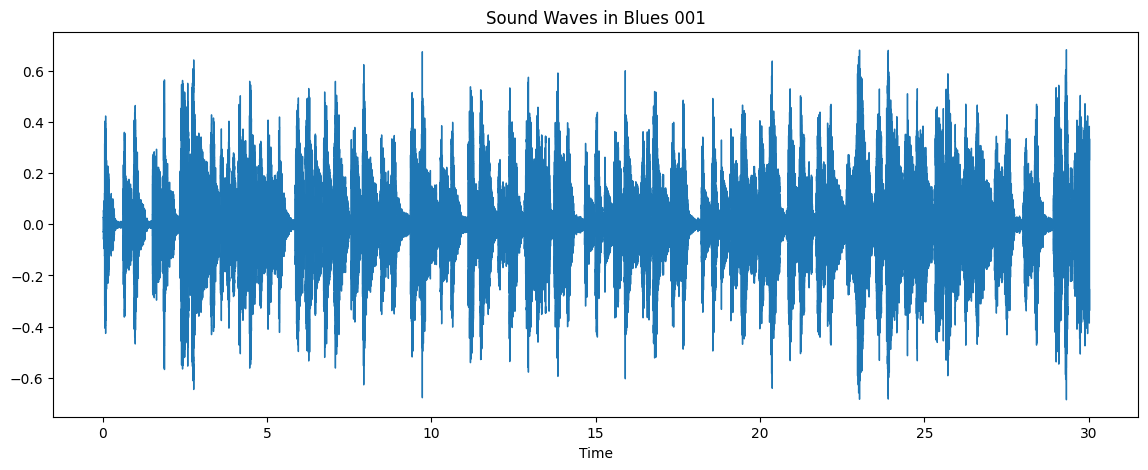

In [3]:
# Plot the waveform of the loaded audio
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y=audio, sr=sampling_rate)
plt.title("Sound Waves in Blues 001")
plt.show()

Now we will see how to trim the silent spaces at the beginning and at the end of an audio

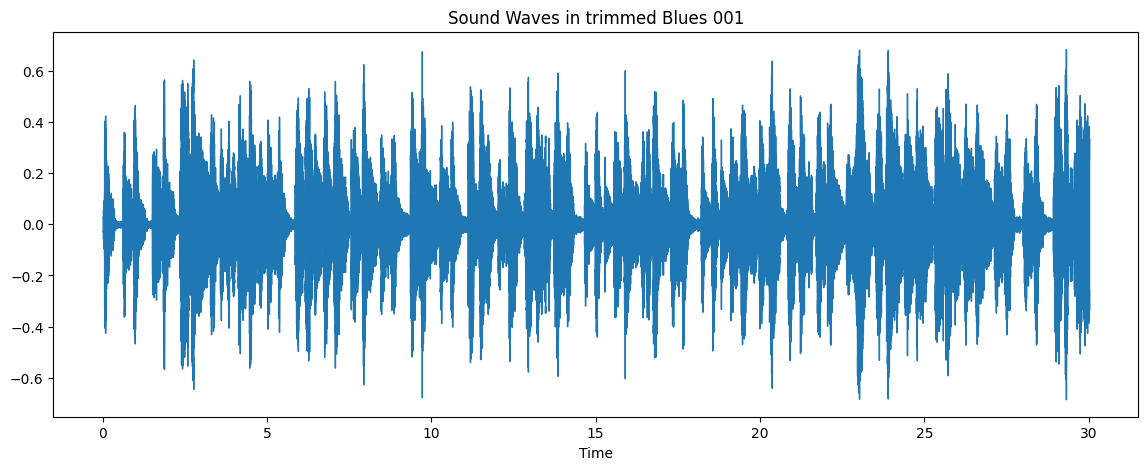

In [4]:
# Trim silent sections from the audio and plot the trimmed waveform
audio,_ =  librosa.effects.trim(audio)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y=audio, sr=sampling_rate)
plt.title("Sound Waves in trimmed Blues 001")
plt.show()

As you can see there is no change because there are no silent space **AT THE BEGINNING OR AT THE END** of the audio. If other samples do have them that will be trimmed

Now we will look at some features that we can extract from the loaded audio.

**ZERO CROSSING**

Zero Crossing (ZC) is a simple way to measure weather  a sound wave changes from positive to negative, or vice versa.
The Zero between the positive and negetive is the zero amplitude line—it’s the horizontal line at 0 in the above figure where the sound wave has no energy


We use librose.zero_crossing to extract the feature. It returns TRUE if there is a zero crossing in the sample or FALSE if there is none

In [5]:
# Calculate zero crossings of the audio
zero_crossings = librosa.zero_crossings(audio, pad=False)
# Print the zero crossings array and the total number of zero crossings
print(zero_crossings)
print(f"Total no of zero crossings: {sum(zero_crossings)}")

[False False False ... False False False]
Total no of zero crossings: 37139


**HARMONICS AND PERCEPTUALS**

Next we extract harmonics and perceptuals from the sample. We use librosa.effects.hpss for that it returns two numpy arrays, harmonics and perceptuals.

Harmonics array contains only the harmonics part of each sample in the audio and perceptuals contains only the perceptual part of each sample in the audio. The size of the each returned array is equal to the size of the passed numpy array.

**HARMONICS**

It contains smooth, pitch-based sounds like,Singing voice,Guitar chords and Sustained piano notes

**PERCEPTUALS**

It highlights short, sharp sounds like,Drums,Claps,some beatboxing etc,. Anything that’s more about rhythm than pitch

Harmonics: [ 0.00385567  0.00479104  0.00285076 ... -0.07233928 -0.1151228
 -0.10030796]
Shape of Harmonics:(661794,)

Perceptuals: [-0.0004377  -0.00048806 -0.00147747 ... -0.04719808 -0.05983446
 -0.0508761 ]
Shape of Perceptuals:(661794,)

Shape of audio: (661794,)



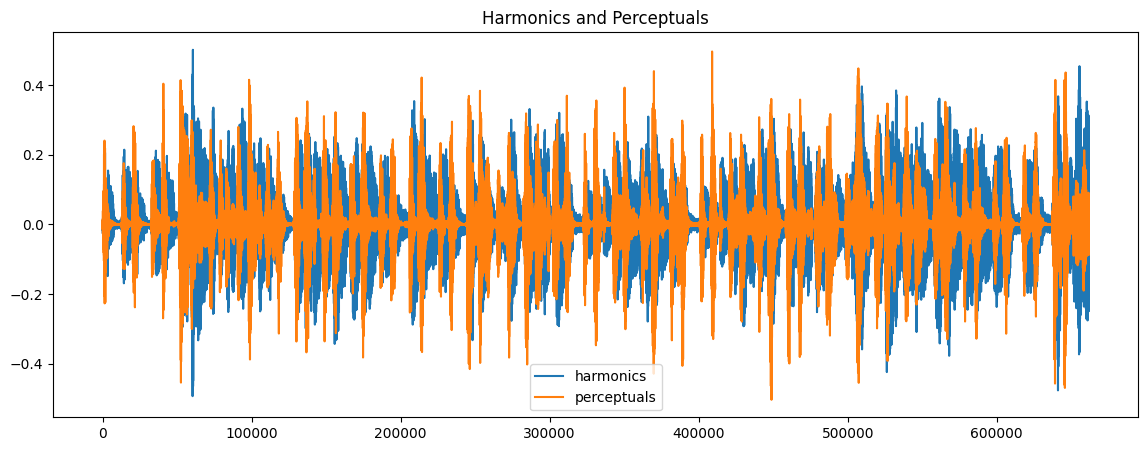

In [6]:
# Separate harmonics and perceptual components of the audio
harmonics, perceptuals = librosa.effects.hpss(audio)
# Print information about harmonics and perceptuals
print(f"Harmonics: {harmonics}")
print(f"Shape of Harmonics:{harmonics.shape}")
print()
print(f"Perceptuals: {perceptuals}")
print(f"Shape of Perceptuals:{perceptuals.shape}")
print()
print(f"Shape of audio: {audio.shape}")
print()
# Plot the harmonics and perceptuals
plt.figure(figsize=(14, 5))
plt.plot(harmonics, label='harmonics')
plt.plot(perceptuals, label='perceptuals')
plt.legend()
plt.title("Harmonics and Perceptuals")
plt.show()

As you can see the size of harmonics and perceptuals is consistent with the shape of audio

**TEMPO AND BEAT FRAMES**

We use librosa.beat.beat_track to extract the Tempo (Beats per minute) and beat frames of a sample.

Tempo is the overall beats per minute. Its is like the speed of a song

librosa.beat.beat_track also return the frames in which a beat is detected, that is beat frames is sparse is False or  beat locations are given in the specified units if is True



In [7]:
# Estimate the tempo and beat frames of the audio
tempo, beats_frames = librosa.beat.beat_track(y=audio, sr=sampling_rate, sparse = False)
# Print the estimated tempo and beat frames (not grouped)
print(f"Tempo: {tempo.squeeze()} BPM")
print()
print(f"Beat frames not grouped: {beats_frames}")
print()
# Estimate the tempo and beat frames again, this time grouped
tempo, beats_frames = librosa.beat.beat_track(y=audio, sr=sampling_rate)
# Print the estimated tempo and beat frames (grouped)
print(f"Tempo: {tempo.squeeze()} BPM")
print()
print(f"Beat frames grouped: {beats_frames}")

Tempo: 67.99958881578948 BPM

Beat frames not grouped: [False False False ... False False False]

Tempo: 67.99958881578948 BPM

Beat frames grouped: [   3   41   80  118  156  194  231  267  304  342  380  416  457  495
  533  570  609  646  685  723  761  800  837  874  914  951  990 1028
 1061 1094 1131 1170 1208 1247]


**TONNETZ**

The Tonnetz is a representation of how pitches or chords relate to one another harmonically. We extract tonnetz using librosa.feature.tonnetz. It returns and array consisting of six sub arrays

0: Fifth x-axis

1: Fifth y-axis

2: Minor x-axis

3: Minor y-axis

4: Major x-axis

5: Major y-axis

Tonnetz 0: [-0.00312636  0.00069822 -0.00147802 ...  0.01835958  0.02906144
  0.01473745]
Shape of Tonnetz 0: (1293,)


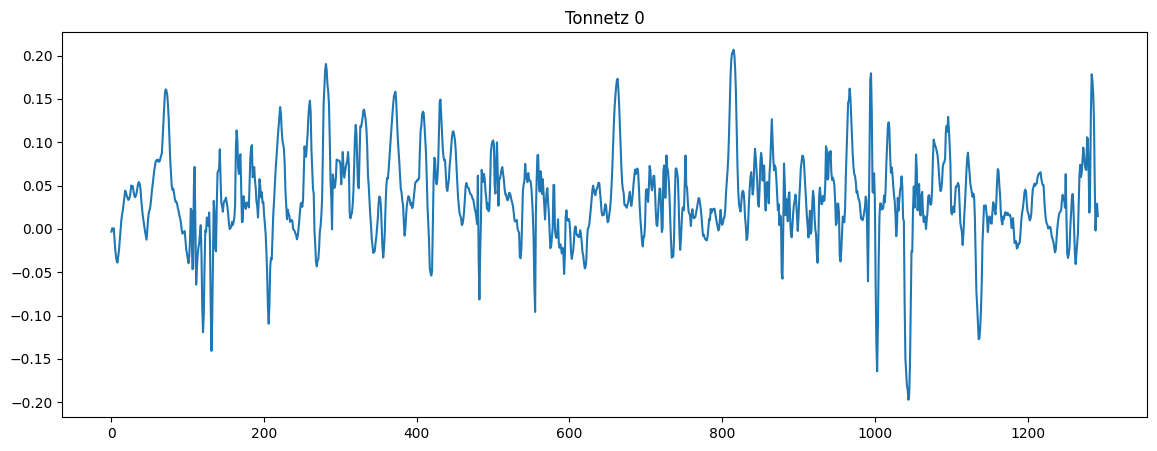

Tonnetz 1: [0.07267049 0.09141056 0.10535281 ... 0.08948192 0.15762424 0.1267832 ]
Shape of Tonnetz 1: (1293,)


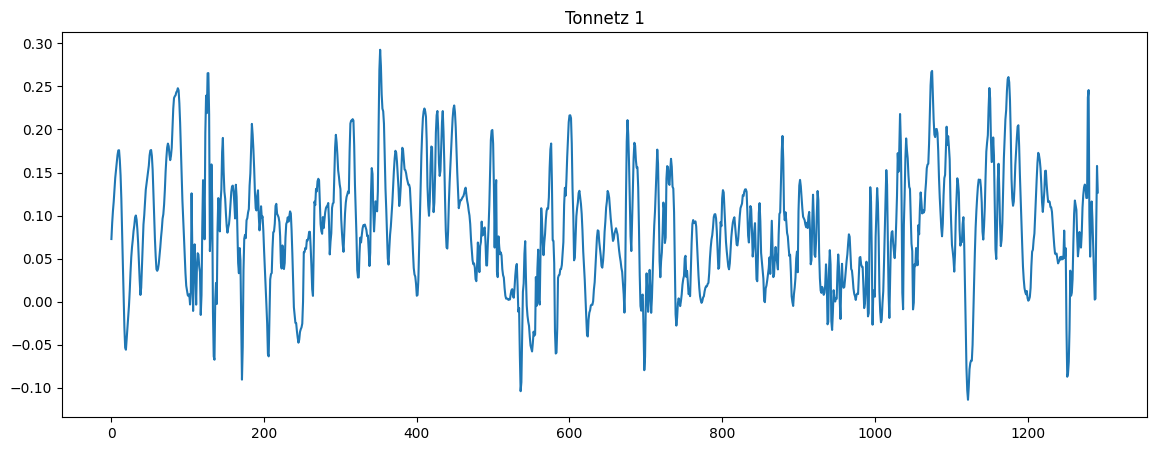

Tonnetz 2: [-0.04962912 -0.0443384  -0.04579847 ... -0.04375251 -0.00718081
 -0.01331291]
Shape of Tonnetz 2: (1293,)


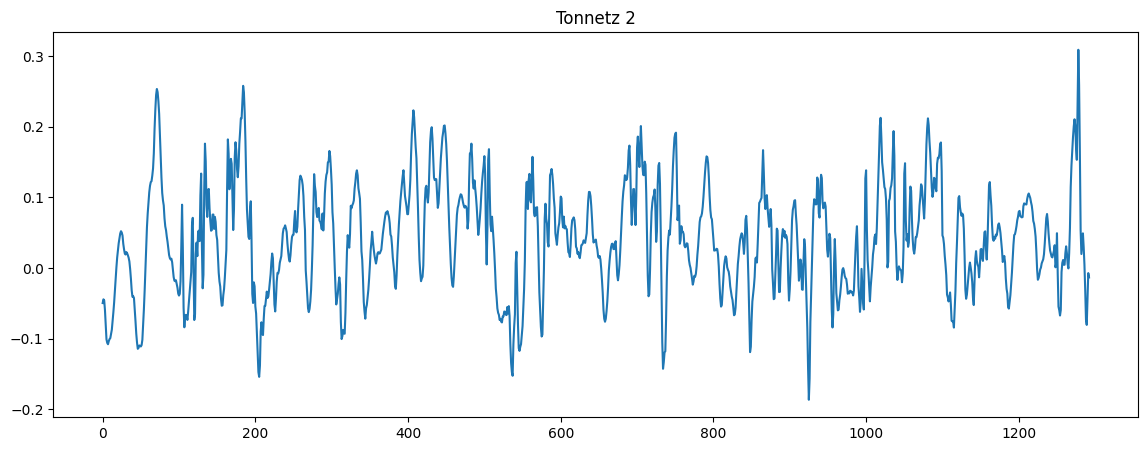

Tonnetz 3: [0.04212502 0.04340309 0.04241187 ... 0.11505215 0.13976344 0.12356269]
Shape of Tonnetz 3: (1293,)


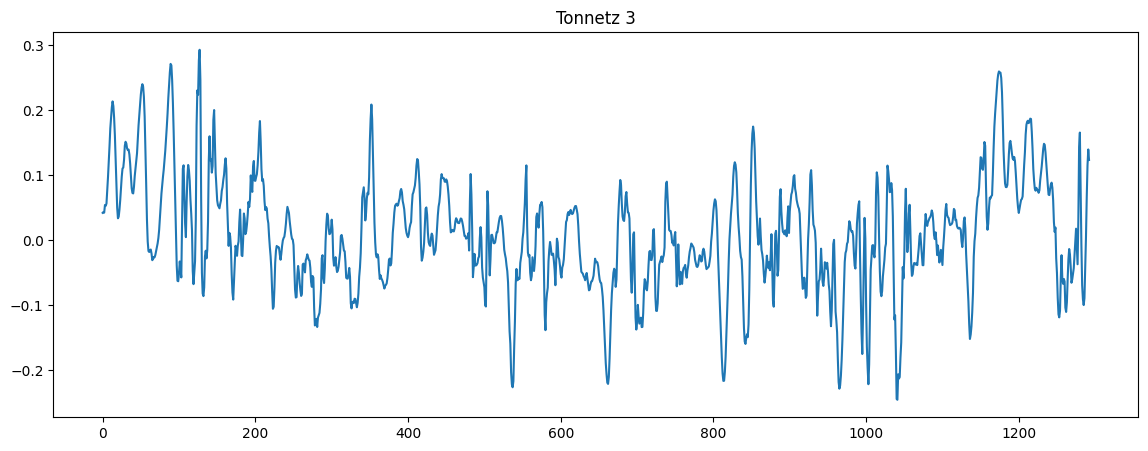

Tonnetz 4: [-0.00662922 -0.00475982 -0.00134667 ...  0.07494024  0.05655166
  0.04355728]
Shape of Tonnetz 4: (1293,)


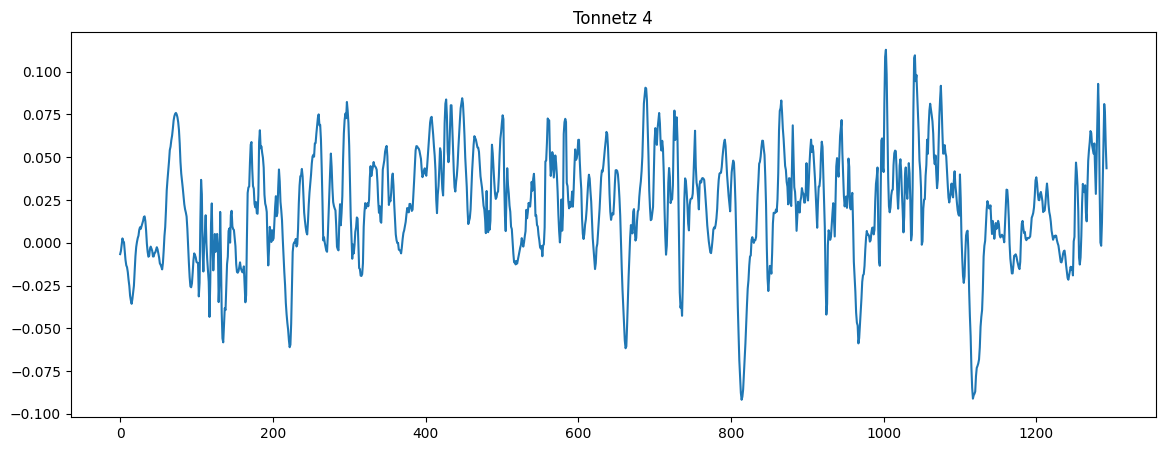

Tonnetz 5: [ 0.01545753  0.01743984  0.01857693 ... -0.00039113  0.03017485
  0.03080457]
Shape of Tonnetz 5: (1293,)


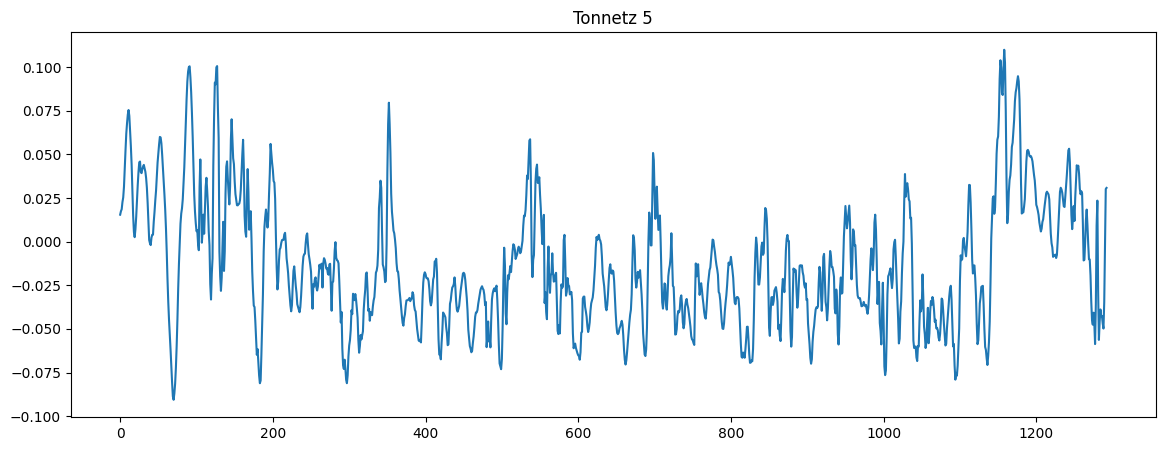

In [8]:
# Extract Tonnetz features from the audio
tonnetz = librosa.feature.tonnetz(y=audio, sr=sampling_rate)

# Iterate through the 6 Tonnetz dimensions and print/plot them
for i in range(6):
  tonnetz_i = tonnetz[i]
  print(f"Tonnetz {i}: {tonnetz_i}")
  print(f"Shape of Tonnetz {i}: {tonnetz_i.shape}")
  tonnetz_i = tonnetz[i].squeeze()
  plt.figure(figsize=(14, 5))
  plt.plot(tonnetz_i)
  plt.title(f"Tonnetz {i}")
  plt.show()

A heat map of tonnetz

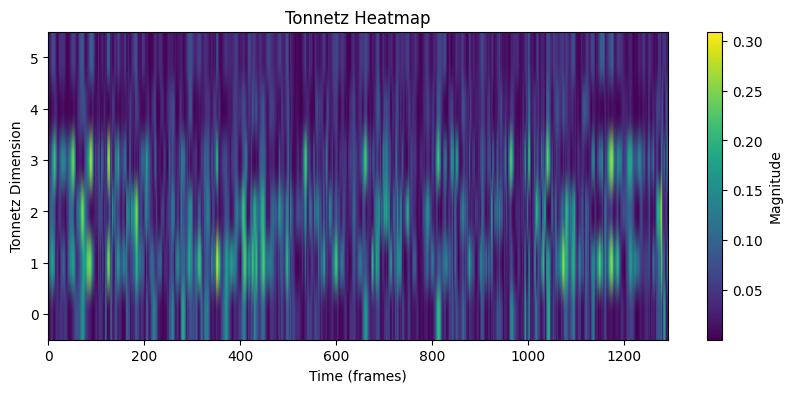

In [9]:
# Plot a heatmap of the Tonnetz features
plt.figure(figsize=(10, 4))
plt.imshow(np.abs(tonnetz), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (frames)')
plt.ylabel('Tonnetz Dimension')
plt.title('Tonnetz Heatmap')
plt.show()

**SPECTRAL CENTROID**

The spectral centroid of audio data is a feature that indicates where the "center of mass" of the spectrum is located. It tells you how bright or dark a sound is, based on the distribution of its frequencies.

Higher centroid would mean more high frequencies and indicates brighter or sharper sound (e.g., cymbals, whistles)

Lower centroid would mean more low frequencies and indicates darker or duller sound (e.g., bass drum, cello)

We can plot in on someting called log power spectogram which is basically Power spectrogram in log scale. Power spactogram Measures the power (energy) of each frequency bin over time. You can see the frequencies in the plot.
Power spectogram in log scale is better because it better represents how humans perceives loudness.

Spectral centroid is bascially derived from power spctrum ( not log scale but normal scale) but is a more refined and useful feature. So we extract this instead

CODE taken from official website of librosa
https://librosa.org/doc/0.11.0/generated/librosa.feature.spectral_centroid.html


Spectral centroid: [[ 886.90854909 1051.83134743 1125.26706995 ... 2048.37000305
  2010.93141731 1972.07978618]]
Shape of Spectral centroid: (1, 1293)


[Text(0.5, 1.0, 'log Power spectrogram of blues 001')]

<Figure size 1600x600 with 0 Axes>

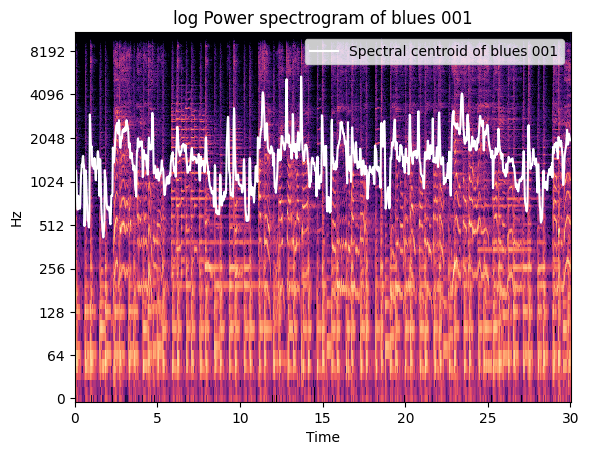

In [10]:
# Extract spectral centroid features
spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sampling_rate)
# Print spectral centroid information
print(f"Spectral centroid: {spectral_centroid}")
print(f"Shape of Spectral centroid: {spectral_centroid.shape}")

# Plot the spectral centroid on a log power spectrogram
plt.figure(figsize = (16, 6))
S, phase = librosa.magphase(librosa.stft(y=audio))
times = librosa.times_like(spectral_centroid)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(times, spectral_centroid.T, label='Spectral centroid of blues 001', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram of blues 001')

**Spectral Bandwidth**

spectral bandwidth referts to the range of frequencies within the audible spectrum that contain significant energy for a given sound

The upper limits of the spectral bandwidth and the presence of energy in higher frequencies  significantly contribute to the perceived or "airiness" of a sound. Conversely, substantial energy in the lower frequencies contributes and "fullness" of a sound.

Spectral bandwidth is closely related to spectral centroid and log power spectrum. Below is heat map that demostrates this in blues 001.

CODE taken from official website of librosa
https://librosa.org/doc/latest/generated/librosa.feature.spectral_bandwidth.html

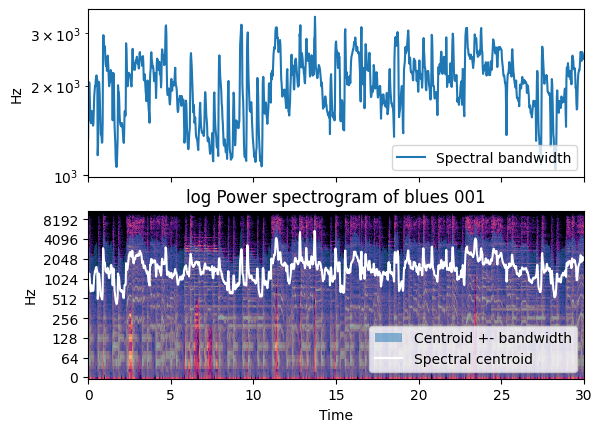

In [11]:
# Extract spectral bandwidth features
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate)

# Plot spectral bandwidth and spectral centroid on a log power spectrogram
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spectral_bandwidth)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spectral_bandwidth[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram of blues 001')
ax[1].fill_between(times, np.maximum(0, spectral_centroid[0] - spectral_bandwidth[0]),
                np.minimum(centroid[0] + spectral_bandwidth[0], sampling_rate/2),
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

**SPECTRAL ROLLOFF**

Spectral rolloff point, is a feature used to describe the distribution of energy in a sound's frequency spectrum.

More specifically, it is defined as the frequency below which a specified percentage of the total spectral energy of a signal is contained.

For librosa the default value of this is 0.85 which is what we extraced.

Below is a plot showing the spectral roll off of 0.99 and 0.01 on a log power spectrum of blues 001

CODE taken from official website of librosa
https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html

[Text(0.5, 1.0, 'log Power spectrogram of blues 001')]

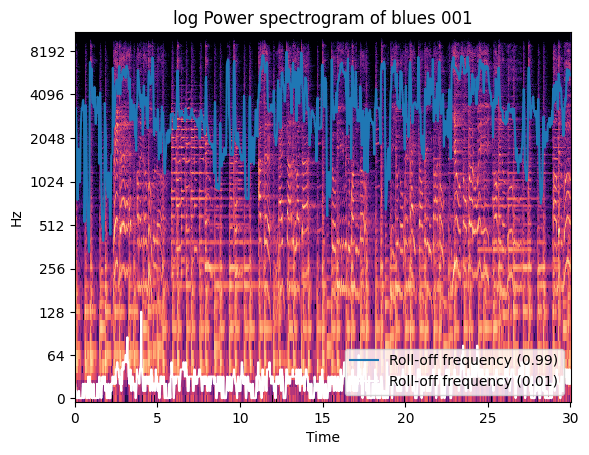

In [12]:
# Extract spectral rolloff features at different percentages
spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate)
rolloff_min = librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate, roll_percent=0.01)

# Plot spectral rolloff on a log power spectrogram
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax)
ax.plot(librosa.times_like(spectral_rolloff), spectral_rolloff[0], label='Roll-off frequency (0.99)')
ax.plot(librosa.times_like(spectral_rolloff), rolloff_min[0], color='w',
        label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log Power spectrogram of blues 001')

**SPECTRAL CONTRAST**

Spectral contrast measures the difference in energy (amplitude) between peaks and valleys in a sound spectrum across varoius frequency subands.

Here is a visulazation of spectral contrast of blues 001

spectral contrast: [[17.79094137 11.06542349 11.43209473 ... 19.38431904 15.94929819
  10.2691699 ]
 [12.40023169 11.6161755  14.55525931 ... 22.13079863 22.64963736
  19.33684375]
 [15.72432844 16.03560702 17.42328659 ... 21.68917663 25.63782341
  20.38967995]
 ...
 [16.0042476  13.36351653 15.55266811 ... 24.00301192 22.38046885
  16.80544049]
 [16.78564673 13.23650865 13.80009073 ... 19.05086596 20.47192687
  17.9977713 ]
 [21.24335166 33.99977254 38.31607872 ... 45.32513343 28.82139317
  18.31631206]]

shape of spectral contrast: (7, 1293)



Text(0.5, 1.0, 'Spectral Contrast')

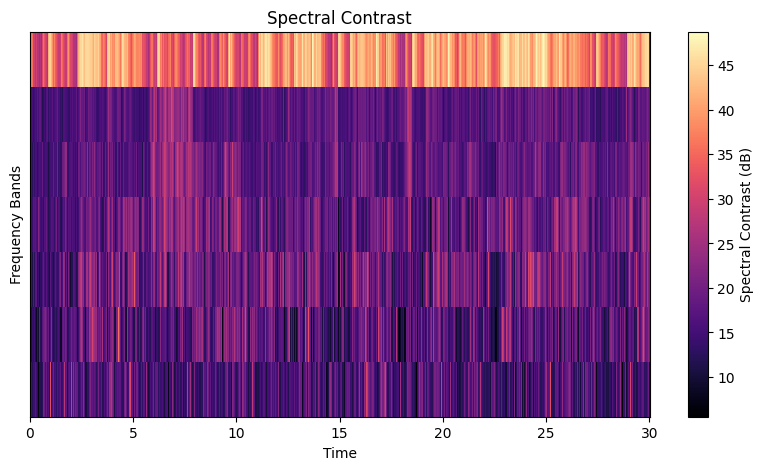

In [13]:
# Extract spectral contrast features
spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sampling_rate)
# Print spectral contrast information
print(f"spectral contrast: {spectral_contrast}")
print()
print(f"shape of spectral contrast: {spectral_contrast.shape}")
print()
# Display the spectral contrast as a heatmap
plt.figure(figsize=(10, 5))

# Display the spectral contrast
librosa.display.specshow(
    spectral_contrast,
    x_axis='time',
    sr=sampling_rate,
)
plt.colorbar(label='Spectral Contrast (dB)')
plt.ylabel('Frequency Bands')
plt.title('Spectral Contrast')

  As you can see the seven frequency bands matches with the seven sub vectors we got

**SPECTRAL FLATNESS**

Spectral flatness is a measure used in audio and signal processing to describe how noise-like or tone-like a sound is.
Spectral flatness values range from 0 to 1. 0 representing a very tonal sound and 1 representing white noise like sound



In [14]:
# Extract spectral flatness features
flatness = librosa.feature.spectral_flatness(y=audio)
# Print spectral flatness information
print(f"flatness: {flatness}")
print()
print(f"shape of flatness: {flatness.shape}")
print()

flatness: [[0.00080758 0.00106355 0.00085136 ... 0.00215714 0.00304132 0.00819226]]

shape of flatness: (1, 1293)



**ROOT MEAN SQUARE**

The Root-Mean-Square (RMS) is a way to measure the energy or loudness of a signal over time. It is computed per frame (frames are small chunks of a signal), it gives a time-varying energy profile of the audio.

rms: [[0.04788139 0.10656705 0.14316952 ... 0.13760294 0.12718666 0.10523266]]

shape of rms: (1, 1293)



Text(0.5, 14.722222222222216, 'Time')

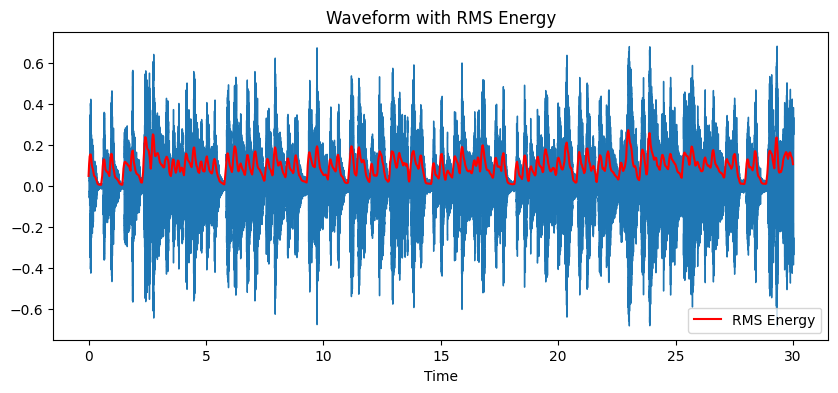

In [15]:
# Extract Root Mean Square (RMS) features
rms = librosa.feature.rms(y=audio)
# Print RMS information
print(f"rms: {rms}")
print()
print(f"shape of rms: {rms.shape}")
print()

# Convert frame indices to time for plotting
frames = range(rms.shape[1])
t = librosa.frames_to_time(frames, sr=sampling_rate)

# Plot waveform with RMS overlay
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sampling_rate)
plt.plot(t, rms[0], color='r', label='RMS Energy')
plt.legend(loc='lower right')
plt.title('Waveform with RMS Energy')
plt.xlabel('Time')

**CHROMA FEATURES**

Chroma features are a way of representing the harmonic and pitch content of audio by mapping all detected pitches into 12 pitch classes — one for each semitone in the Western musical scale.

Regardless of octave, every note in Western music falls into one of these 12 pitch classes:

C, C♯/D♭, D, D♯/E♭, E, F, F♯/G♭, G, G♯/A♭, A, A♯/B♭, B

chroma_stft computes chromagram for each of the pitch classes from power spectrogram

Below is a visulization of the chroma features of blues 001.

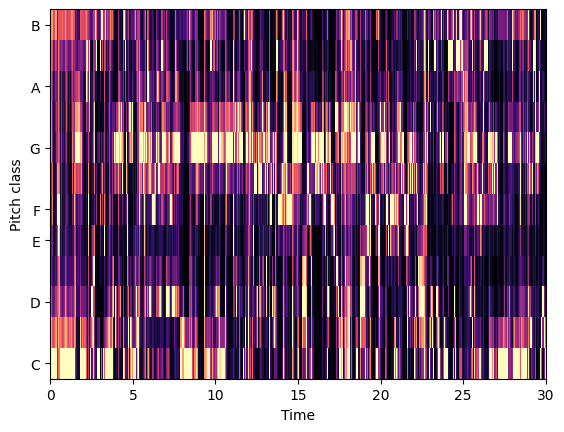

In [16]:
# Extract Chroma STFT features
chroma_stft = librosa.feature.chroma_stft(y= audio, sr=sampling_rate)
# Display the chromagram
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time')

**Fourier Transform**

The Fourier Transform of audio is a mathematical tool used to analyze the frequency content of a sound signal. It transforms a signal from the time domain (amplitude vs. time) to the frequency domain (amplitude vs. frequency).

Shape of Fourier Transform :(1025, 1293)


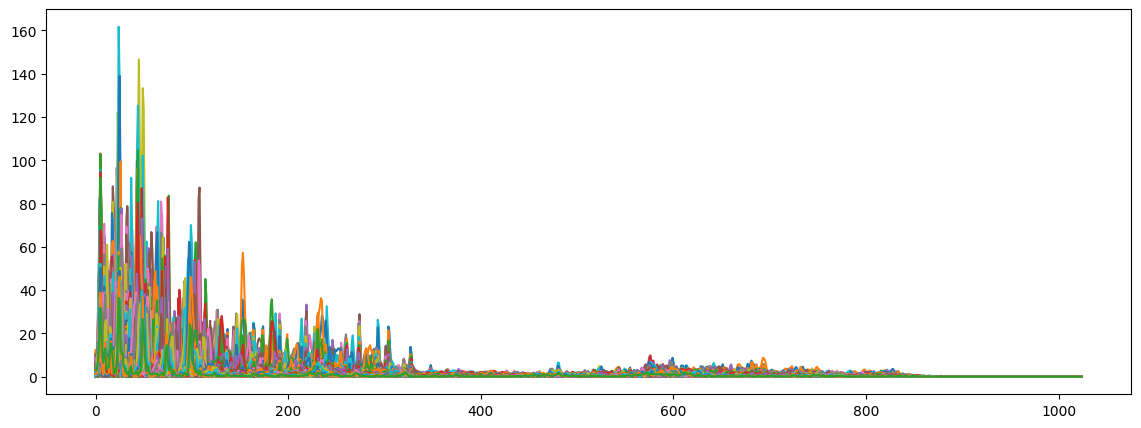

In [17]:
# Compute the Fourier Transform (STFT) of the audio
FT = np.abs(librosa.stft(audio))

# Print the shape of the Fourier Transform and plot it
print(f'Shape of Fourier Transform :{ np.shape(FT)}')
plt.figure(figsize = (14, 5))
plt.plot(FT);

**Spectrogram**

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.

A spectogram is derived from fourier transform

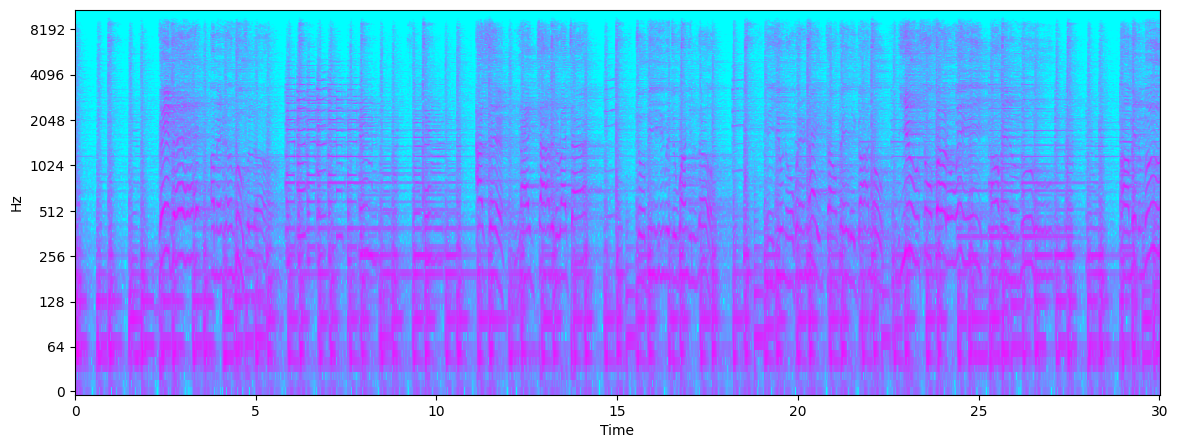

In [18]:
# Convert the Fourier Transform to decibels and display as a spectrogram
FT_DB = librosa.amplitude_to_db(FT) #convert amplitude o decibals
plt.figure(figsize = (14, 5))
librosa.display.specshow(FT_DB, sr = sampling_rate,x_axis = 'time', y_axis = 'log',cmap = 'cool')
plt.show();

**Mel spectrogram**

A mel spectrogram is a spectogram that is mapped onto the mel scale, which is designed to approximate how humans perceive pitch.

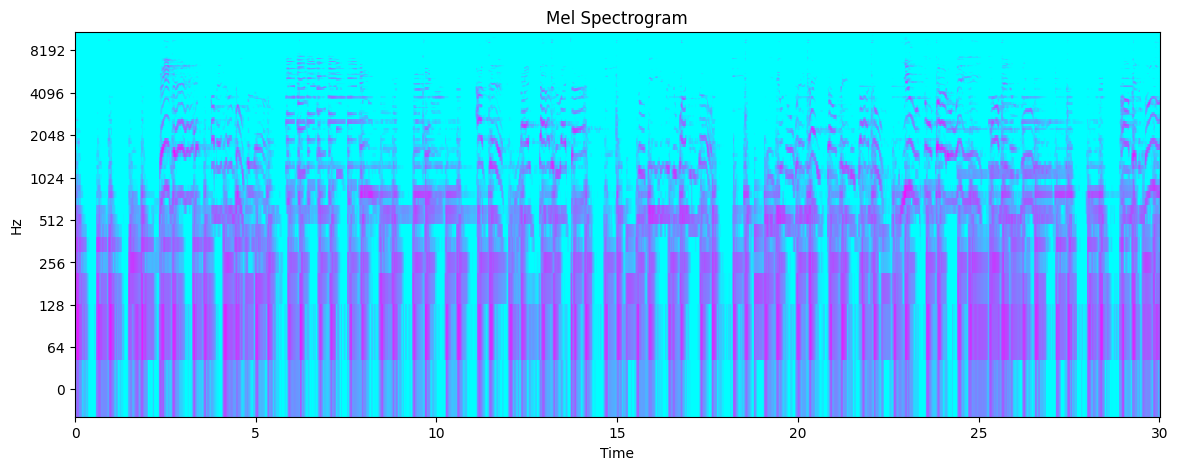

In [19]:
# Compute and display the Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sampling_rate)
mel_spec_DB = librosa.amplitude_to_db(mel_spec, ref=np.max) #convert amplitude to Decibels

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_spec_DB,x_axis = 'time', y_axis = 'log', sr=sampling_rate, cmap='cool')
plt.title("Mel Spectrogram")
plt.show()

**Mel-Frequency Cepstral Coefficients**

Mel-Frequency Cepstral Coefficients (MFCCs) are a set of features that capture the tone quality of an audio signal.

MFCC's are copmputed by taking the log of each mel-filtered power spectrum
and applying DCT (Discrete Cosine Transform).
In this case we have 20 MFCC's per frame.

A representation of the MFCC's derived is shown below



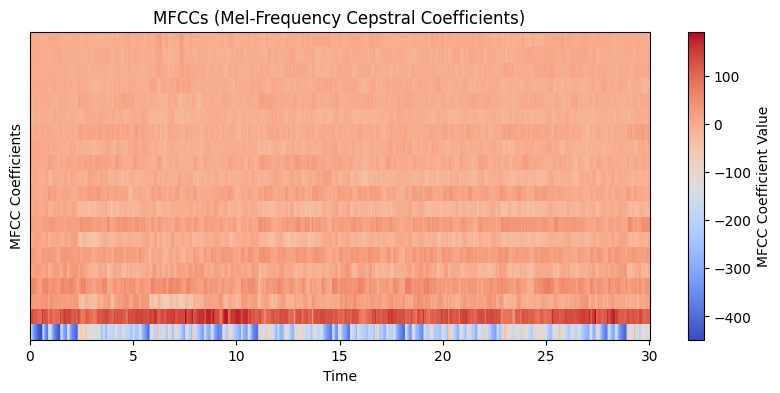

In [20]:
# Extract Mel-Frequency Cepstral Coefficients (MFCCs)
mfccs = librosa.feature.mfcc(y=audio, sr=sampling_rate)

# Plot the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sampling_rate)
plt.colorbar(label='MFCC Coefficient Value')
plt.title('MFCCs (Mel-Frequency Cepstral Coefficients)')
plt.ylabel('MFCC Coefficients')
plt.show()

# **Feature Extraction**

We will now proceed to extract the audio features previously identified during the exploration phase. Since these features are represented as vectors over time, we will summarize them by computing by extracting statistical features such as the mean, variance, and higher-order moments, like skewness and kurtosis.

 Mean is the first cental moment given by E[X], where X is the R.V. Usually represented by μ.

Variance is the second central moment given by E[(X−μ)^2] where μ is the mean

Skew is the next central moment (third) after variance given by E[(X−μ)^3]. Skew measures how symmwtric thw data is

Skewness close to 0 means that the distribution of RV(X) is approximately symmetric.

Skewness > 0 means that the distribution of RV(X) has a longer tail on the right (positively skewed).

Skewness < 0 means that the distribution of RV(X) has a longer tail on the left (negatively skewed).

Kurtosis is the fourth central moment given by E[(X−μ)^4].Kurtosis measures the "tailedness" or peakedness of the distribution of RV(X).

High kurtosis indicates "fat" tails which indicate the presence of outliers or extreme values.

Low kurtosis suggests a more uniform distribution with fewer extreme values.



In [ ]:
from typing_extensions import DefaultDict
from google.colab import drive, files
drive.mount('/content/drive')

from pathlib import Path
import datasets
import pandas as pd
import random
import librosa
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures,  normalize
from sklearn import preprocessing
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Define the list of genres and corrupted files
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
CORRUPTED_FILES = ["jazz.00054.wav"]

# generate examples is taken from the given website
# Function to generate file paths and genre labels
def generate_examples(path):
    paths = list(Path(path).glob("**/*.wav"))
    paths = [p for p in paths if "._" not in p.name]
    data = []

    for path in paths:
        label = path.parts[-2]
        name = path.parts[-1]
        if name in CORRUPTED_FILES:
            continue

        data.append({"file": str(path), "genre": label})
    df = pd.DataFrame(data)
    df.sort_values("file", inplace=True)

    for idx_, row in df.iterrows():    #slight change to how the data is loaded into the generator from the website
        yield  {"id": idx_,"file": row["file"], "genre": row["genre"]}


# Function to extract features from audio files and save to a CSV
def extract_features_download_csv(path):
    random.seed(0)
    gen = generate_examples(path)
    data = DefaultDict(list)
    count = 0
    for i in gen:
        # Load the audio file
        audio, sampling_rate = librosa.load(i['file'])

        # Trim silence from the audio
        trimmed_audio,_ =  librosa.effects.trim(audio)

        # Extract Zero Crossings features
        zero_crossings = librosa.zero_crossings(trimmed_audio, pad=False)
        zero_crossings_mean = np.mean(zero_crossings)
        zero_crossings_var = np.var(zero_crossings)

        data['zero_crossings_mean'].append(zero_crossings_mean)
        data['zero_crossings_var'].append(zero_crossings_var)

        # Extract Harmonics and Perceptuals features
        harmonic, perceptual = librosa.effects.hpss(trimmed_audio)

        harmonic_mean = np.mean(harmonic)
        harmonic_var = np.var(harmonic)
        perceptual_mean = np.mean(perceptual)
        perceptual_var = np.var(perceptual)

        data['harmonic_mean'].append(harmonic_mean)
        data['harmonic_var'].append(harmonic_var)

        data['perceptual_mean'].append(perceptual_mean)
        data['perceptual_var'].append(perceptual_var)

        # Extract Tempo and Beat Frames features
        tempo, beats  = librosa.beat.beat_track(y=trimmed_audio, sr=sampling_rate)
        data['tempo'].append(tempo[0])

        beat_times = librosa.times_like(beats, sr=sampling_rate)
        beat_times_diff = np.diff(beat_times)

        beat_times_diff_mean = np.mean(beat_times_diff)
        beat_times_diff_var = np.var(beat_times_diff)
        data['beat_times_diff_mean'].append(beat_times_diff_mean)
        data['beat_times_diff_var'].append(beat_times_diff_var)

        # Extract Tonnetz features
        tonnetz = librosa.feature.tonnetz(y=trimmed_audio, sr=sampling_rate)

        for i in range(6):
            tonnetz_i = tonnetz[i]
            tonnetz_mean = np.mean(tonnetz_i)
            tonnetz_var = np.var(tonnetz_i)
            data[f'tonnetz_mean_{i}'].append(tonnetz_mean)
            data[f'tonnetz_var_{i}'].append(tonnetz_var)

        # Extract Spectral Centroid features
        spectral_centroids = librosa.feature.spectral_centroid(y=trimmed_audio, sr=sampling_rate)
        spectral_centroids = spectral_centroids.squeeze()
        spectral_centroids_mean = np.mean(spectral_centroids)
        spectral_centroids_var = np.var(spectral_centroids)
        spectral_centroids_skew = skew(spectral_centroids)
        spectral_centroids_kurtosis = kurtosis(spectral_centroids)

        data['spectral_centroids_mean'].append(spectral_centroids_mean)
        data['spectral_centroids_var'].append(spectral_centroids_var)
        data['spectral_centroids_skew'].append(spectral_centroids_skew)
        data['spectral_centroids_kurtosis'].append(spectral_centroids_kurtosis)

        # Extract Spectral Rolloff features
        spectral_rolloff = librosa.feature.spectral_rolloff(y=trimmed_audio, sr=sampling_rate)
        spectral_rolloff = spectral_rolloff.squeeze()
        spectral_rolloff_mean = np.mean(spectral_rolloff)
        spectral_rolloff_var = np.var(spectral_rolloff)
        spectral_rolloff_skew = skew(spectral_rolloff)
        spectral_rolloff_kurtosis = kurtosis(spectral_rolloff)

        data['spectral_rolloff_mean'].append(spectral_rolloff_mean)
        data['spectral_rolloff_var'].append(spectral_rolloff_var)
        data['spectral_rolloff_skew'].append(spectral_rolloff_skew)
        data['spectral_rolloff_kurtosis'].append(spectral_rolloff_kurtosis)

        # Extract Chroma STFT features
        chroma_stft = librosa.feature.chroma_stft(y=trimmed_audio, sr=sampling_rate)

        chroma_stft_mean = np.mean(chroma_stft)
        chroma_stft_var = np.var(chroma_stft)

        data['chroma_stft_mean'].append(chroma_stft_mean)
        data['chroma_stft_var'].append(chroma_stft_var)


        # Extract Spectral Bandwidth features
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=trimmed_audio, sr=sampling_rate)
        spectral_bandwidth = spectral_bandwidth.squeeze()
        spectral_bandwidth_mean = np.mean(spectral_bandwidth)
        spectral_bandwidth_var = np.var(spectral_bandwidth)
        spectral_bandwidth_skew = skew(spectral_bandwidth)
        spectral_bandwidth_kurtosis = kurtosis(spectral_bandwidth)

        data['spectral_bandwidth_mean'].append(spectral_bandwidth_mean)
        data['spectral_bandwidth_var'].append(spectral_bandwidth_var)
        data['spectral_bandwidth_skew'].append(spectral_bandwidth_skew)
        data['spectral_bandwidth_kurtosis'].append(spectral_bandwidth_kurtosis)

        # Extract Spectral Contrast features
        spectral_contrast = librosa.feature.spectral_contrast(y=trimmed_audio, sr=sampling_rate)
        spectral_contrast_mean = np.mean(spectral_contrast)
        spectral_contrast_var = np.var(spectral_contrast)

        data['spectral_contrast_mean'].append(spectral_contrast_mean)
        data['spectral_contrast_var'].append(spectral_contrast_var)

        # Extract Spectral Flatness features
        spectral_flatness = librosa.feature.spectral_flatness(y=trimmed_audio)
        spectral_flatness = spectral_flatness.squeeze()
        spectral_flatness_mean = np.mean(spectral_flatness)
        spectral_flatness_var = np.var(spectral_flatness)
        spectral_flatness_skew = skew(spectral_flatness)
        spectral_flatness_kurtosis = kurtosis(spectral_flatness)

        data['spectral_flatness_mean'].append(spectral_flatness_mean)
        data['spectral_flatness_var'].append(spectral_flatness_var)
        data['spectral_flatness_skew'].append(spectral_flatness_skew)
        data['spectral_flatness_kurtosis'].append(spectral_flatness_kurtosis)

        # Extract RMS features
        rms = librosa.feature.rms(y=trimmed_audio)
        rms = rms.squeeze()
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)
        rms_max = np.max(rms)
        rms_skew = skew(rms)
        rms_kurtosis = kurtosis(rms)

        data['rms_mean'].append(rms_mean)
        data['rms_var'].append(rms_var)
        data['rms_max'].append(rms_max)
        data['rms_skew'].append(rms_skew)
        data['rms_kurtosis'].append(rms_kurtosis)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=trimmed_audio, sr=sampling_rate)
        for ui in range(20):
          mfcc_mean = np.mean(mfcc[ui])
          mfcc_var = np.var(mfcc[ui])
          data[f'mfcc_{ui}_mean'].append(mfcc_mean)
          data[f'mfcc_{ui}_var'].append(mfcc_var)

        # Extract MFCC Delta features
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta_mean = np.mean(mfcc_delta)
        mfcc_delta_var = np.var(mfcc_delta)
        data['mfcc_delta_mean'].append(mfcc_delta_mean)
        data['mfcc_delta_var'].append(mfcc_delta_var)

        # Extract MFCC Delta2 features
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_delta2_mean = np.mean(mfcc_delta2)
        mfcc_delta2_var = np.var(mfcc_delta2)
        data['mfcc_delta2_mean'].append(mfcc_delta2_mean)
        data['mfcc_delta2_var'].append(mfcc_delta2_var)

        # Extract Polynomial Features (order 1)
        poly_features_1 = librosa.feature.poly_features(y=trimmed_audio, sr=sampling_rate, order = 1)
        poly_features_mean_order_1 = np.mean(poly_features_1)
        poly_features_var_order_1 = np.var(poly_features_1)
        data['poly_features_mean_order_1'].append(poly_features_mean_order_1)
        data['poly_features_var_order_1'].append(poly_features_var_order_1)

        # Extract Polynomial Features (order 0)
        poly_features_0 = librosa.feature.poly_features(y=trimmed_audio, sr=sampling_rate, order = 0)
        poly_features_mean_order_0 = np.mean(poly_features_0)
        poly_features_var_order_0 = np.var(poly_features_0)
        data['poly_features_mean_order_0'].append(poly_features_mean_order_0)
        data['poly_features_var_order_0'].append(poly_features_var_order_0)

        #print count for every 50 audio samples extracted
        count = count + 1
        if(count%50 == 0):
          print(count)

    # Create a DataFrame from the extracted features
    dataframe = pd.DataFrame(data)
    filename = 'more_project_data.csv'
    # Save the DataFrame to a CSV file
    dataframe.to_csv(filename, index=False)
    print('done!')
    # Download the CSV file
    files.download(filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#calling the extract feature function we just created
extract_features_download_csv('/content/drive/MyDrive/genres')

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
done!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Data Exploration**

Now we will load the data and explore it further

In [21]:
# Load the extracted features from the CSV file into a pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/more_project_data.csv")
# Display the first few rows of the DataFrame
df.head()

filename  genre  zero_crossings_mean  zero_crossings_var  \
0  blues.00000.  blues             0.083154            0.076240   
1  blues.00001.  blues             0.056119            0.052969   
2  blues.00002.  blues             0.076403            0.070566   
3  blues.00003.  blues             0.033359            0.032246   
4  blues.00004.  blues             0.101580            0.091261   

   harmonic_mean  harmonic_var  perceptual_mean  perceptual_var       tempo  \
0      -0.000049      0.008172        -0.000011        0.005704  123.046875   
1       0.000141      0.005101        -0.000180        0.003064   67.999589   
2      -0.000002      0.016344        -0.000020        0.007464  161.499023   
3       0.000004      0.019055        -0.000018        0.002711   63.024009   
4      -0.000018      0.004814        -0.000010        0.003094  135.999178   

   beat_times_diff_mean  ...  mfcc_19_mean  mfcc_19_var  mfcc_delta_mean  \
0               0.02322  ...      1.222467    46.941350         0.002705   
1               0.02322  ...      0.530644    45.788700         0.002225   
2               0.02322  ...     -2.238128    30.653150         0.000264   
3               0.02322  ...     -3.405046    31.965258        -0.010571   
4               0.02322  ...    -11.704385    55.190254         0.007164   

   mfcc_delta_var  mfcc_delta2_mean  mfcc_delta2_var  \
0        7.806241          0.000076         2.485948   
1       14.633180         -0.004958         4.138907   
2       10.715713         -0.000662         4.014263   
3       12.658952         -0.001027         3.340087   
4       11.966584         -0.002489         3.735821   

   poly_features_mean_order_1  poly_features_var_order_1  \
0                   -0.000425               4.280840e-08   
1                   -0.000253               2.522515e-08   
2                   -0.000605               6.290341e-08   
3                   -0.000317               3.394270e-08   
4                   -0.000295               2.735963e-08   

   poly_features_mean_order_0  poly_features_var_order_0  
0                    3.504925                   2.914089  
1                    2.069585                   1.758088  
2                    4.908183                   4.296029  
3                    2.487310                   2.160988  
4                    2.498671                   2.153620  

[5 rows x 96 columns]

In [22]:
# Display the column names of the DataFrame
df.columns

Index(['filename', 'genre', 'zero_crossings_mean', 'zero_crossings_var',
       'harmonic_mean', 'harmonic_var', 'perceptual_mean', 'perceptual_var',
       'tempo', 'beat_times_diff_mean', 'beat_times_diff_var',
       'tonnetz_mean_0', 'tonnetz_var_0', 'tonnetz_mean_1', 'tonnetz_var_1',
       'tonnetz_mean_2', 'tonnetz_var_2', 'tonnetz_mean_3', 'tonnetz_var_3',
       'tonnetz_mean_4', 'tonnetz_var_4', 'tonnetz_mean_5', 'tonnetz_var_5',
       'spectral_centroids_mean', 'spectral_centroids_var',
       'spectral_centroids_skew', 'spectral_centroids_kurtosis',
       'spectral_rolloff_mean', 'spectral_rolloff_var',
       'spectral_rolloff_skew', 'spectral_rolloff_kurtosis',
       'chroma_stft_mean', 'chroma_stft_var', 'spectral_bandwidth_mean',
       'spectral_bandwidth_var', 'spectral_bandwidth_skew',
       'spectral_bandwidth_kurtosis', 'spectral_contrast_mean',
       'spectral_contrast_var', 'spectral_flatness_mean',
       'spectral_flatness_var', 'spectral_flatness_skew',
 

In [23]:
# Display descriptive statistics for all columns in the DataFrame
df.describe(include='all').T

count unique          top freq      mean  \
filename                      999    999  rock.00099.    1       NaN   
genre                         999     10        blues  100       NaN   
zero_crossings_mean         999.0    NaN          NaN  NaN  0.103817   
zero_crossings_var          999.0    NaN          NaN  NaN  0.091286   
harmonic_mean               999.0    NaN          NaN  NaN -0.000366   
...                           ...    ...          ...  ...       ...   
mfcc_delta2_var             999.0    NaN          NaN  NaN  3.368896   
poly_features_mean_order_1  999.0    NaN          NaN  NaN -0.000356   
poly_features_var_order_1   999.0    NaN          NaN  NaN       0.0   
poly_features_mean_order_0  999.0    NaN          NaN  NaN  3.210668   
poly_features_var_order_0   999.0    NaN          NaN  NaN  2.433996   

                                 std       min       25%       50%       75%  \
filename                         NaN       NaN       NaN       NaN       NaN   
genre                            NaN       NaN       NaN       NaN       NaN   
zero_crossings_mean         0.041889  0.021727  0.070473  0.099705  0.132283   
zero_crossings_var          0.032326  0.021255  0.065506  0.089764  0.114784   
harmonic_mean               0.001685 -0.026058 -0.000102 -0.000003  0.000001   
...                              ...       ...       ...       ...       ...   
mfcc_delta2_var             2.490469  0.227454  1.629643  2.653014  4.471479   
poly_features_mean_order_1  0.000191 -0.001079 -0.000467  -0.00034 -0.000222   
poly_features_var_order_1        0.0       0.0       0.0       0.0       0.0   
poly_features_mean_order_0  1.788492  0.104632  1.894123   3.02708  4.292596   
poly_features_var_order_0   2.514604  0.002199  0.754142  1.615467   3.12955   

                                  max  
filename                          NaN  
genre                             NaN  
zero_crossings_mean          0.274987  
zero_crossings_var           0.199369  
harmonic_mean                0.015051  
...                               ...  
mfcc_delta2_var               18.5995  
poly_features_mean_order_1  -0.000014  
poly_features_var_order_1         0.0  
poly_features_mean_order_0   9.902259  
poly_features_var_order_0   16.681087  

[96 rows x 11 columns]

Now we will do a box plot for tempo of different generes

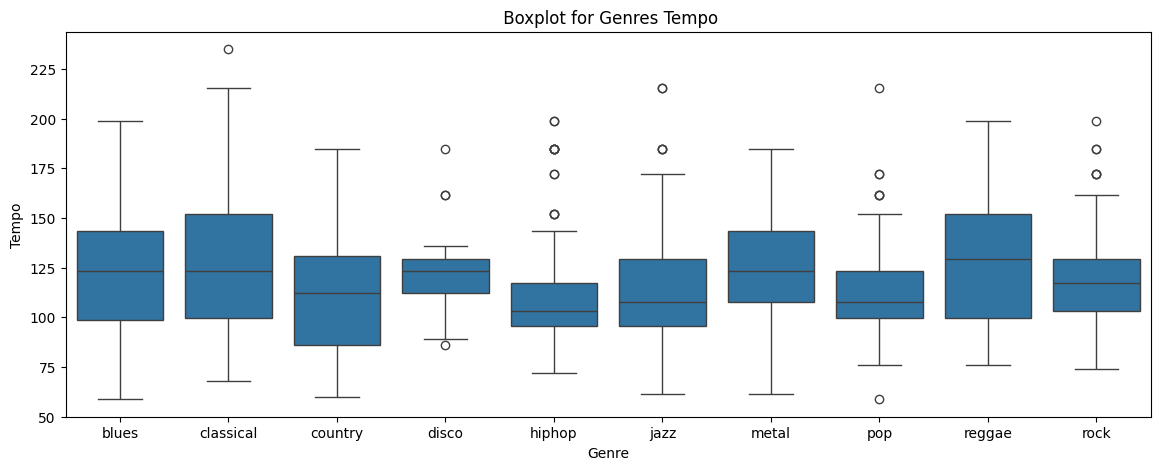

In [24]:
# Create a box plot to visualize the tempo distribution for each genre
x = df[["genre", "tempo"]]
plt.subplots(figsize=(14, 5))
sns.boxplot(x = "genre", y = "tempo", data = x);
plt.title(' Boxplot for Genres Tempo')
plt.xlabel("Genre")
plt.ylabel("Tempo")
plt.show()

Co relation betwee different predictors is important and some models asuume or data with very low co relation like naive bayers.
Now we will explore the co relation in the data

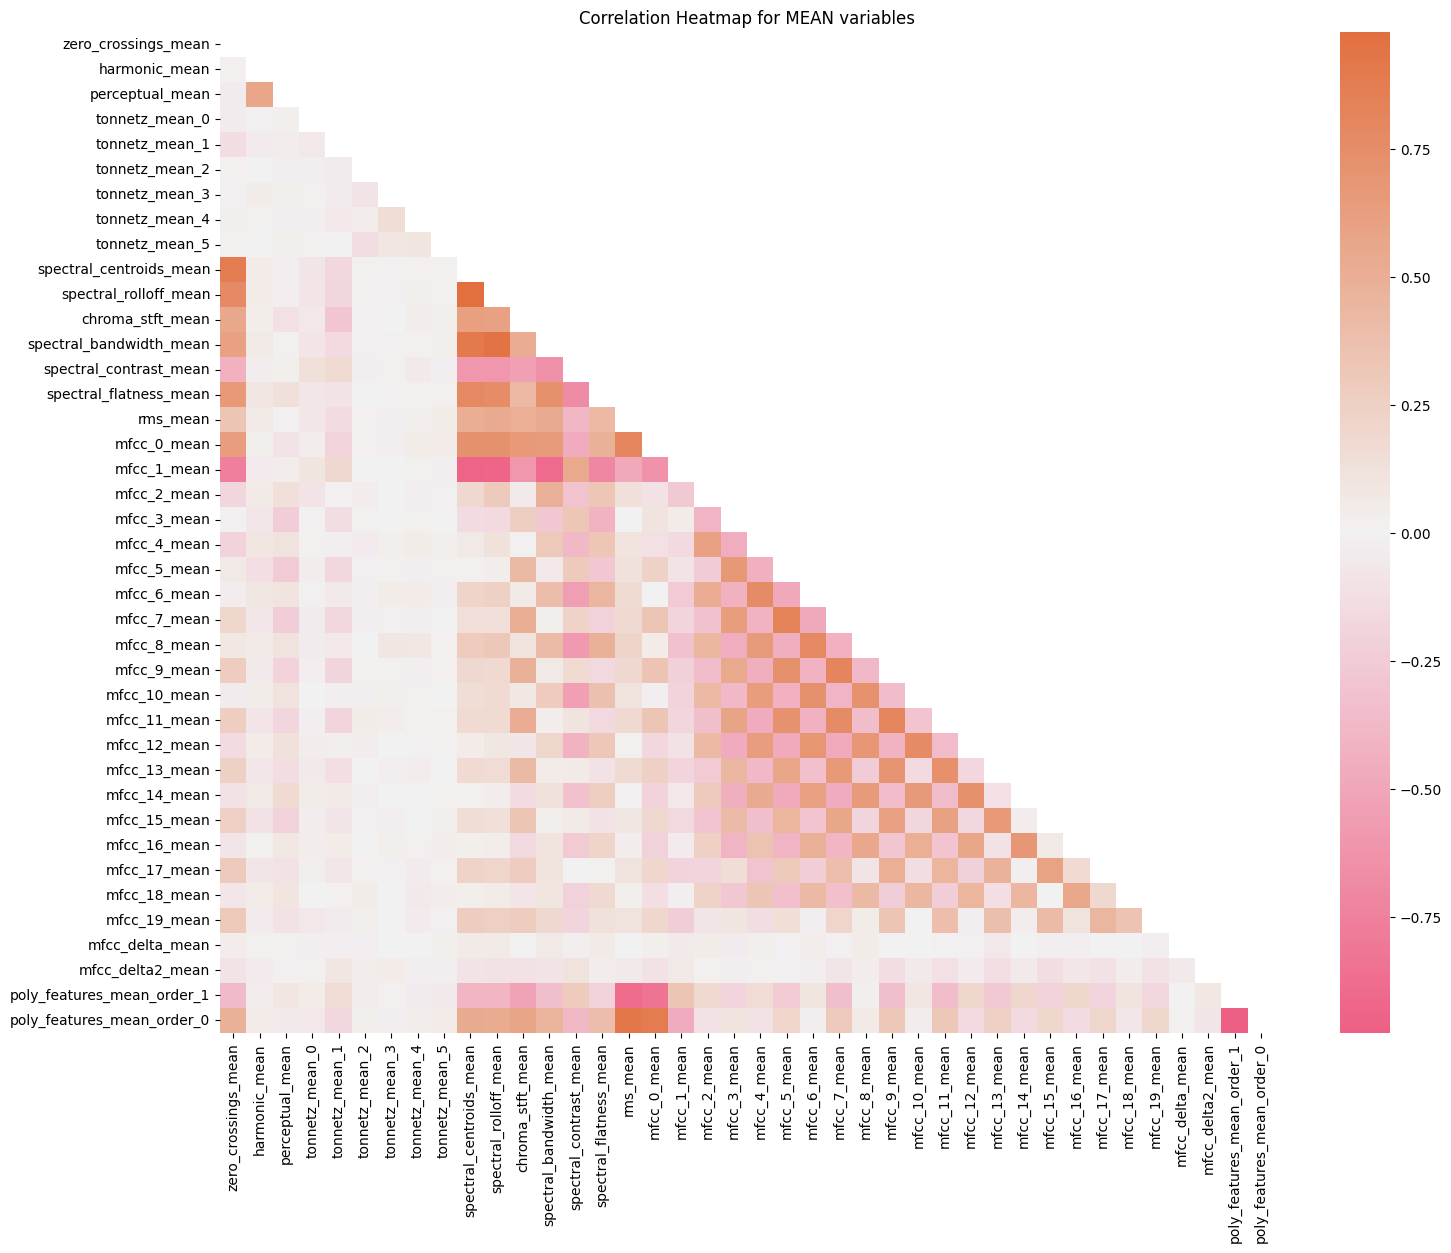

In [25]:
# Computing the Correlation Matrix for mean features
heat_map_cols = [col for col in df.columns if 'mean' in col and not(col=='beat_times_diff_mean')]

corr = df[heat_map_cols].corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure for the heatmap
plt.subplots(figsize=(17, 13))

# Define the color map for the heatmap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=80, l=60)

# Draw the heatmap
sns.heatmap(corr,cmap = cmap,mask = mask)

# Set the title of the heatmap
plt.title('Correlation Heatmap for MEAN variables')
# Display the heatmap
plt.show()

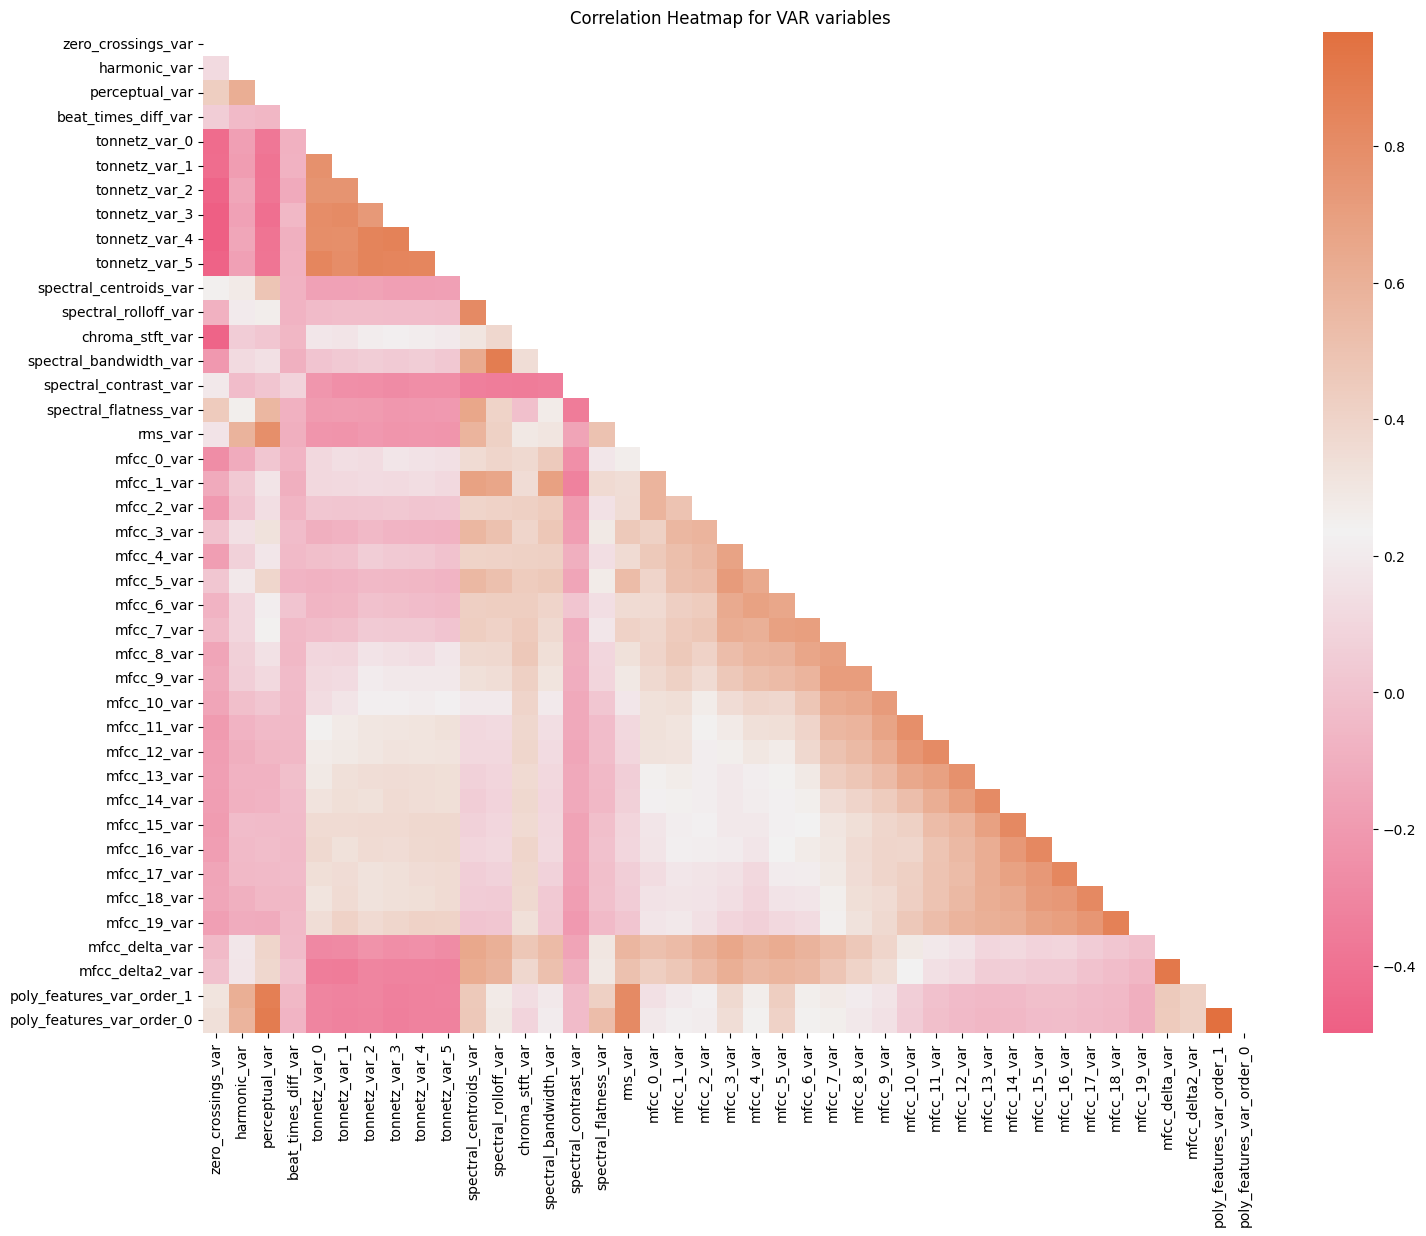

In [26]:
# Computing the Correlation Matrix for variance features
heat_map_cols = [col for col in df.columns if 'var' in col ]

corr = df[heat_map_cols].corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure for the heatmap
plt.subplots(figsize=(17, 13))

# Define the color map for the heatmap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=80, l=60)

# Draw the heatmap
sns.heatmap(corr,cmap = cmap,mask = mask)

# Set the title of the heatmap
plt.title('Correlation Heatmap for VAR variables')
# Display the heatmap
plt.show()

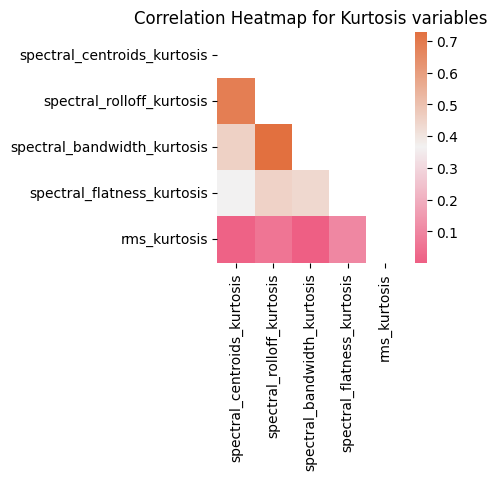

In [27]:
# Computing the Correlation Matrix for kurtosis features
heat_map_cols = [col for col in df.columns if 'kurtosis' in col ]
corr = df[heat_map_cols].corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure for the heatmap
plt.subplots(figsize=(3, 3))

# Define the color map for the heatmap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=80, l=60)

# Draw the heatmap
sns.heatmap(corr,cmap = cmap,mask = mask)

# Set the title of the heatmap
plt.title('Correlation Heatmap for Kurtosis variables')
# Display the heatmap
plt.show()

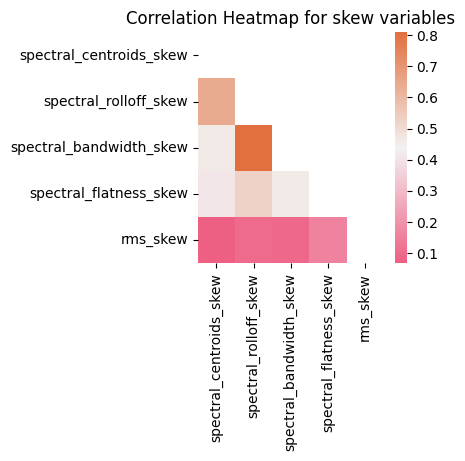

In [28]:
# Computing the Correlation Matrix for skewness features
heat_map_cols = [col for col in df.columns if 'skew' in col ]
corr = df[heat_map_cols].corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure for the heatmap
plt.subplots(figsize=(3, 3))

# Define the color map for the heatmap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=80, l=60)

# Draw the heatmap
sns.heatmap(corr,cmap = cmap,mask = mask)

# Set the title of the heatmap
plt.title('Correlation Heatmap for skew variables')
# Display the heatmap
plt.show()

How we will do PCA on the data and visulize it interms of first two components

In [29]:
# Separate features and target variable
y = df.pop('genre')
df.pop('filename')

# Scale the features using StandardScaler
scaler = preprocessing.StandardScaler()
df_scaled = scaler.fit_transform(df)

# Perform PCA with 2 components
pca = PCA(n_components=2)
principal_components_1_2 = pca.fit_transform(df_scaled)
principal_comp_df = pd.DataFrame(data = principal_components_1_2, columns = ['principal component 1', 'principal component 2'])

# Concatenate the principal components with the target label
data = pd.concat([principal_comp_df , y], axis = 1)

# Print the explained variance ratio of the principal components
pca.explained_variance_ratio_

array([0.19204021, 0.16703277])

Text(0, 0.5, 'Principal Component 2')

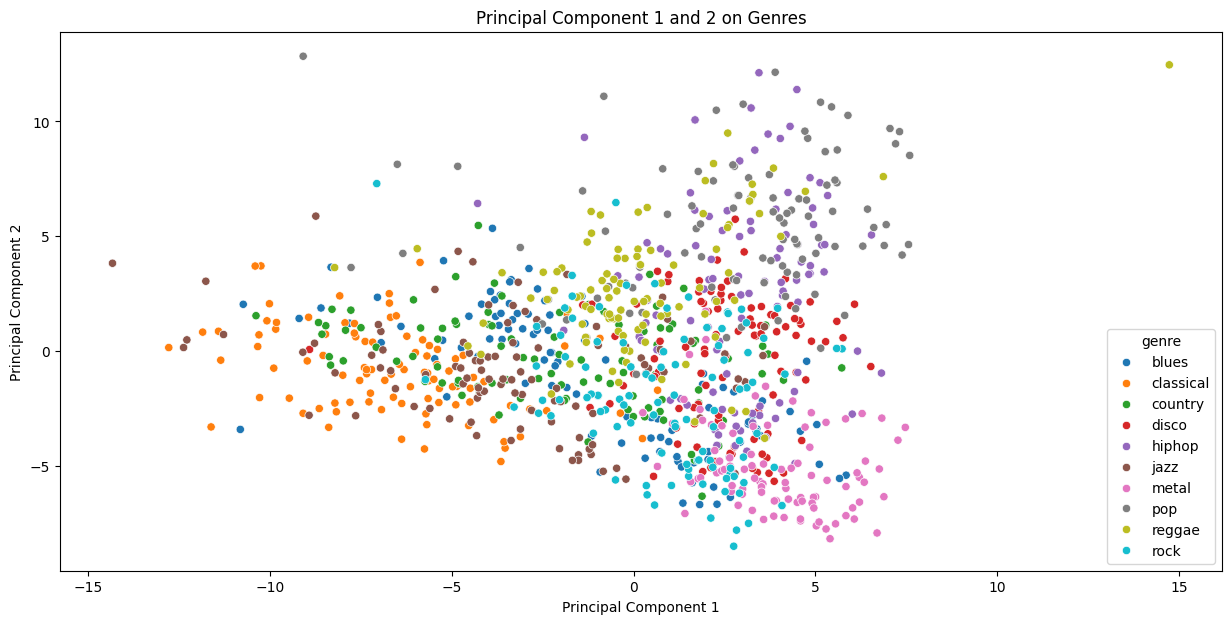

In [ ]:
# Plot the data points based on the first two principal components, colored by genre
plt.figure(figsize = (15, 7))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = data, hue = "genre");

# Set the title and labels for the plot
plt.title('Principal Component 1 and 2 on Genres')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
# The next line was commented out in the original notebook, so it remains commented out.
# plt.show()

Now we do Linear Discrminant Analysis of the data with 2 componets to visulize it

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import pandas as pd
# Load the data from the CSV file
df = pd.read_csv('/content/drive/MyDrive/more_project_data.csv')
# Remove the 'genre' and 'filename' columns to create features and target
y = df.pop('genre')
df.pop('filename')

# Scale the features using StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Perform LDA with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)
LinearDiscriminantAnalysis_components_1_2 = lda.fit_transform(df_scaled, y)
# Create a DataFrame for the LDA components
LCA_comp_df = pd.DataFrame(data = LinearDiscriminantAnalysis_components_1_2, columns = ['LDA component 1', 'LDA component 2'])

# Concatenate the LDA components with the target label
data = pd.concat([LCA_comp_df , y], axis = 1)

# Print the explained variance ratio of the LDA components
lda.explained_variance_ratio_

array([0.43911895, 0.1832617 ])

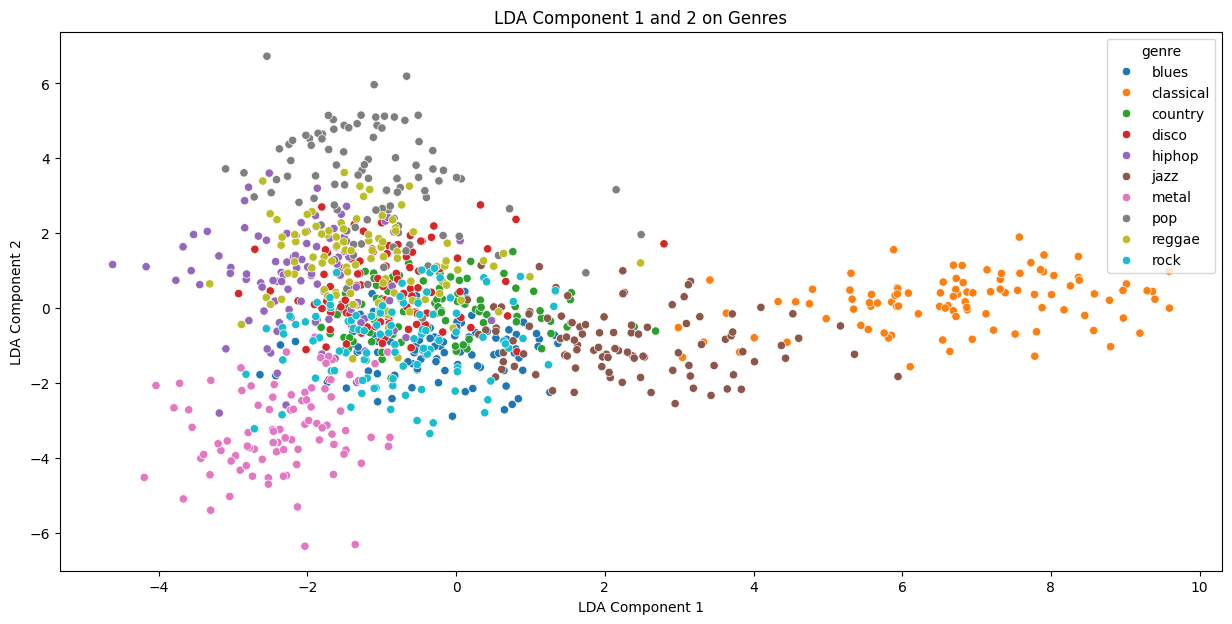

In [53]:
# Plot the data points based on the first two LDA components, colored by genre
plt.figure(figsize = (15, 7))
sns.scatterplot(x = "LDA component 1", y = "LDA component 2", data = data, hue = "genre");

# Set the title and labels for the plot
plt.title('LDA Component 1 and 2 on Genres')
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
# The next line was commented out in the original notebook, so it remains commented out.
plt.show()

We now write a function to read the csv file we created and split it into test and train sets with 20% being test and 80% being test.

After splitting standard scaler is fit on TRAIN DATA and train data is transformed.

TEST DATA IS TRANSFORMED ACCORDING TO THE STANDARD SCALER FIR OF TRAIN DATA. STANDARD SCALER IS NOT FIT AGAIN FOR TEST DATA. THE TRANSFORMATION OF TEST DATA IS BASED ON TRAIN DATA.

In [31]:
# Load the data from the CSV file
my_data = pd.read_csv('/content/drive/MyDrive/more_project_data.csv')
# Remove the 'filename' column
data = my_data.drop(['filename'],axis = 1)
# Separate the target variable 'genre'
target = data.pop('genre')

# Convert all columns in the data (features) to numeric type
for col in data.columns:
    if(not (col == 'genre')):
      data[col] = pd.to_numeric(data[col])

# Define the list of genres and encode the target labels
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
label = GENRES
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Initialize a StandardScaler
scaler = StandardScaler()
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)

# Scale and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the testing data using the scaler fitted on the training data
# SCALER IS NOT COMPUTED AGAIN
# THE EXISTING TESTING DATA IS SCALED TO BE IN LINE WITH THE SCALER FIT COMPUTED FROM TRAINING DATA
X_test = scaler.transform(X_test)

We write a function to evaluate the preformance of any model we have

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate a classification model
def model_evala(model,name, X_train, X_test):
    # Train the model on the training data
    model.fit(X_train, y_train)
    # Predict on the testing data
    y_pred = model.predict(X_test)
    # Calculate and print the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(name, 'Accuracy:',accuracy)
    # Print the classification report
    print(classification_report(y_test, y_pred,target_names=label_encoder.classes_))
    # Compute and plot the confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(12, 8))
    plt.title(f'Confusion Matrix for {name}', fontsize=12, color='red', fontweight='bold')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    # Return the accuracy score
    return accuracy

# **Logistic regression**

The first model we will try to fit is logistic regression.

**A brief discussion of workings of multinomial logistic regression is given below**

Multinomial logistic regression is adapted from logistic regression which is primarlly used for binary classification.
Logistic Regression is similar to normal regression in the sense that the the model tries to find a weight for each predictor that minimizes the loss function.But different in the sense that the outcome is **log odds** of the the two categories. Log odds is just the log of ratio of probability a sample being in one category vs other

**Binary logistic regression:**

Binary logistic regression tries to predict the log odds(log of probability of data point being in one class vs other) of a data point as a linear combination of features. The weights are chosen by the maximizing the likelyhood function by an optimization techinique like gradient ascent

**Multinomial Logistic Regression:**

How to change binary logistic regression into Multinomial logistic regression?

Pick one of the classes and baseline and fit binary logistic regression with rest of other classes and baseline. You would have no of equations equal to no of classes - 1. That is the model.

How do predict the class of a new data point.

Fit the data for all the equations. You get no of log odds = no of classes - 1. Exponentiate them to get the probability ratio with the baseline. The sum of probabilities add upto 1 thats the 10th equation. Solve there for probabilites and pick the one with the highest probability.


 Why **log odds** specifically?

 Well the linear combination of predictors would range from - infinity to + infinity. We can't fit probability because to only goes from 0 to 1. We cant fit probabilty ratio because its not negitive. Log odds can be the "link" function that connects what we are trying to predict with what we get as a linear combination of predictors.

 This is a lasy way of putting it. Why log odds specifically, there are hundereds of like functions. So that leaves the question .

Why **log odds** specifically as a link function?

Because the outcome we are trying to estimate is  Bernoulli distribution. Bernoulli distribution belongs to the exponential family. Exponential family is a family of distributions consisting of equations that can be written in a specific way and bernolli is one of them. When doing regression on exponential family the natural function to use a link function that is a subpart of that written expression . For Bernoulli it is just the log odds of one category vs other, for normal distribution it is just y, etc.

How do we adapt logistic regression to multinomial regression?

One of the outcome categories is chosen as a reference.
The model then compares each of the other categories to this reference.
For each non-reference category, the model estimates the **log-odds** of **being in that category versus the reference category** (so now its binary) as a linear combination of the predictors.
If there are K outcome categories, the model fits K-1 equations.


In [33]:
# Initialize an empty list to store the accuracies of the original models
Original_model_accuracy = []

We also use L2 regularization which helps with multicollinearity (the coorelation range from -0.80 to +0.80) and helps prevent.

L2 regularization just adds penalty term to the likelyhood function before maximizing it to find weights

Logistic Regression Accuracy: 0.8
              precision    recall  f1-score   support

       blues       0.76      0.93      0.84        14
   classical       0.91      0.91      0.91        11
     country       0.89      0.65      0.76        26
       disco       0.79      0.79      0.79        24
      hiphop       0.71      0.74      0.73        27
        jazz       0.93      0.88      0.90        16
       metal       0.81      0.94      0.87        18
         pop       0.87      0.87      0.87        23
      reggae       0.80      0.76      0.78        21
        rock       0.64      0.70      0.67        20

    accuracy                           0.80       200
   macro avg       0.81      0.82      0.81       200
weighted avg       0.81      0.80      0.80       200



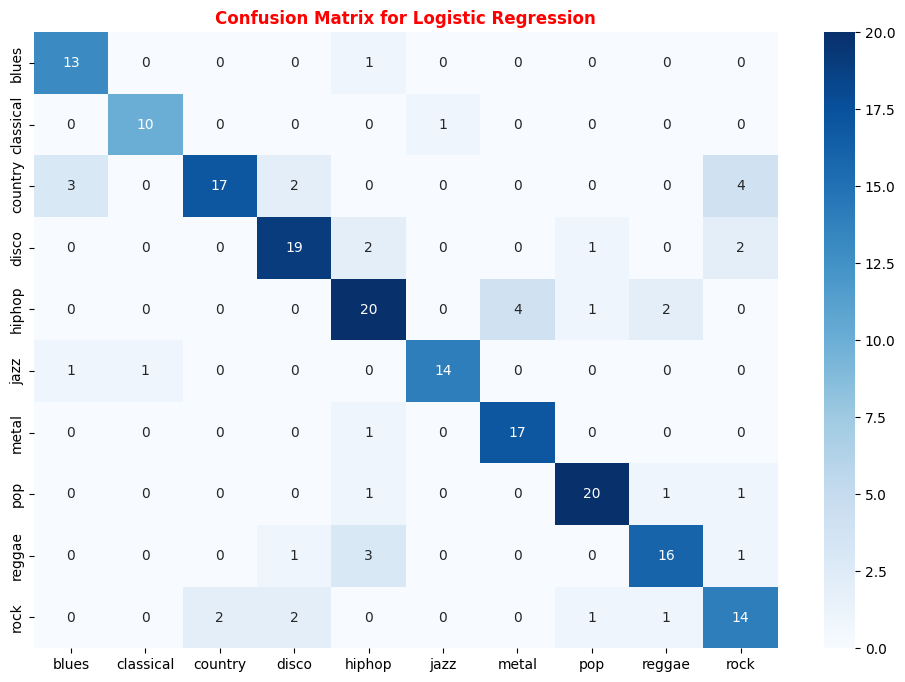

In [34]:
from sklearn.metrics import accuracy_score

# Initialize and evaluate a Logistic Regression model
lr = LogisticRegression( penalty='l2',max_iter=1000)
accuracy = model_evala(lr,'Logistic Regression', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

The Overall occuracy of the model seems to be 0.8. Another important metric while looking at the accuracy of classification of a single class in F1 score.

F1 score is calucatecd in this way.

F1 Score= 2 × [(Precision*Recall)|(Precision+Recall)]

Where Precision means of all the predicted positives, how many were actually positive.

Precision= TP|(TP+FP)

Recall means Of all the actual positives, how many did the model correctly identify

Recall= TP|(TP+FN)

All three values would be between 0 and 1 and higher the better

The model seem to be doing the best on jazz and classical and the worst on rock.

# **Support Vector Machines**

Support Vector Machines (SVMs) are primarily designed for binary classification — that is, distinguishing between two classes. FOR LINEARLY SEPERABLE binaray calssification data an SVM finds the best possible boundary (hyperplane) that separates two classes of data with the maximum margin. The margin is the distance between the closest points (support vectors) of each class to the decision boundary(the hyperplane).

How do we change algorithm for binary classification to algorithm to support multinomial data?

**Two ways**

1) One-vs-Rest (OvR): Train k binary classifiers one for each class with the rest being grouped into the second class

2)One-vs-One (OvO): Train binary classifiers for each pair of classes

**Classifing them after that is simple:**

For a new data point, run it through all classifiers.
Each classifier outputs a decision score (distance from hyperplane).
Assign the class with the highest decision score (most confident prediction).

Support Vector Machine Accuracy: 0.725
              precision    recall  f1-score   support

       blues       0.75      0.86      0.80        14
   classical       0.61      1.00      0.76        11
     country       0.79      0.58      0.67        26
       disco       0.73      0.67      0.70        24
      hiphop       0.86      0.67      0.75        27
        jazz       0.86      0.75      0.80        16
       metal       0.74      0.94      0.83        18
         pop       0.89      0.74      0.81        23
      reggae       0.73      0.76      0.74        21
        rock       0.42      0.55      0.48        20

    accuracy                           0.72       200
   macro avg       0.74      0.75      0.73       200
weighted avg       0.75      0.72      0.73       200



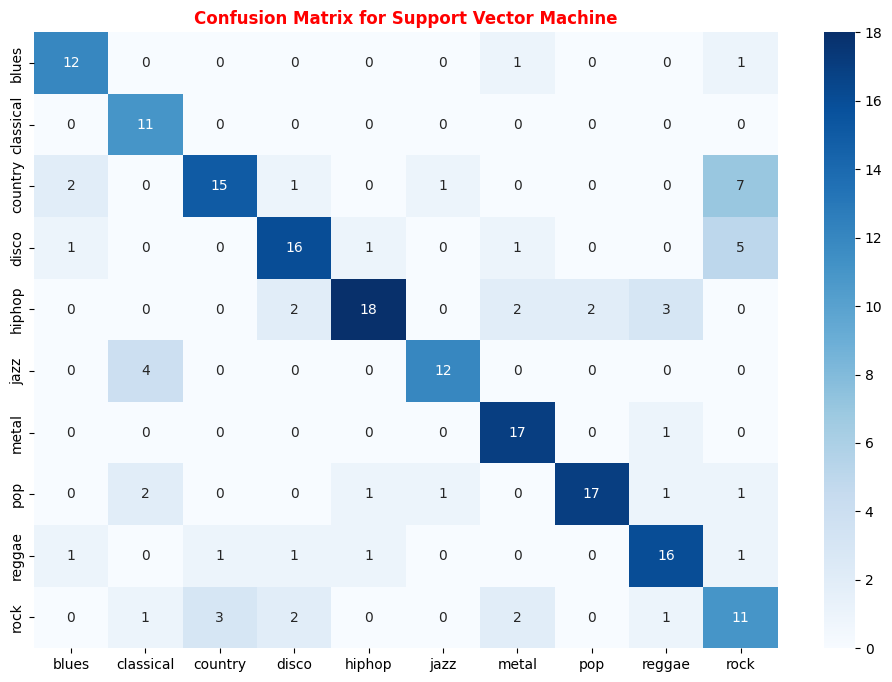

In [35]:
# Initialize and evaluate a Support Vector Machine (SVC) model with 'one-vs-rest' strategy
from sklearn.svm import SVC
svm = SVC(decision_function_shape="ovr")
accuracy = model_evala(svm,'Support Vector Machine', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

Support Vector Machine Accuracy: 0.725
              precision    recall  f1-score   support

       blues       0.75      0.86      0.80        14
   classical       0.61      1.00      0.76        11
     country       0.79      0.58      0.67        26
       disco       0.73      0.67      0.70        24
      hiphop       0.86      0.67      0.75        27
        jazz       0.86      0.75      0.80        16
       metal       0.74      0.94      0.83        18
         pop       0.89      0.74      0.81        23
      reggae       0.73      0.76      0.74        21
        rock       0.42      0.55      0.48        20

    accuracy                           0.72       200
   macro avg       0.74      0.75      0.73       200
weighted avg       0.75      0.72      0.73       200



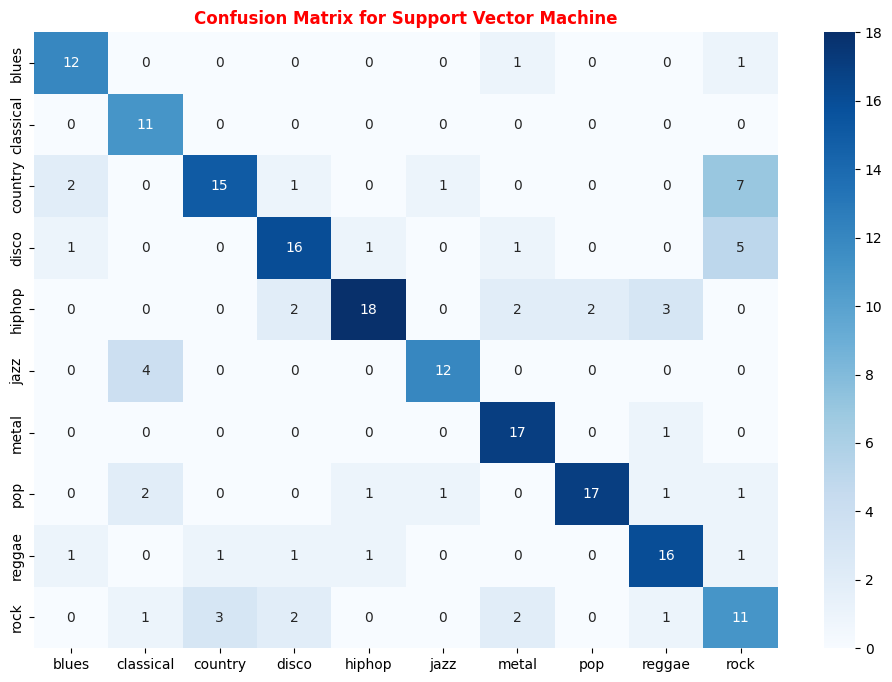

In [36]:
# Initialize and evaluate a Support Vector Machine (SVC) model with 'one-vs-one' strategy
from sklearn.svm import SVC
svm = SVC(decision_function_shape="ovo")
# Evaluate the model (accuracy is ignored as it's the same as ovr for this dataset)
ignore = model_evala(svm,'Support Vector Machine', X_train, X_test)
#we ignore it because we dont fit both of them after we do dimanationalty reduction

**Discussion**

The final accuracy of both one vs one svm and one vs rest csv seems to be the same, the individual F1 scores seem to be similar. The worst performing class seems to the same class as before, Rock. The best performinf classes seem to be jazz, blues, metal and pop.

One outlier in the accuracy metrics is the recall score of classical which seems to be close to 1, so the model always seems to identify classicvals correctly but the precision seems to low, infact the second lowest. So the model classifies a lot of songs that arnt classical as classical. This seems to occur **without** **class imbalance**.
 The confusion matrix shows that not a lot of rock are classified as clssical.The model mostly confuses classical with jazz and pop, some of the best performing classifiers

# **Stochastic gradient descent**

Stochastic gradient descent is not a clasification technique but merely an optimization technique. It is a way to train a model, instead of using the entire dataset to calculate the gradient like gradient descent does, SGD uses a single randomly selected data point (or a small batch) at each iteration. This makes it computationally efficient, especially for large datasets.

Stochastic gradient descent Classifier uses Stochastic gradient descent



The class SGDClassifier used in this model implements a SGD but tries to classify data based on hindge function, hinge would be something close to SVM and the other loss function we would use is log_loss which would be something close to Logistic Regression

Stochastic Gradient Descent SVM Accuracy: 0.77
              precision    recall  f1-score   support

       blues       0.71      0.86      0.77        14
   classical       0.85      1.00      0.92        11
     country       0.94      0.62      0.74        26
       disco       0.76      0.92      0.83        24
      hiphop       0.79      0.70      0.75        27
        jazz       0.82      0.88      0.85        16
       metal       0.74      0.94      0.83        18
         pop       0.94      0.70      0.80        23
      reggae       0.74      0.81      0.77        21
        rock       0.50      0.50      0.50        20

    accuracy                           0.77       200
   macro avg       0.78      0.79      0.78       200
weighted avg       0.78      0.77      0.77       200



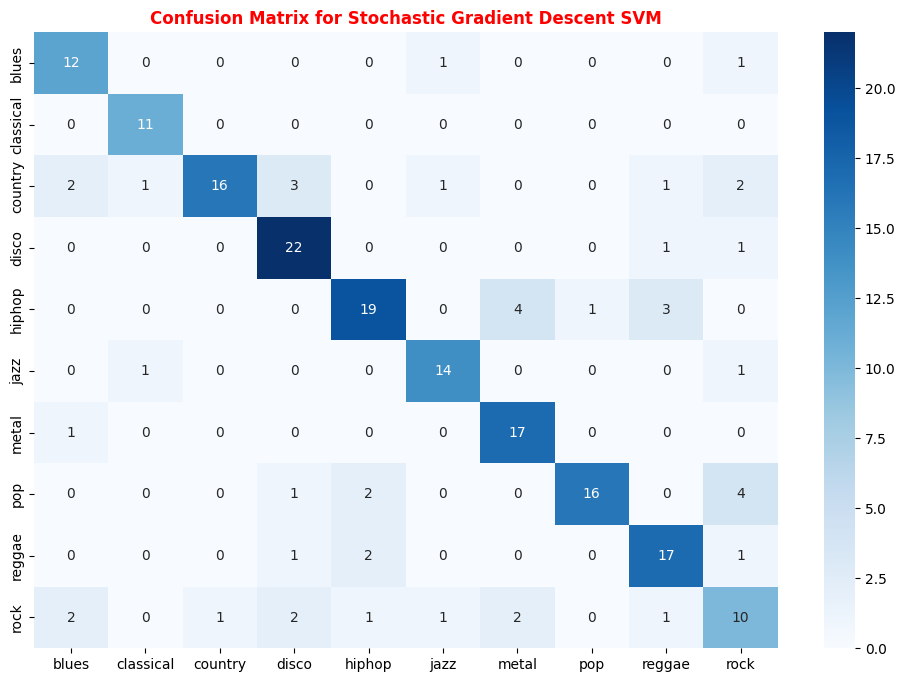

In [37]:
from sklearn.linear_model import SGDClassifier
# Initialize and evaluate a Stochastic Gradient Descent (SGD) classifier with 'hinge' loss (SVM-like)
sgd = SGDClassifier(max_iter=4000,loss='hinge')
accuracy = model_evala(sgd,'Stochastic Gradient Descent SVM', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

**DISCUSSION**

Using SGD in conjuntion with SVM seem to improve the accuracy of SVM. It increses the recally score of classical significantly fro  0.61 to 0.92 and the overall F1 score increses consequently. The accuracy scores of the rest change but not as drastically.

SGD could help increase the accuracy and could prevent what looks like overfit of of Classical.

Stochastic Gradient Descent multinomial regression Accuracy: 0.745
              precision    recall  f1-score   support

       blues       0.65      0.93      0.76        14
   classical       0.92      1.00      0.96        11
     country       0.78      0.54      0.64        26
       disco       0.72      0.88      0.79        24
      hiphop       0.67      0.67      0.67        27
        jazz       0.93      0.88      0.90        16
       metal       0.85      0.94      0.89        18
         pop       1.00      0.74      0.85        23
      reggae       0.67      0.67      0.67        21
        rock       0.48      0.50      0.49        20

    accuracy                           0.74       200
   macro avg       0.77      0.77      0.76       200
weighted avg       0.76      0.74      0.74       200



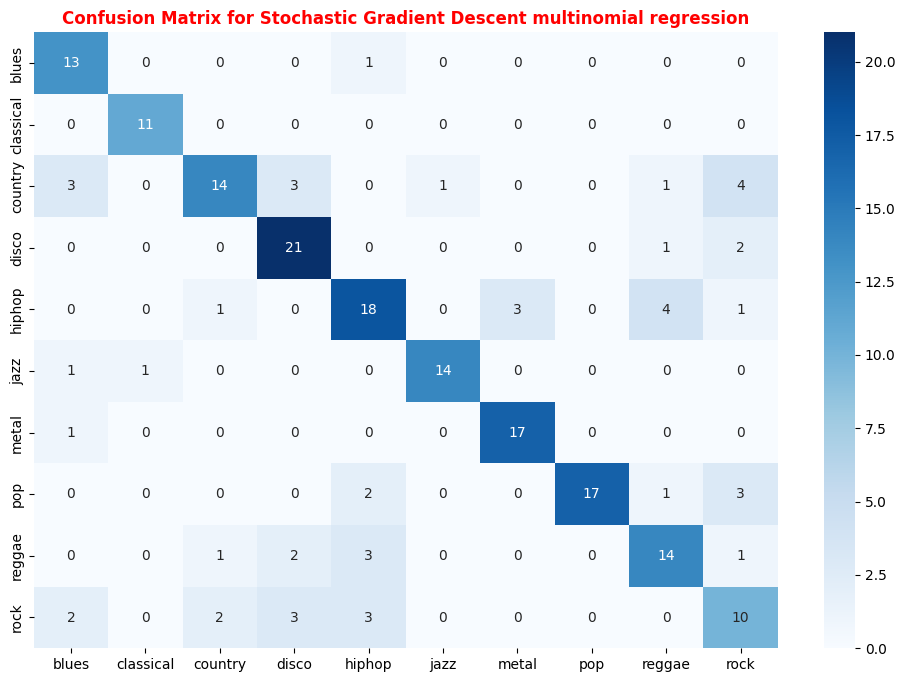

In [38]:
from sklearn.linear_model import SGDClassifier
# Initialize and evaluate a Stochastic Gradient Descent (SGD) classifier with 'log_loss' (Logistic Regression-like)
model = SGDClassifier(loss='log_loss')
accuracy = model_evala(model,'Stochastic Gradient Descent multinomial regression', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

**DISCUSSION**

SGD in conjunction with multionmial regression seem to have a significant decline in the accuracy. from 0.80 to 0.72.  This is probably because of loss of presision and recall in most classes without upside like before.

# **Naive Bayes**

Naive Bayes is a probabilistic machine learning algorithm based on applying Bayes' Theorem with a strong (naive) assumption that all features are independent of each other given the class label.

Bayes’ Theorem
Bayes' Theorem calculates the probability of a hypothesis (class) given some evidence (features):

𝑃(Class∣Features)=(𝑃(Features∣Class)×𝑃(Class))|P(Features)

P(Class∣Features) is the posterior probability: probability of the class given the features.


P(Features∣Class) is the likelihood: probability of features given the class.


P(Class) is the prior: how likely the class is before seeing features.


P(Features) is the evidence: probability of features (usually ignored for classification since it's the same for all classes).

Why "Naive"?
The algorithm assumes that features are independent of each other, which is often not true in real life ,this seems to be the case here leading to a low performance



Gaussian Naive Bayes Accuracy: 0.58
              precision    recall  f1-score   support

       blues       0.58      0.50      0.54        14
   classical       0.56      0.91      0.69        11
     country       0.62      0.38      0.48        26
       disco       0.56      0.62      0.59        24
      hiphop       0.64      0.67      0.65        27
        jazz       0.75      0.56      0.64        16
       metal       0.42      0.89      0.57        18
         pop       0.88      0.61      0.72        23
      reggae       0.79      0.52      0.63        21
        rock       0.32      0.30      0.31        20

    accuracy                           0.58       200
   macro avg       0.61      0.60      0.58       200
weighted avg       0.62      0.58      0.58       200



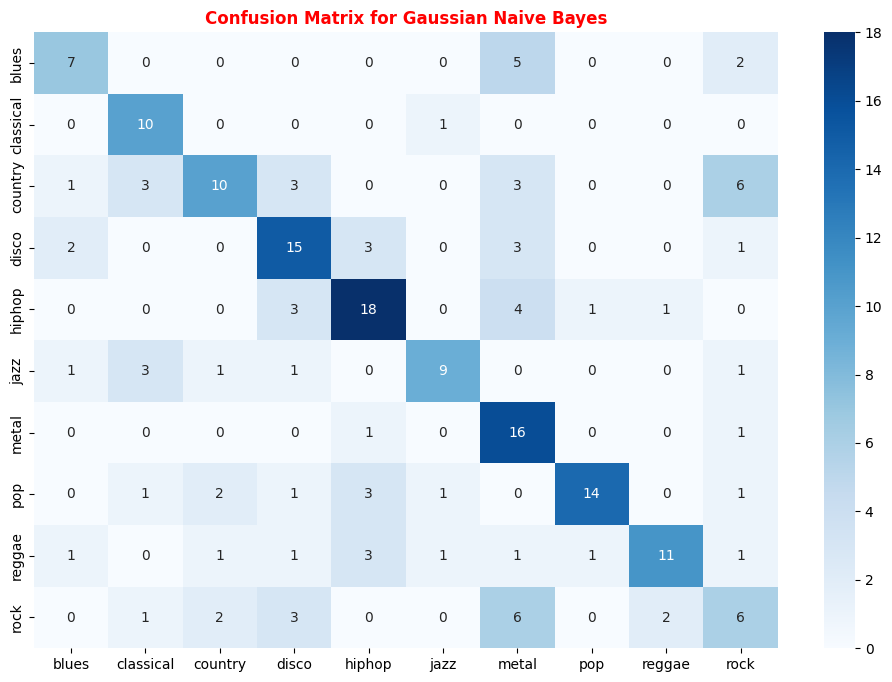

In [39]:
from sklearn.naive_bayes import GaussianNB
# Initialize and evaluate a Gaussian Naive Bayes model
nb = GaussianNB()
accuracy = model_evala(nb,'Gaussian Naive Bayes', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

**DISCUSSION:**

The overall accuracy seems to be 0.58, the worst performing class seems to thr same as before rock and the best preforming classes seem to be classical, hiphop and jazz

This bad performance is because the features are not really independent as shown by the covariance matrix.

How to improve it?
We could do dimentonility reduction (PCA) which will reduce the features into smaller no of UNCORRELATED (might not be independent) features.

We could do another dimentanility reduction (LDA) where the features are usually less correlated but "seperates" out the classes better.


**K Nearest Neighbours**

The K-Nearest Neighbors (KNN) algorithm classifies a new data point by finding the 'k' closest data points in a training set and assigning the new point to the class that is most common among those neighbors.

So first you choose K, then you calucate distances between the given data point and all the points in the training set, choose the first K closest points and assign the class of the given data point as the class that repeats the most in the first K points.

An adavantage of K nearest neighbours is that it dosent assume any underlying probability distribution of any features. This makes it more flexiable.


K-Nearest Neighbors Accuracy: 0.715
              precision    recall  f1-score   support

       blues       0.65      0.93      0.76        14
   classical       0.67      0.91      0.77        11
     country       0.88      0.58      0.70        26
       disco       0.54      0.92      0.68        24
      hiphop       1.00      0.48      0.65        27
        jazz       0.71      0.75      0.73        16
       metal       0.77      0.94      0.85        18
         pop       0.79      0.83      0.81        23
      reggae       0.74      0.67      0.70        21
        rock       0.67      0.40      0.50        20

    accuracy                           0.71       200
   macro avg       0.74      0.74      0.71       200
weighted avg       0.76      0.71      0.71       200



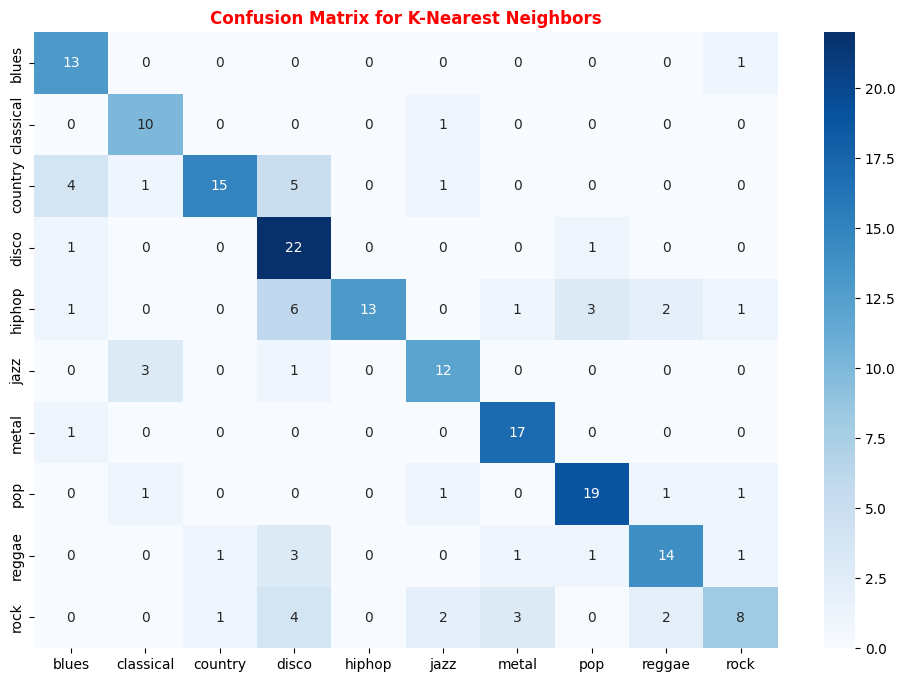

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and evaluate a K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=23)
accuracy = model_evala(knn,'K-Nearest Neighbors', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

Some code to plot how the accuracy of K nerigest neighbours changes as the no of neighbours to consider changes

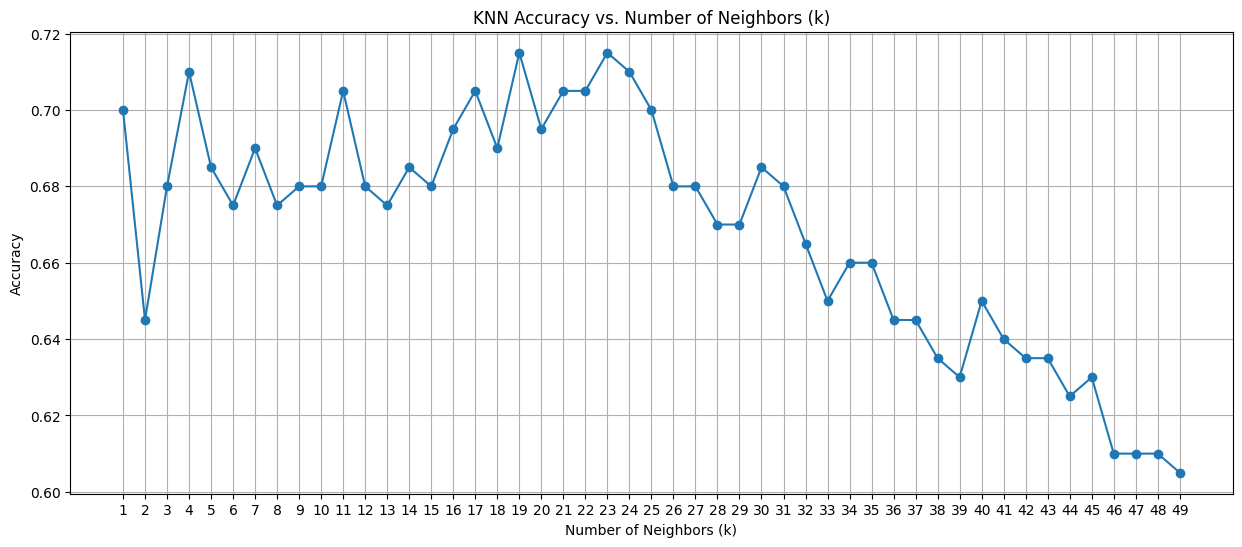

In [41]:
# Explore the impact of the number of neighbors (k) on KNN accuracy
k_values = range(1, 50)  # Test k from 1 to 50
accuracy_scores = []

# Train and evaluate KNN for each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy vs. number of neighbors
plt.figure(figsize=(15, 6))
plt.plot(k_values, accuracy_scores,marker = 'o')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

**DISCUSSION**

A good rule of thumb for choosing the k in kkn is sqrt(n) where n is the number of data points, which for this data is 31 but 23 seems to work better.

K = 4 even though its close to 23 in terms of accuracy should not be chosen because the number of neighbours is very low and probably result in overfit when generalizing.

If you keep increasing K it could lead to underfit because the model ignores the features. For example if you choose k to be N (the no of data points) every point is included and all the classes appear and the model would ignore all the features and just choose the class with highest frequency ignoring all the features.

Like a lot of models before the worst performing model seems to be rock whie the bst seems to be metal

**Decision tree**

(We made decision tree just for explination of other ensamble learning meathods but will not be used in the end.)

A decision tree is a flowchart-like structure.Internal nodes represent feature-based decisions (e.g., "Is Tempo >90?")Branches represent the outcomes of those decisions (yes/no or true/false) Leaf nodes represent the predicted class or value. There are many nodes for features and the flow chart is followed until a classification is reached.

The decision tree is trained by recursively splitting the "best feature" chosen by the algorithm and recursing until a stopping condition is met.

Decision trees are not the best models themselves but a lot of decision trees can be combined to build a very strong model, which we will discuss later. We include decision tree in the report because the models we disuss later are built on decision trees.

Decision Tree Accuracy: 0.49
              precision    recall  f1-score   support

       blues       0.40      0.71      0.51        14
   classical       0.47      0.82      0.60        11
     country       0.50      0.27      0.35        26
       disco       0.52      0.46      0.49        24
      hiphop       0.55      0.44      0.49        27
        jazz       0.53      0.56      0.55        16
       metal       0.60      0.67      0.63        18
         pop       0.73      0.48      0.58        23
      reggae       0.38      0.52      0.44        21
        rock       0.33      0.30      0.32        20

    accuracy                           0.49       200
   macro avg       0.50      0.52      0.50       200
weighted avg       0.51      0.49      0.48       200



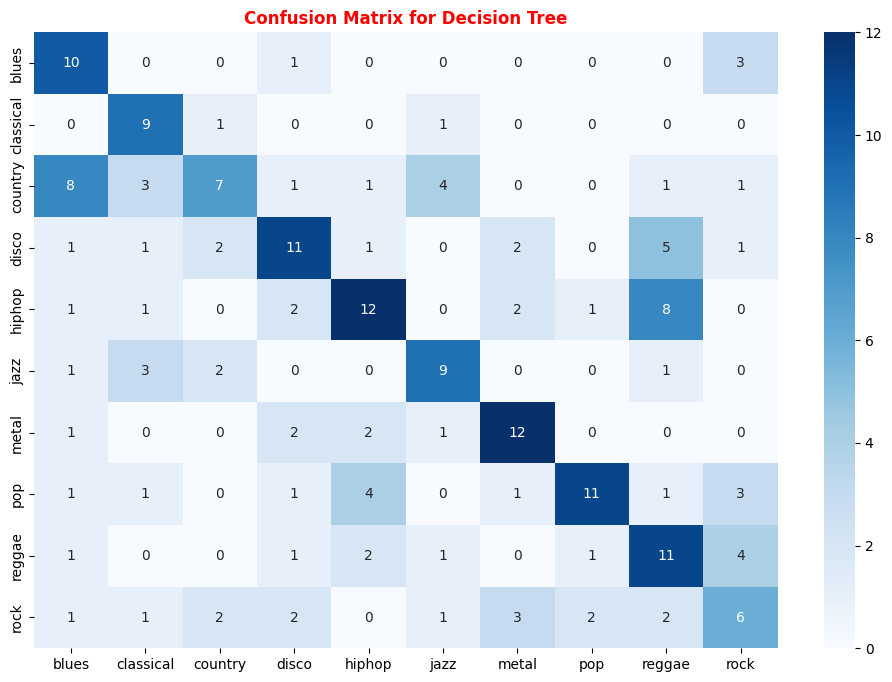

In [42]:
from sklearn.tree import DecisionTreeClassifier
# Initialize and evaluate a Decision Tree Classifier
dtc = DecisionTreeClassifier()
# Evaluate the model (accuracy is ignored for further analysis)
ignore = model_evala(dtc,'Decision Tree', X_train, X_test) #decision tree was made just for higher model explination purposes

We will now visuvilize the tree we just made even though the no of predictors make it hard to read but the point is not to read but to visualize

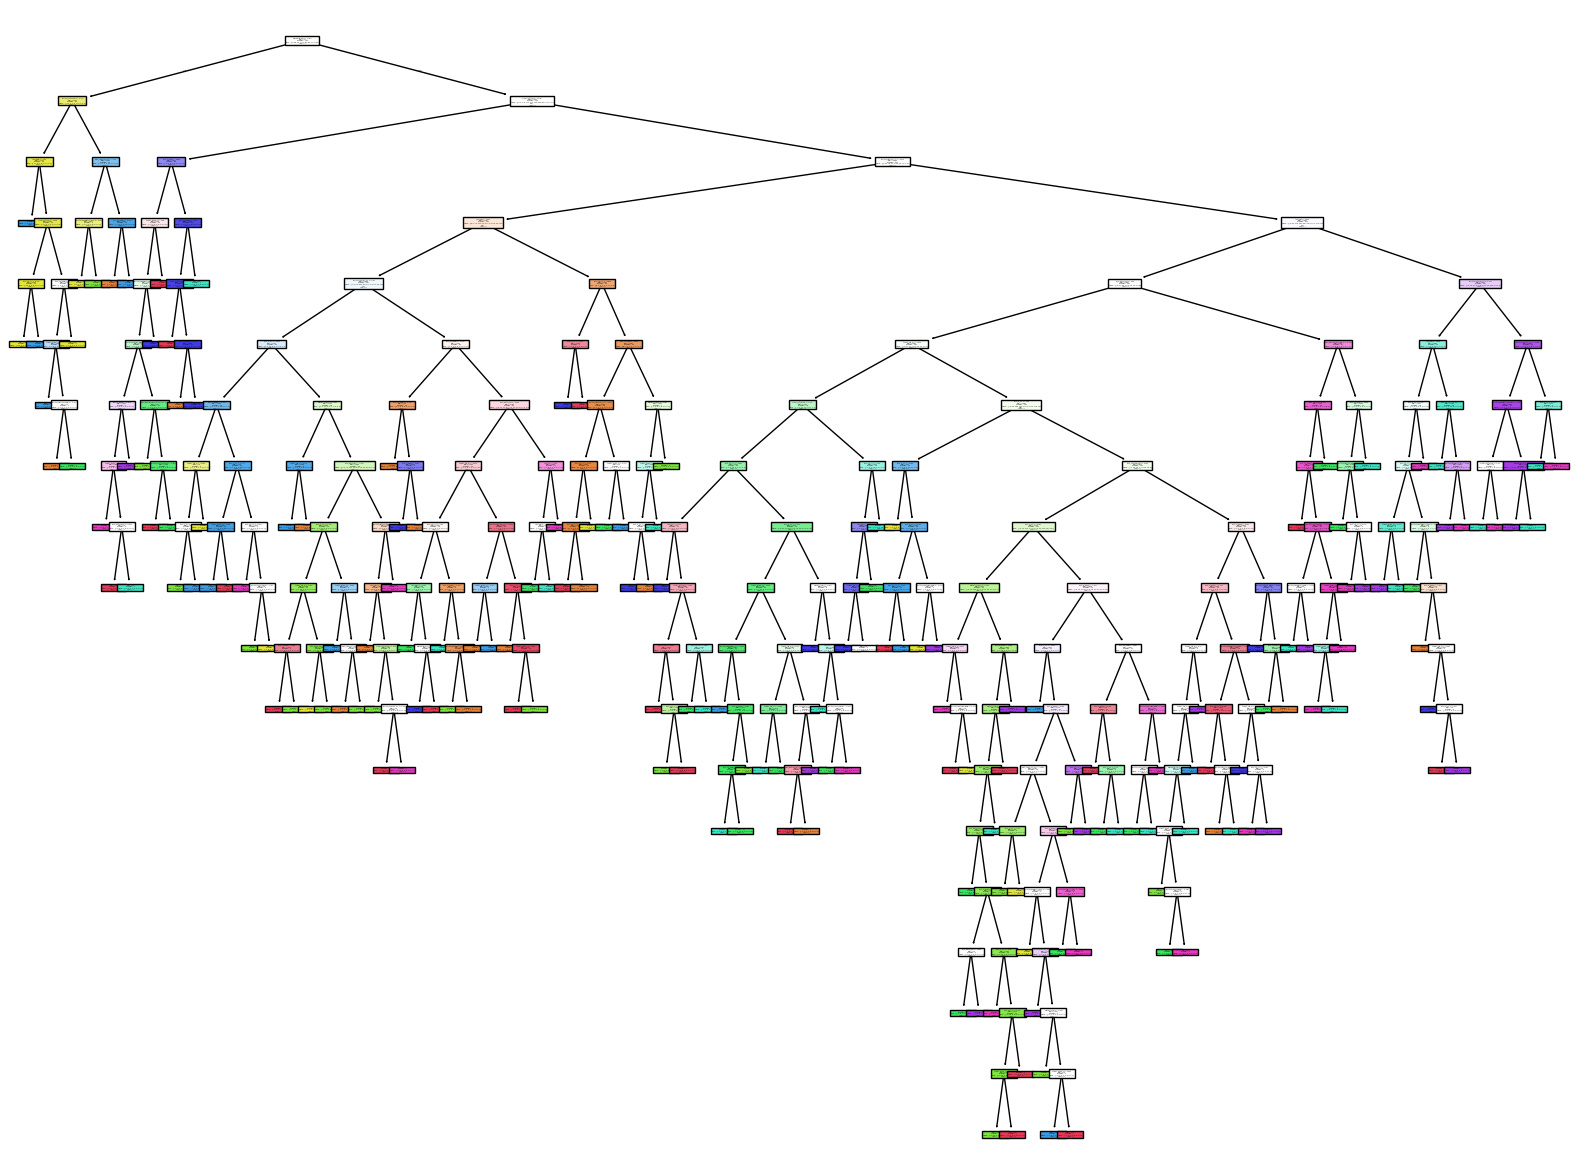

In [43]:
from sklearn import tree
# Visualize the trained Decision Tree
plt.figure(figsize=(20,15))
tree.plot_tree(dtc, filled=True, feature_names=data.columns, class_names=[str(c) for c in dtc.classes_])
plt.show()

**ENSAMBLE LEARNING**

Ensemble learning is a method where we use many small models instead of just one. Each of these models may not be very strong on its own, but when we put their results together, we get a better and more accurate answer

# **Extreme Gradient Boosting**

Extreme Gradient Boosting(XBGr) is a type of ensamble learning.

So what models does extreme gradient boosting ensamble?
Decision tree.

Extreme Gradient boosing trains a number of these trees iteratively based one the gradient of loss of prediction of previous trees.

Extreme gradient boosting predicts the output of a new data point by taking the weighted sum of all the trees that are built.



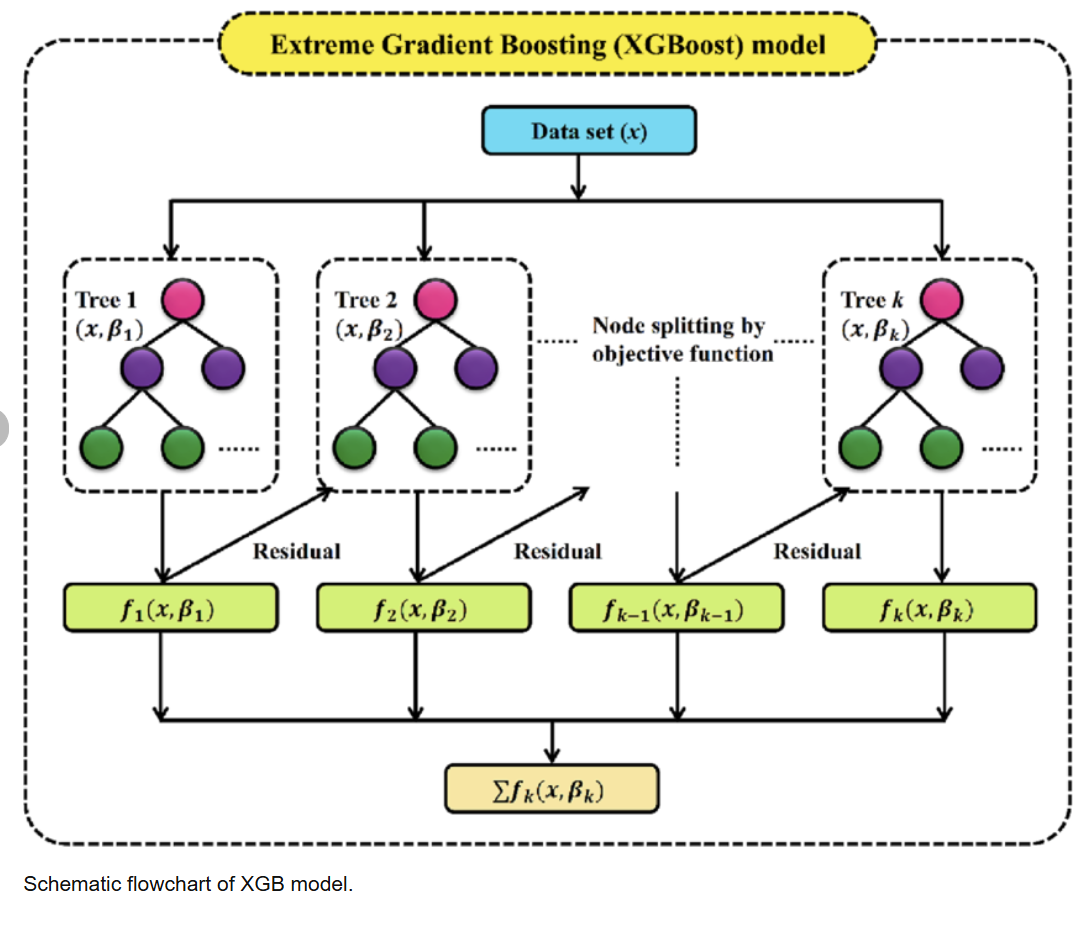

Image taken from https://www.researchgate.net/figure/Schematic-flowchart-of-XGB-model_fig1_371379918

XGBoost Accuracy: 0.715
              precision    recall  f1-score   support

       blues       0.58      0.79      0.67        14
   classical       0.83      0.91      0.87        11
     country       0.67      0.62      0.64        26
       disco       0.75      0.50      0.60        24
      hiphop       0.66      0.70      0.68        27
        jazz       0.81      0.81      0.81        16
       metal       0.76      0.89      0.82        18
         pop       0.89      0.74      0.81        23
      reggae       0.70      0.76      0.73        21
        rock       0.62      0.65      0.63        20

    accuracy                           0.71       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.72      0.71      0.71       200



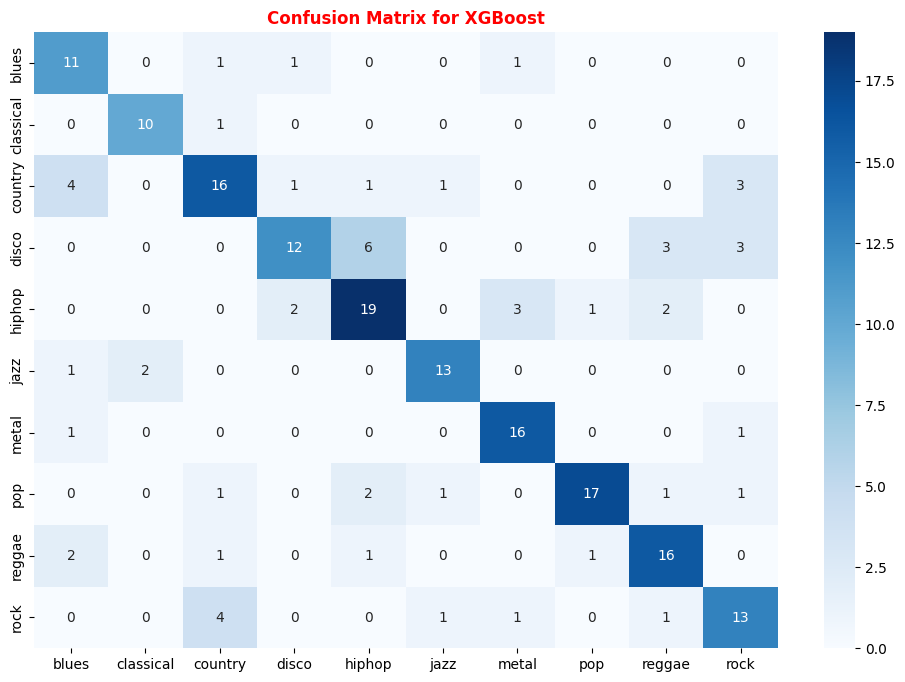

In [44]:
from xgboost import XGBClassifier
# Initialize and evaluate an XGBoost classifier
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
accuracy = model_evala(xgb,'XGBoost', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

**DISCUSSION**

Rock seems to be the second worst performer behind disco. Classical seems ti be the best performer.



# **Random Forest Classifier**

Random Forest Classifier is an Ensamble learning meathod like Extreme gradient boosting and it ensambles decision trees. The part where it differs is the way it creates the trees.

Each tree is trained on a random subset of the data. At each split in a tree, it considers a random subset of features (not all features) and the algorithm picks the best feature among the random subset.

Random Forest Accuracy: 0.705
              precision    recall  f1-score   support

       blues       0.59      0.93      0.72        14
   classical       0.77      0.91      0.83        11
     country       0.68      0.50      0.58        26
       disco       0.79      0.62      0.70        24
      hiphop       0.69      0.74      0.71        27
        jazz       0.65      0.69      0.67        16
       metal       0.81      0.94      0.87        18
         pop       0.79      0.65      0.71        23
      reggae       0.67      0.67      0.67        21
        rock       0.65      0.65      0.65        20

    accuracy                           0.70       200
   macro avg       0.71      0.73      0.71       200
weighted avg       0.71      0.70      0.70       200



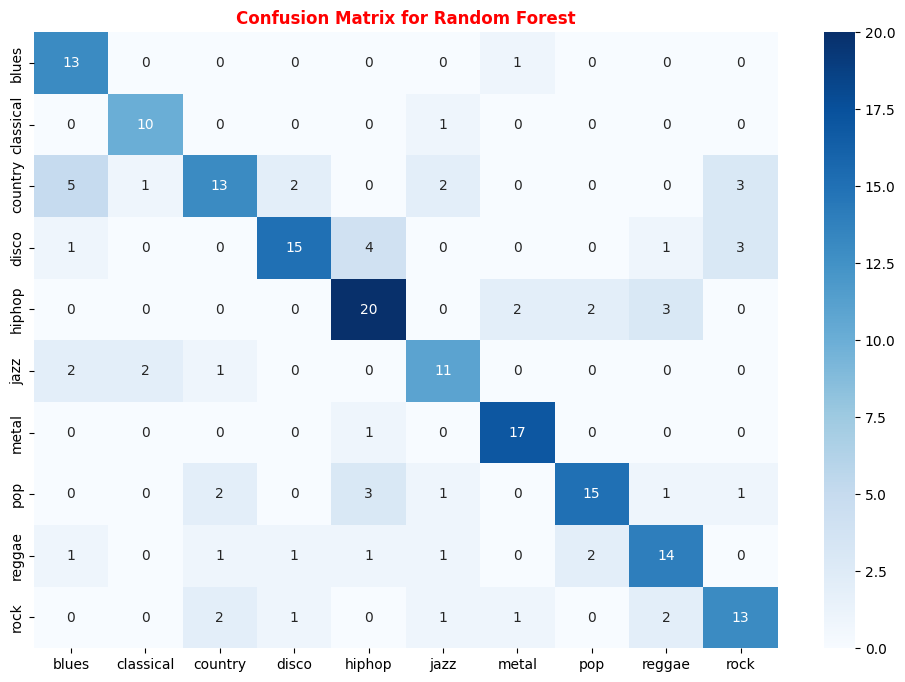

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and evaluate a Random Forest Classifier
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
accuracy = model_evala(rforest,'Random Forest', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

**Discussion:**

Rock seems to be the second best worst behind country. Metal seems to be the best performer.


# **Multi layer perceptron classifer**

An MLP Classifier, or Multi-Layer Perceptron classifier, is a type of neural network used for classification tasks. The MLP classifer we use has 10 layers of 5050 neurons each and the last layer has 10 output neurons.

MLP Neural Network Accuracy: 0.79
              precision    recall  f1-score   support

       blues       1.00      0.86      0.92        14
   classical       0.73      1.00      0.85        11
     country       0.86      0.69      0.77        26
       disco       0.77      0.83      0.80        24
      hiphop       0.83      0.70      0.76        27
        jazz       0.88      0.94      0.91        16
       metal       0.77      0.94      0.85        18
         pop       0.85      0.74      0.79        23
      reggae       0.74      0.81      0.77        21
        rock       0.57      0.60      0.59        20

    accuracy                           0.79       200
   macro avg       0.80      0.81      0.80       200
weighted avg       0.80      0.79      0.79       200



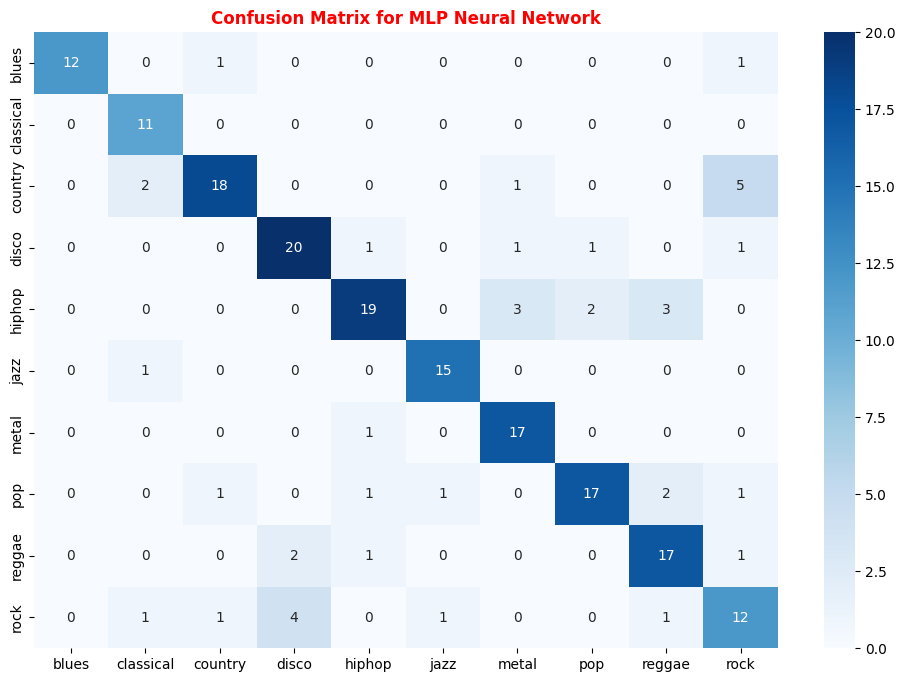

In [46]:
from sklearn.neural_network import MLPClassifier

# Using a Multi-layer Perceptron (Neural Network) Classifier
nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5050, 10), random_state=1)
# Evaluate the model using the defined evaluation function
accuracy = model_evala(nn,'MLP Neural Network', X_train, X_test)
# Append the accuracy to the list
Original_model_accuracy.append(accuracy)

# **PRINCIPAL COMPONENT ANALYSIS**

PCA is used for dimensionality reduction, feature extraction, and data visualization.
PCA finds new axes (called principal components) that are orthogonal (uncorrelated), capture the maximum variance in the data.
We can choose some components that explain a percent of the variance.
A good rule of thumb is to choose between 0.7 and 0.8 precent of variance.
In the below example we choose variance to be 0.8

In [47]:
from sklearn.decomposition import PCA
# Perform PCA for dimensionality reduction, retaining 80% of variance
pca = PCA(n_components=0.8)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

# Initialize an empty list to store accuracies after PCA
PCA_Accuracy = []

PCA Logistic Regression Accuracy: 0.67
              precision    recall  f1-score   support

       blues       0.50      0.64      0.56        14
   classical       0.92      1.00      0.96        11
     country       0.73      0.62      0.67        26
       disco       0.50      0.38      0.43        24
      hiphop       0.60      0.56      0.58        27
        jazz       0.82      0.88      0.85        16
       metal       0.60      0.83      0.70        18
         pop       0.81      0.74      0.77        23
      reggae       0.73      0.76      0.74        21
        rock       0.60      0.60      0.60        20

    accuracy                           0.67       200
   macro avg       0.68      0.70      0.69       200
weighted avg       0.67      0.67      0.67       200

PCA Support Vector Machine Accuracy: 0.685
              precision    recall  f1-score   support

       blues       0.59      0.71      0.65        14
   classical       0.69      1.00      0.81       

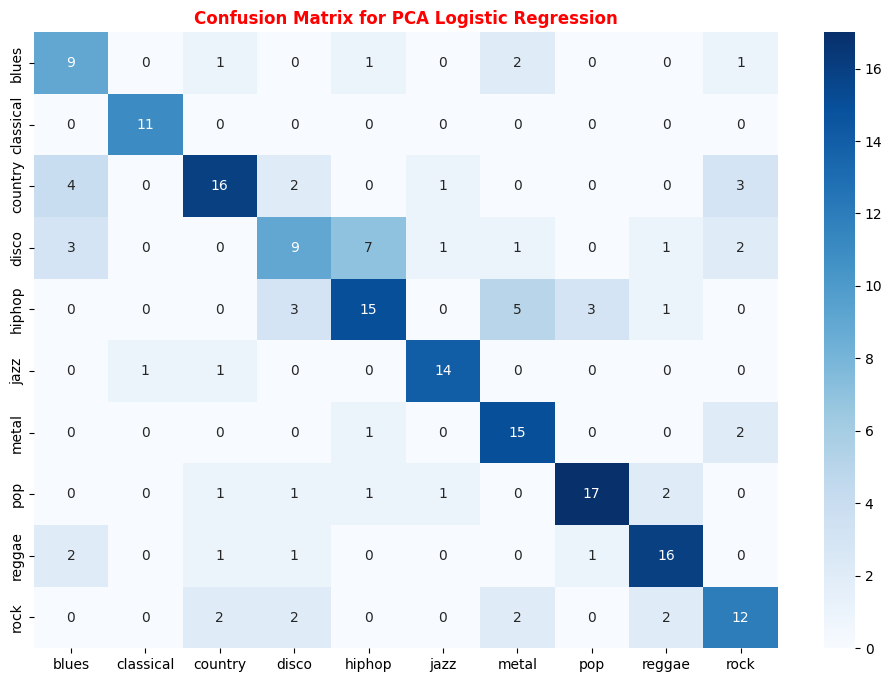

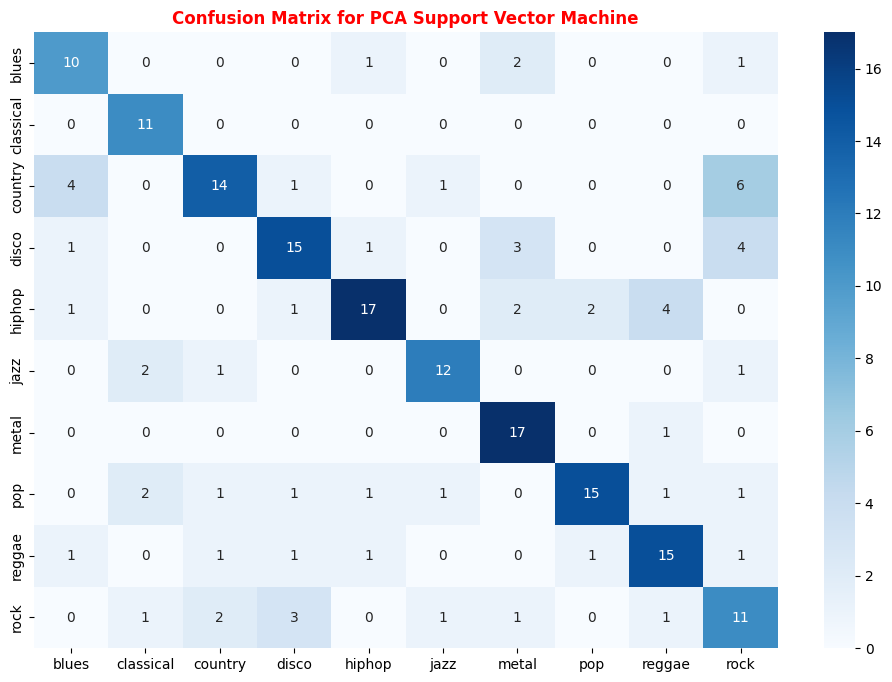

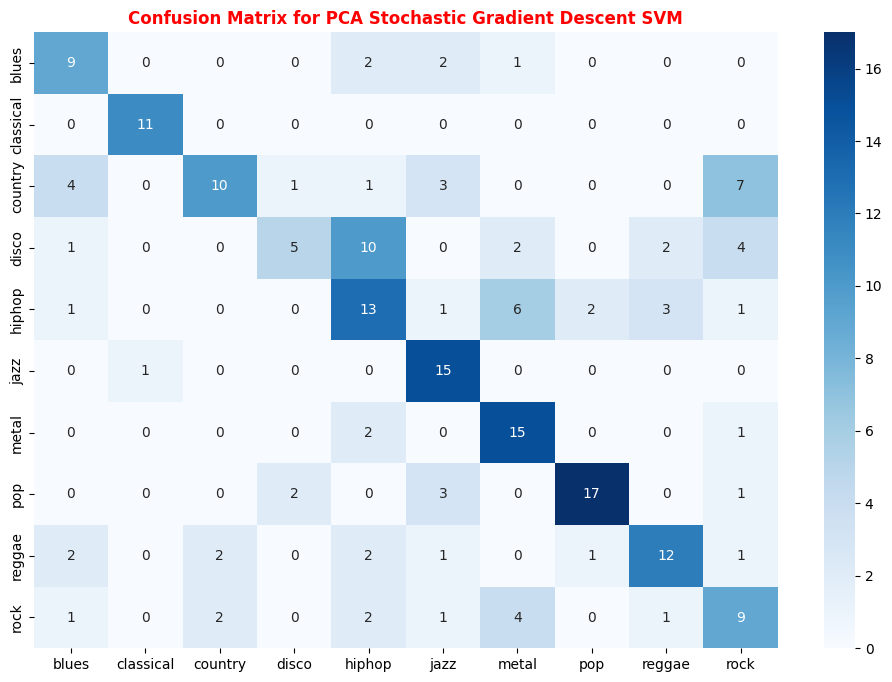

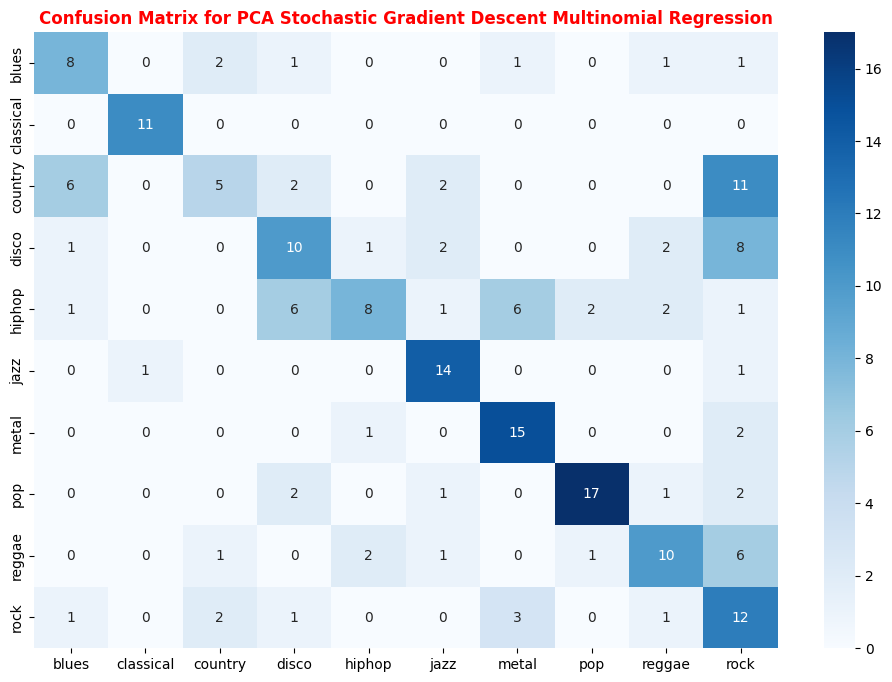

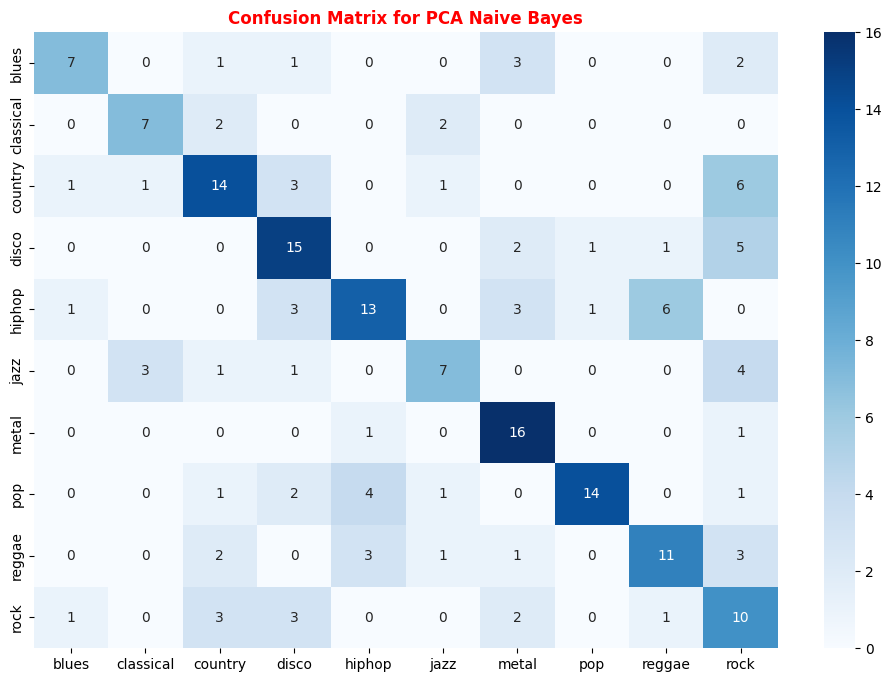

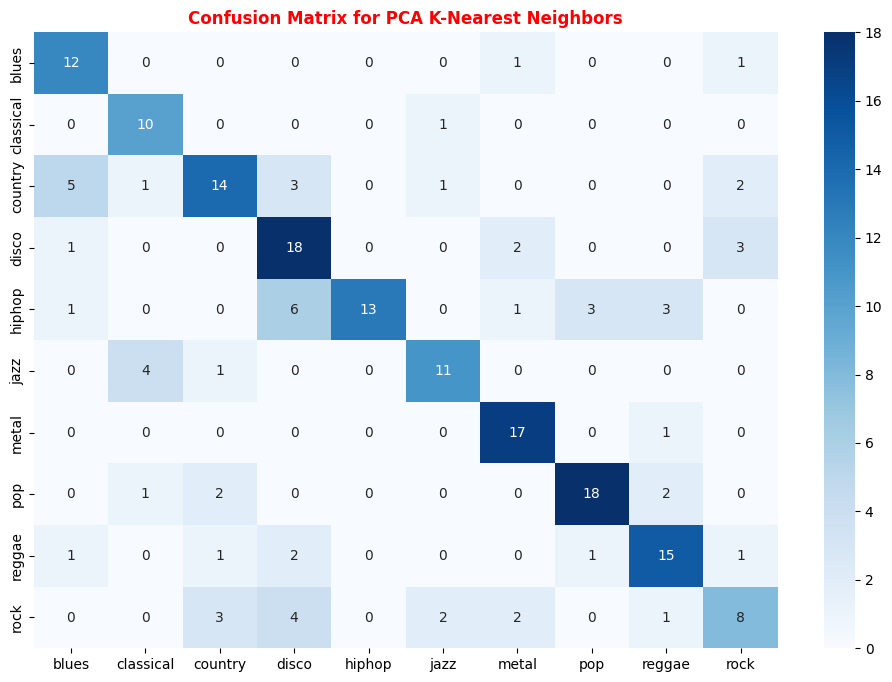

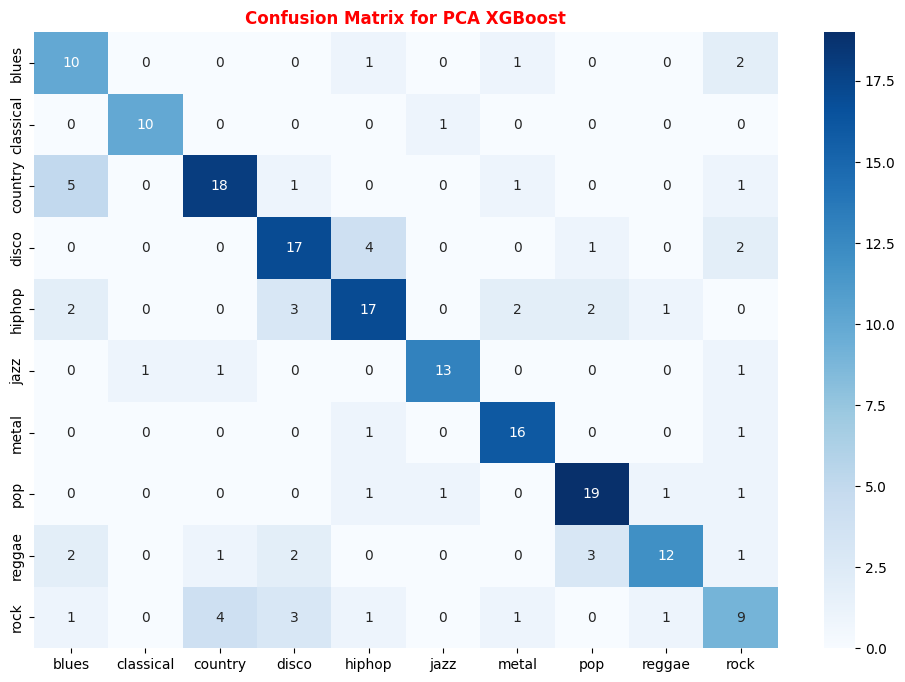

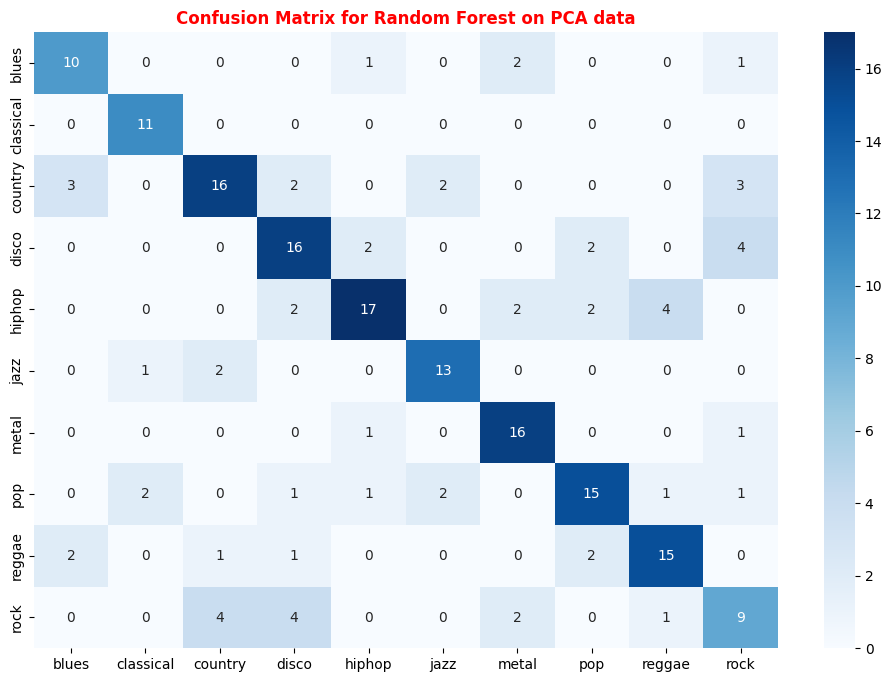

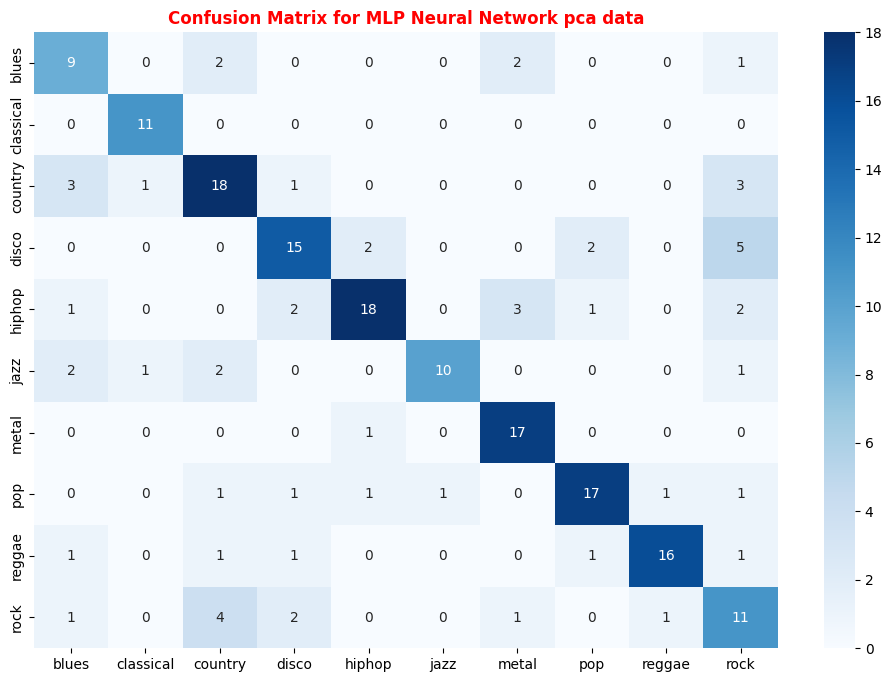

In [48]:
# Clear the PCA_Accuracy list before appending new values
PCA_Accuracy = []

# Evaluating various models after applying PCA

# Logistic Regression on PCA data
lr = LogisticRegression( penalty='l2',max_iter=1000)
accuracy = model_evala(lr,'PCA Logistic Regression', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)


# Support Vector Machine on PCA data
svm = SVC(decision_function_shape="ovo")
accuracy = model_evala(svm,'PCA Support Vector Machine', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

# Stochastic Gradient Descent SVM on PCA data
sgd = SGDClassifier(max_iter=7000,loss = 'log_loss', random_state=0)
accuracy = model_evala(sgd,'PCA Stochastic Gradient Descent SVM', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

# Stochastic Gradient Descent Multinomial regression on PCA data
sgd = SGDClassifier(max_iter=7000, random_state=0)
accuracy = model_evala(sgd,'PCA Stochastic Gradient Descent Multinomial Regression', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

# Gaussian Naive Bayes on PCA data
nb = GaussianNB()
accuracy = model_evala(nb,'PCA Naive Bayes', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

# K-Nearest Neighbors on PCA data
knn = KNeighborsClassifier(n_neighbors=23)
accuracy = model_evala(knn,'PCA K-Nearest Neighbors', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

# XGBoost on PCA data
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
accuracy = model_evala(xgb,'PCA XGBoost', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

# Random Forest on PCA data
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
accuracy = model_evala(rforest,'Random Forest on PCA data', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)


# Neural Network on PCA data
nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5050, 10), random_state=1)
accuracy = model_evala(nn,'MLP Neural Network pca data', pca_X_train, pca_X_test)
PCA_Accuracy.append(accuracy)

Now we make a table comparing the orginal accuracies of the models vs accuracies on pca data

In [49]:
# Dictionary storing the accuracies of different models and dimensionality reduction techniques
data = {
    'Models' : [
    'Logistic Regression',
    'Support Vector Machine',
    'Stochastic Gradient Descent(hinge)',
    'Stochastic Gradient Descent(log_loss)',
    'Gaussian Naive Bayes',
    'K-Nearest Neighbors',
    'XGBoost',
    'Random Forest',
    'Neural Network'
],
    'Original Accuracy': Original_model_accuracy,
    'Accuracy with PCA': PCA_Accuracy,
}

# Create a DataFrame from the dictionary
df_accuracies = pd.DataFrame(data)

# Display the DataFrame
display(df_accuracies)

Models  Original Accuracy  Accuracy with PCA
0                    Logistic Regression              0.800              0.670
1                 Support Vector Machine              0.725              0.685
2     Stochastic Gradient Descent(hinge)              0.770              0.580
3  Stochastic Gradient Descent(log_loss)              0.745              0.550
4                   Gaussian Naive Bayes              0.580              0.570
5                    K-Nearest Neighbors              0.715              0.680
6                                XGBoost              0.715              0.705
7                          Random Forest              0.705              0.690
8                         Neural Network              0.790              0.710

**DISCUSSION**

When applying Principal Component Analysis (PCA) leads to decreased accuracy in most models.
This could be due to various reason. One of them could be that while pca does try to captures and preserve the variance it does distort important features and if any of the are important that leads to a decline in  accuracy.

Another reason could be that there are non linear relationships between the data. PCA is a linear transformation techinique and dosen't capture non linear relationships. Kernel pca, a variant of pca can capture these relationships. We will try that next.

 The only model that holds its accuracy is Naive bayers which is understadable because the component in pca are uncorrelated which means although they are not independent , they do help with the assumption of naive bayers which is independence among components

# **KERNEL PCA**

Kernel PCA (KPCA) is a nonlinear extension of traditional PCA. While standard PCA finds linear combinations of features that capture the most variance, Kernel PCA allows you to capture nonlinear patterns by first mapping the data into a higher-dimensional space using a kernel function, then performing PCA there.

The kernel function we chose for this data is poly. It map a data point not higher order polynomial and does pca on that data

In [50]:
# Perform PCA for dimensionality reduction, retaining 2 components
kpca = KernelPCA(n_components=2, kernel='poly', gamma=0.1)
kpca_X_train = kpca.fit_transform(X_train)
kpca_X_test = kpca.transform(X_test)

#Initilize a list to store KPCA data
kpca_Accuracy = []

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Kernel Pca Logistic Regression Accuracy: 0.26
              precision    recall  f1-score   support

       blues       0.10      0.14      0.11        14
   classical       0.39      0.64      0.48        11
     country       0.60      0.12      0.19        26
       disco       0.36      0.17      0.23        24
      hiphop       0.25      0.04      0.06        27
        jazz       0.50      0.19      0.27        16
       metal       0.19      0.94      0.32        18
         pop       0.63      0.52      0.57        23
      reggae       0.00      0.00      0.00        21
        rock       0.15      0.15      0.15        20

    accuracy                           0.26       200
   macro avg       0.32      0.29      0.24       200
weighted avg       0.33      0.26      0.23       200

Kernal PCA Support Vector Machine Accuracy: 0.11
              precision    recall  f1-score   support

       blues       0.07      1.00      0.14        14
   classical       0.33      0.09    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/l

KPCA Stochastic Gradient Descent SVM Accuracy: 0.055
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        14
   classical       0.05      0.73      0.10        11
     country       0.00      0.00      0.00        26
       disco       0.00      0.00      0.00        24
      hiphop       1.00      0.04      0.07        27
        jazz       0.08      0.06      0.07        16
       metal       0.00      0.00      0.00        18
         pop       0.00      0.00      0.00        23
      reggae       0.05      0.05      0.05        21
        rock       0.00      0.00      0.00        20

    accuracy                           0.06       200
   macro avg       0.12      0.09      0.03       200
weighted avg       0.15      0.06      0.03       200



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and 

KPCA Stochastic Gradient Descent Multinomial Regression Accuracy: 0.105
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        14
   classical       0.17      0.09      0.12        11
     country       0.53      0.31      0.39        26
       disco       0.27      0.25      0.26        24
      hiphop       0.25      0.04      0.06        27
        jazz       0.00      0.00      0.00        16
       metal       0.00      0.00      0.00        18
         pop       0.03      0.17      0.05        23
      reggae       0.05      0.05      0.05        21
        rock       0.00      0.00      0.00        20

    accuracy                           0.10       200
   macro avg       0.13      0.09      0.09       200
weighted avg       0.15      0.10      0.11       200

Kernal PCA Naive Bayes Accuracy: 0.22
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        14
   classical       0.0

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

MLP Neural Network kernel pca data Accuracy: 0.315
              precision    recall  f1-score   support

       blues       0.15      0.29      0.20        14
   classical       0.38      0.82      0.51        11
     country       0.53      0.31      0.39        26
       disco       0.42      0.21      0.28        24
      hiphop       0.40      0.07      0.12        27
        jazz       0.00      0.00      0.00        16
       metal       0.30      0.72      0.43        18
         pop       0.56      0.65      0.60        23
      reggae       0.30      0.14      0.19        21
        rock       0.11      0.20      0.14        20

    accuracy                           0.32       200
   macro avg       0.31      0.34      0.29       200
weighted avg       0.34      0.32      0.28       200



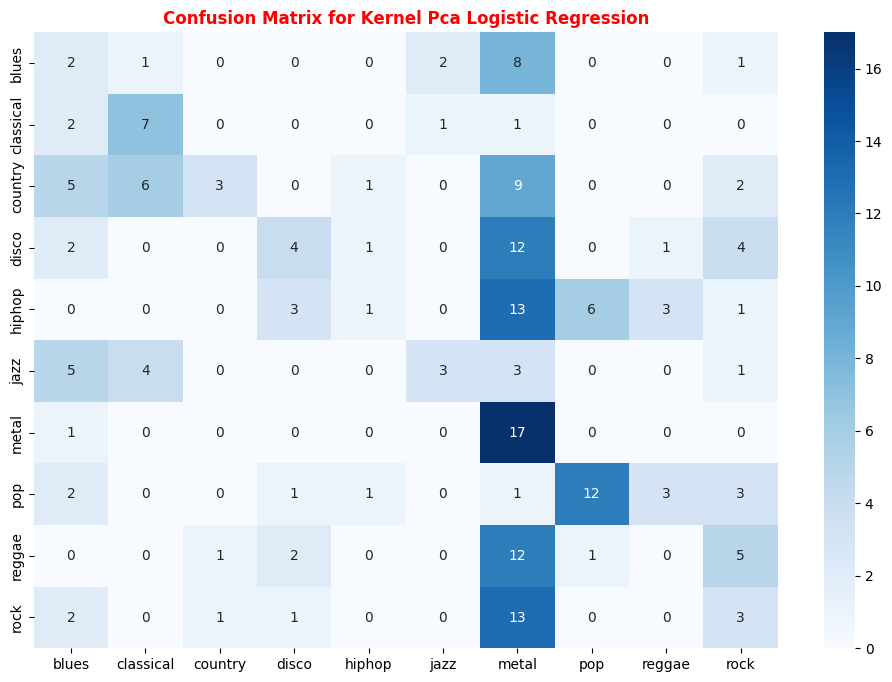

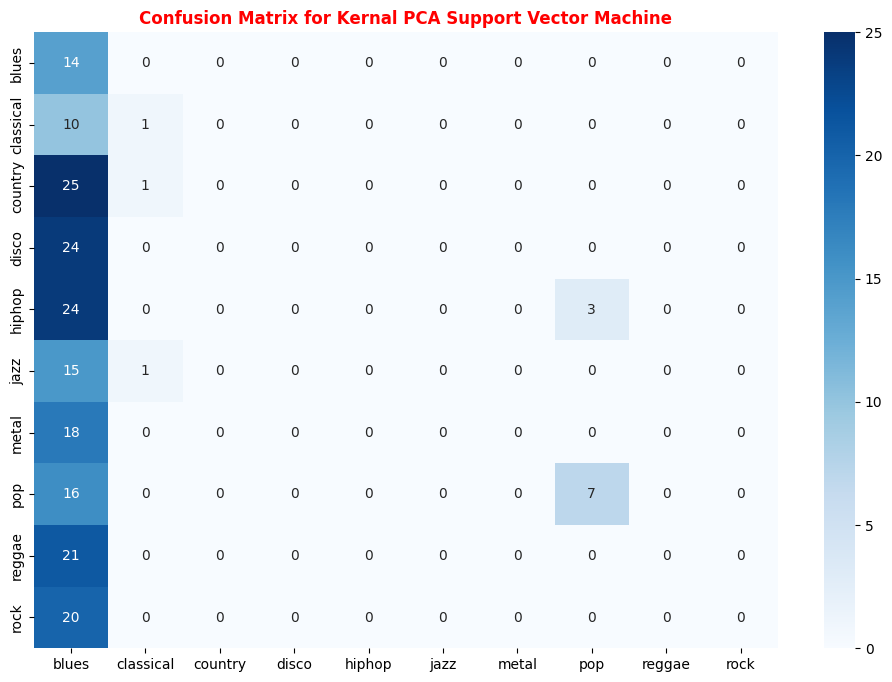

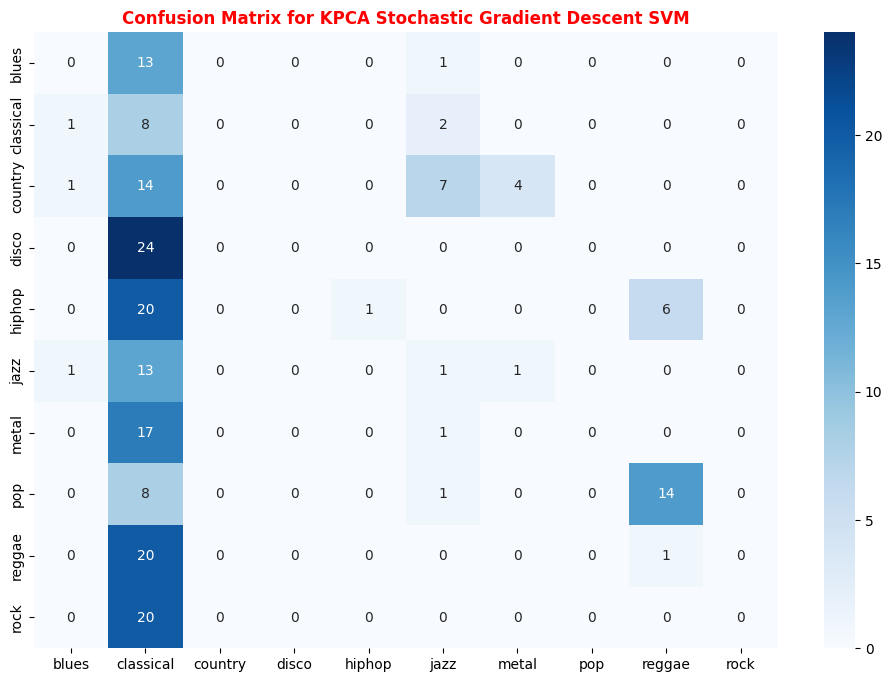

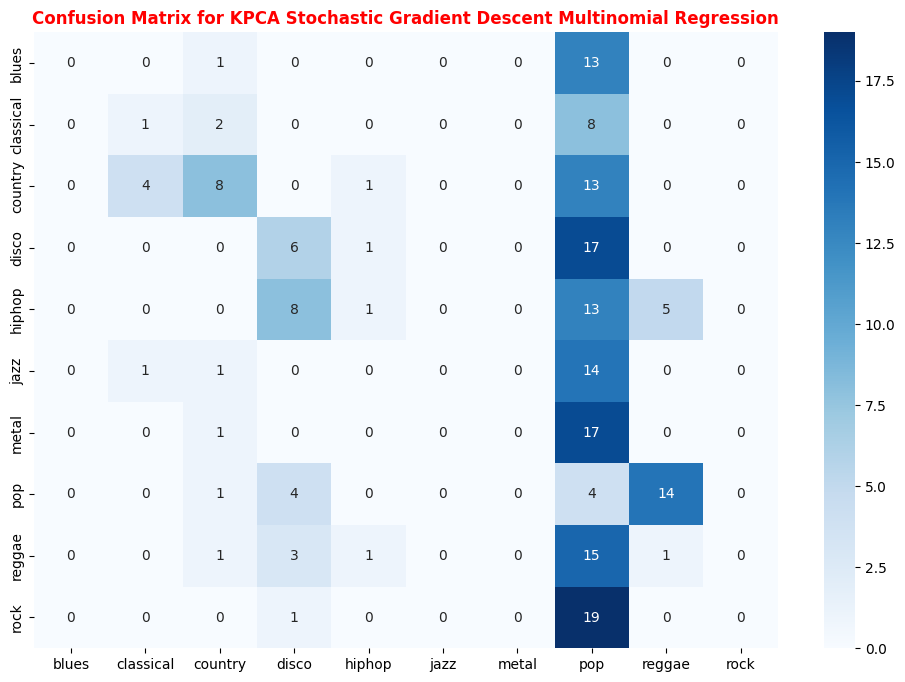

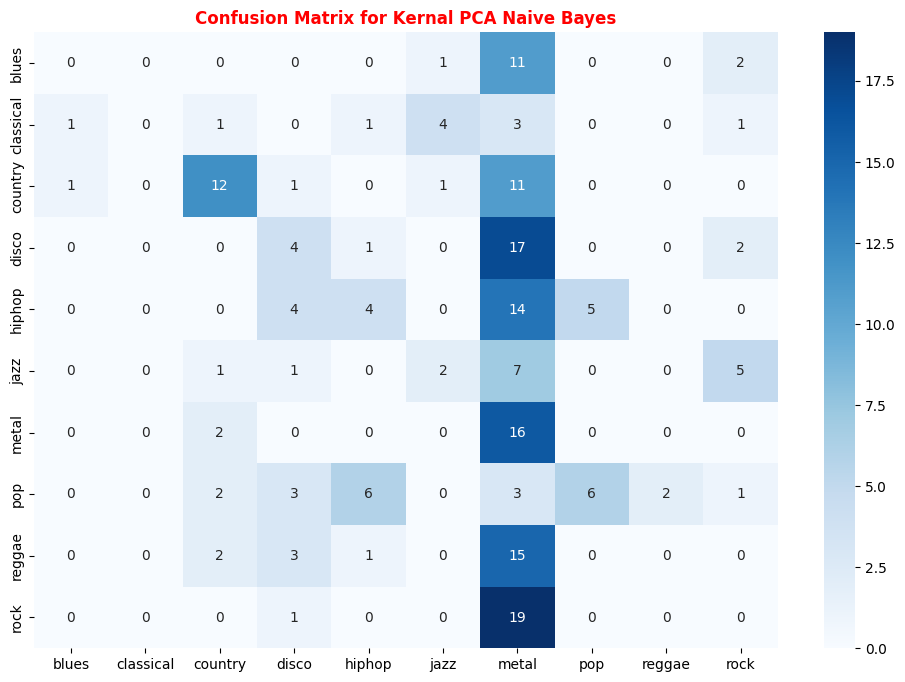

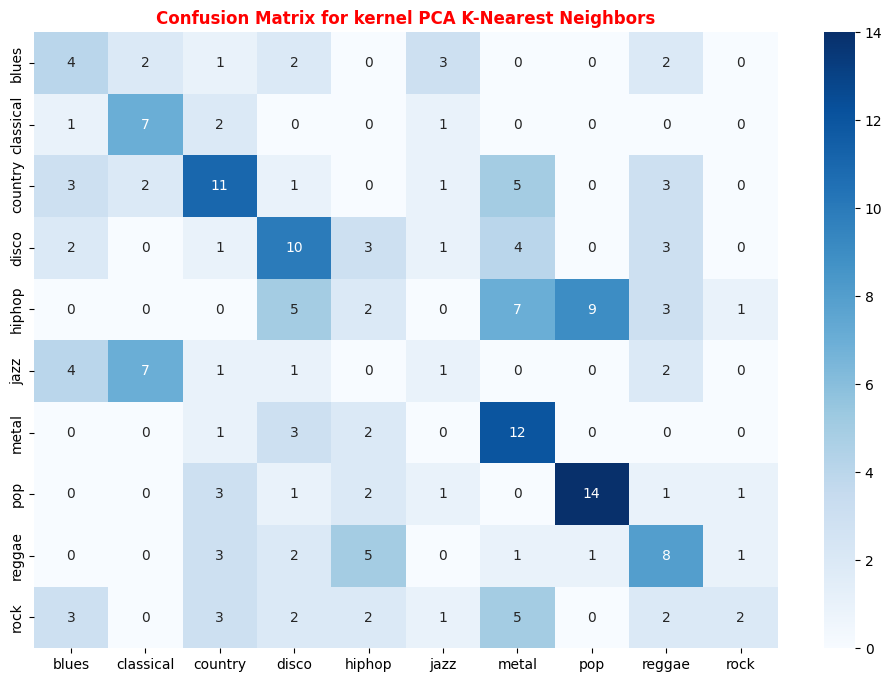

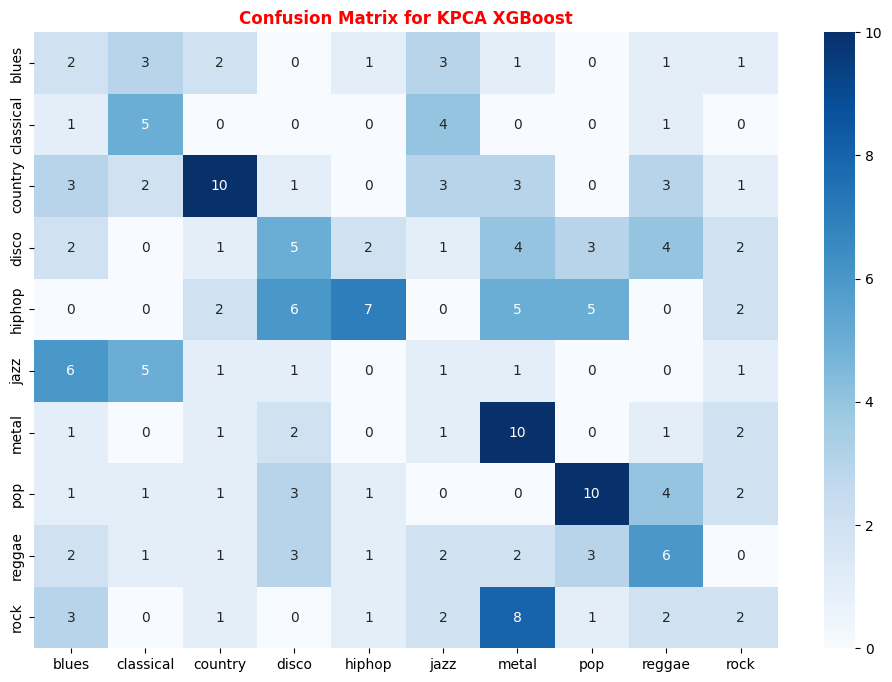

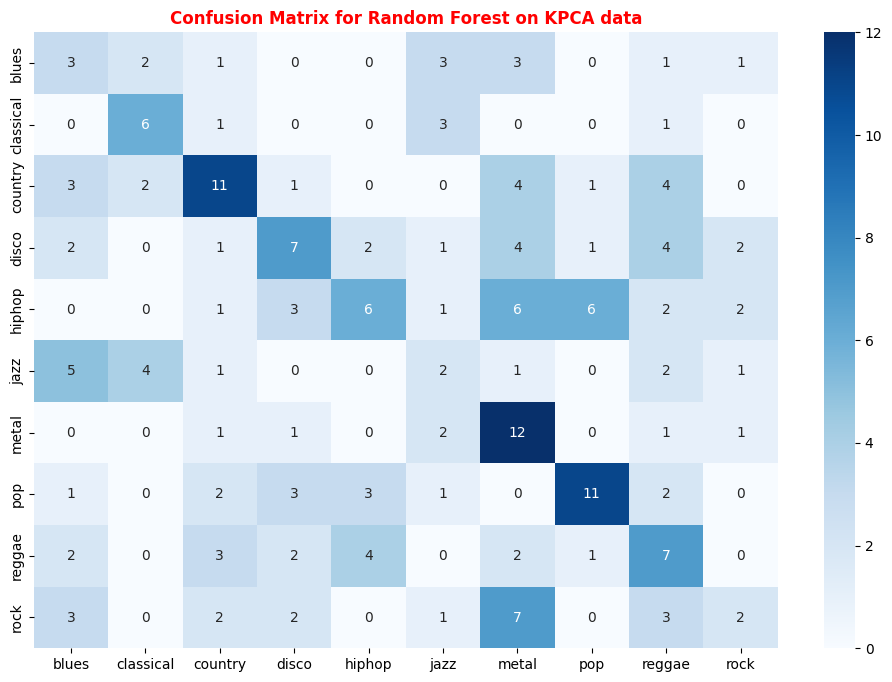

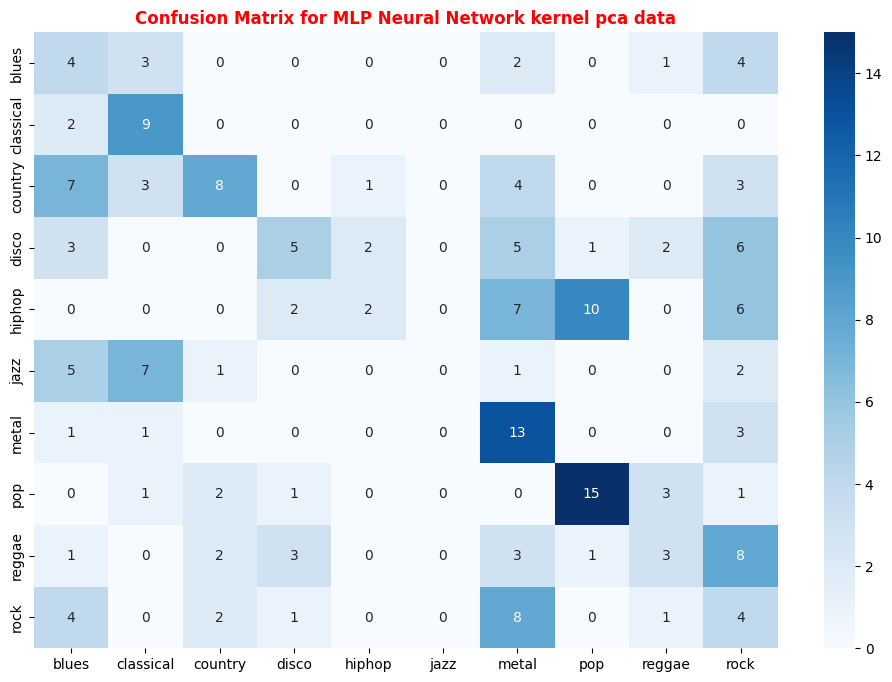

In [51]:
# Clear the kpca_Accuracy list before appending new values
kpca_Accuracy = []

# Evaluating various models after applying Kernel PCA

# Logistic Regression on Kernel PCA data
lr = LogisticRegression( penalty='l2',max_iter=1000)
accuracy = model_evala(lr,'Kernel Pca Logistic Regression', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)


# Support Vector Machine on Kernel PCA data
svm = SVC(decision_function_shape="ovo")
accuracy = model_evala(svm,'Kernal PCA Support Vector Machine', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

# Stochastic Gradient Descent SVM on Kernel PCA data
sgd = SGDClassifier(max_iter=7000,loss = 'log_loss', random_state=0)
accuracy = model_evala(sgd,'KPCA Stochastic Gradient Descent SVM', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

# Stochastic Gradient Descent Multinomial regression on Kernel PCA data
sgd = SGDClassifier(max_iter=7000, random_state=0)
accuracy = model_evala(sgd,'KPCA Stochastic Gradient Descent Multinomial Regression', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

# Gaussian Naive Bayes on Kernel PCA data
nb = GaussianNB()
accuracy = model_evala(nb,'Kernal PCA Naive Bayes', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

# K-Nearest Neighbors on Kernel PCA data
knn = KNeighborsClassifier(n_neighbors=23)
accuracy = model_evala(knn,'kernel PCA K-Nearest Neighbors', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

# XGBoost on Kernel PCA data
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
accuracy = model_evala(xgb,'KPCA XGBoost', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

# Random Forest on Kernel PCA data
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
accuracy = model_evala(rforest,'Random Forest on KPCA data', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)


# Neural Network on Kernel PCA data
nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5050, 10), random_state=1)
accuracy = model_evala(nn,'MLP Neural Network kernel pca data', kpca_X_train, kpca_X_test)
kpca_Accuracy.append(accuracy)

In [52]:
# Dictionary storing the accuracies of different models and dimensionality reduction techniques
data = {
    'Models' : [
    'Logistic Regression',
    'Support Vector Machine',
    'Stochastic Gradient Descent(hinge)',
    'Stochastic Gradient Descent(log_loss)',
    'Gaussian Naive Bayes',
    'K-Nearest Neighbors',
    'XGBoost',
    'Random Forest',
    'Neural Network'
],
    'Original Accuracy': Original_model_accuracy,
    'Accuracy with PCA': PCA_Accuracy,
    'Accuracy with KPCA': kpca_Accuracy
}

# Create a DataFrame from the dictionary
df_accuracies = pd.DataFrame(data)

# Display the DataFrame
display(df_accuracies)

Models  Original Accuracy  \
0                    Logistic Regression              0.800   
1                 Support Vector Machine              0.725   
2     Stochastic Gradient Descent(hinge)              0.770   
3  Stochastic Gradient Descent(log_loss)              0.745   
4                   Gaussian Naive Bayes              0.580   
5                    K-Nearest Neighbors              0.715   
6                                XGBoost              0.715   
7                          Random Forest              0.705   
8                         Neural Network              0.790   

   Accuracy with PCA  Accuracy with KPCA  
0              0.670               0.260  
1              0.685               0.110  
2              0.580               0.055  
3              0.550               0.105  
4              0.570               0.220  
5              0.680               0.355  
6              0.705               0.290  
7              0.690               0.335  
8              0.710               0.315

**DISCUSSION**

Kernel PCA leads to very low accuracy. Probably because there are vary little non linear relation ship between the data and there is larger feature distortion than pca. This is some cases leads to  very severe underfit because the useful predictore aren't there anymore. This can be vidence in confusion matrices of logistic regression, SVM and Naive Byers which almost always predict one class **even though there is no class imbalance**.

One other dimentonality reduction techinique we can try is Linear Discrimanant Analysis

# **Linear Discriminant Analysis**

Linear Discriminant Analysis (LDA) is a supervised dimensionality reduction technique that projects data onto a lower-dimensional space while maximizing class separability.

LDA is is suprevised beacuse it needs class labes unlike pca.

Unlike PCA, which is unsupervised and focuses only on variance, LDA uses class labels to find the directions that best separate different classes.

To find the linear combinations of features (called discriminant components) that has thwo goals:

1)Maximize between-class variance (spread between class means)

2)Minimize within-class variance (spread within each class)

This leads to better class discrimination in fewer dimensions.

A rule of thumb for high dimentional data with fewer classes is the use the number of classes -1, that is the max no of components you can get.

**A plot representing the ability of LDA to increase seperability is shown in EXPLORATARY DATA ANALYSIS**

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#LDA dimentanility reduction using 9 components
lda = LinearDiscriminantAnalysis(n_components=9)
lda_X_train = lda.fit_transform(X_train,y_train)
lda_X_test = lda.transform(X_test)
#Initilize a list to store LDA accuracy data
LDA_accuracy = []

LDA Logistic Regression Accuracy: 0.755
              precision    recall  f1-score   support

       blues       0.69      0.79      0.73        14
   classical       0.92      1.00      0.96        11
     country       0.81      0.65      0.72        26
       disco       0.81      0.71      0.76        24
      hiphop       0.81      0.78      0.79        27
        jazz       0.88      0.88      0.88        16
       metal       0.67      0.89      0.76        18
         pop       0.82      0.78      0.80        23
      reggae       0.75      0.71      0.73        21
        rock       0.50      0.55      0.52        20

    accuracy                           0.76       200
   macro avg       0.76      0.77      0.77       200
weighted avg       0.76      0.76      0.76       200



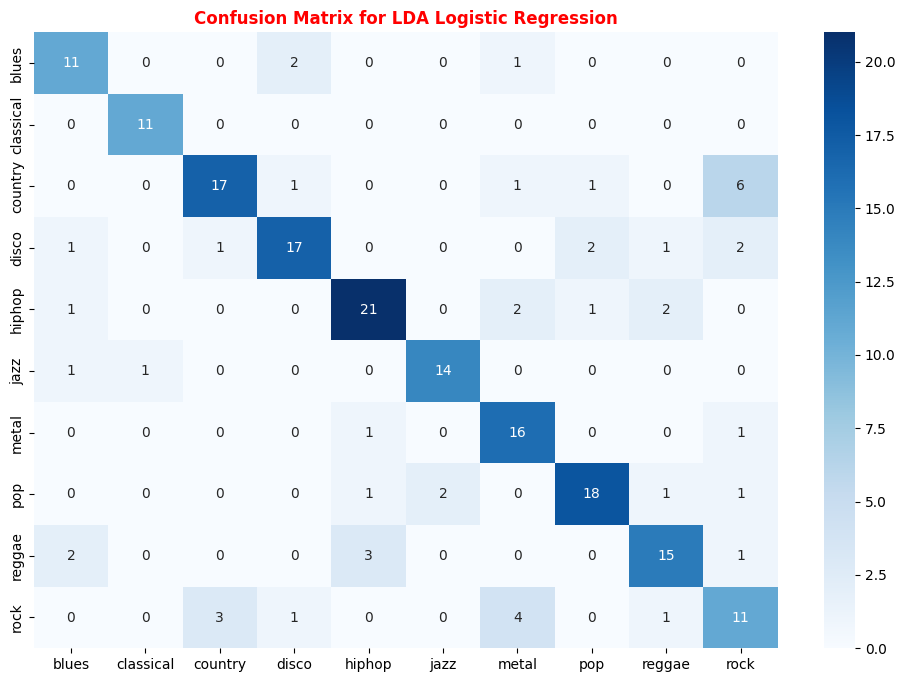

In [54]:
# Initialize and evaluate a Logistic Regression model on LDA data
lr = LogisticRegression( penalty='l2',max_iter=1000)
accuracy = model_evala(lr,'LDA Logistic Regression', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(accuracy)

LDA Support Vector Machine Accuracy: 0.75
              precision    recall  f1-score   support

       blues       0.75      0.86      0.80        14
   classical       0.92      1.00      0.96        11
     country       0.77      0.65      0.71        26
       disco       0.79      0.62      0.70        24
      hiphop       0.75      0.78      0.76        27
        jazz       0.88      0.88      0.88        16
       metal       0.70      0.89      0.78        18
         pop       0.90      0.78      0.84        23
      reggae       0.79      0.71      0.75        21
        rock       0.44      0.55      0.49        20

    accuracy                           0.75       200
   macro avg       0.77      0.77      0.77       200
weighted avg       0.76      0.75      0.75       200



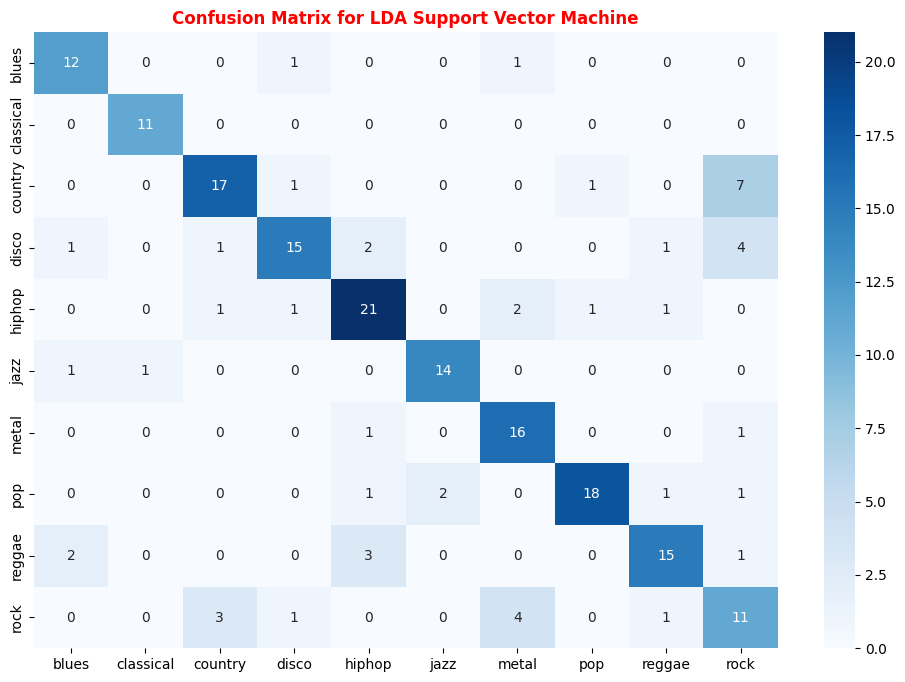

In [55]:
# Initialize and evaluate a Support Vector Machine model on LDA data
svm = SVC(decision_function_shape="ovo")
lda_accuracy = model_evala(svm,'LDA Support Vector Machine', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

LDA Stochastic Gradient Descent SVM Accuracy: 0.7
              precision    recall  f1-score   support

       blues       0.61      0.79      0.69        14
   classical       0.85      1.00      0.92        11
     country       0.81      0.50      0.62        26
       disco       0.80      0.50      0.62        24
      hiphop       0.74      0.74      0.74        27
        jazz       0.78      0.88      0.82        16
       metal       0.73      0.89      0.80        18
         pop       0.89      0.74      0.81        23
      reggae       0.68      0.71      0.70        21
        rock       0.37      0.55      0.44        20

    accuracy                           0.70       200
   macro avg       0.73      0.73      0.72       200
weighted avg       0.73      0.70      0.70       200



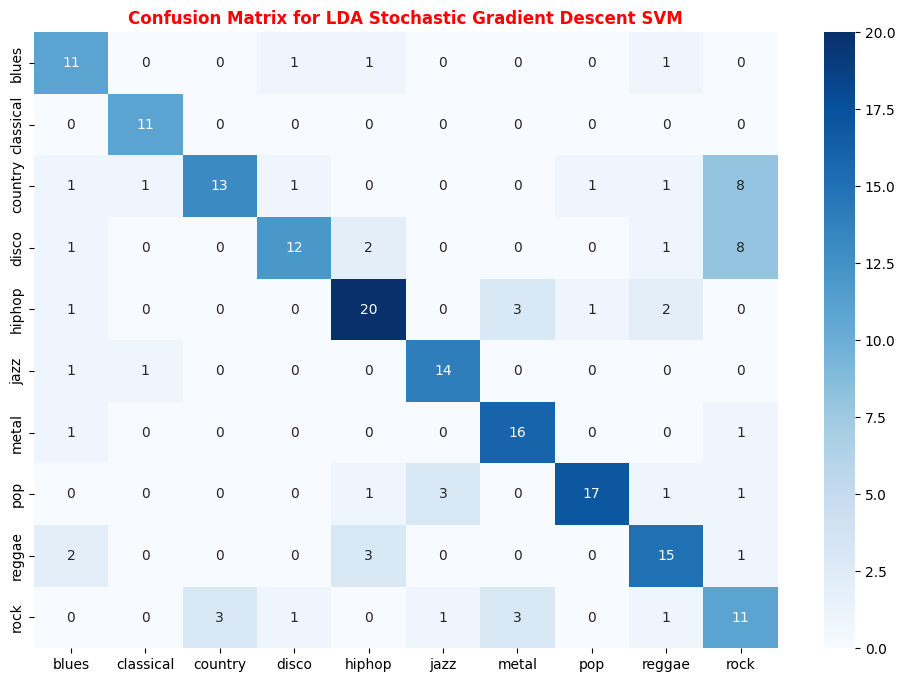

In [56]:
# Initialize and evaluate a Stochastic Gradient Descent (SVM) model on LDA data
sgd = SGDClassifier(max_iter=7000, random_state=0)
lda_accuracy = model_evala(sgd,'LDA Stochastic Gradient Descent SVM', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

LDA Stochastic Gradient Descent Multinomial Regression Accuracy: 0.7
              precision    recall  f1-score   support

       blues       0.61      0.79      0.69        14
   classical       0.85      1.00      0.92        11
     country       0.81      0.50      0.62        26
       disco       0.80      0.50      0.62        24
      hiphop       0.74      0.74      0.74        27
        jazz       0.78      0.88      0.82        16
       metal       0.73      0.89      0.80        18
         pop       0.89      0.74      0.81        23
      reggae       0.68      0.71      0.70        21
        rock       0.37      0.55      0.44        20

    accuracy                           0.70       200
   macro avg       0.73      0.73      0.72       200
weighted avg       0.73      0.70      0.70       200



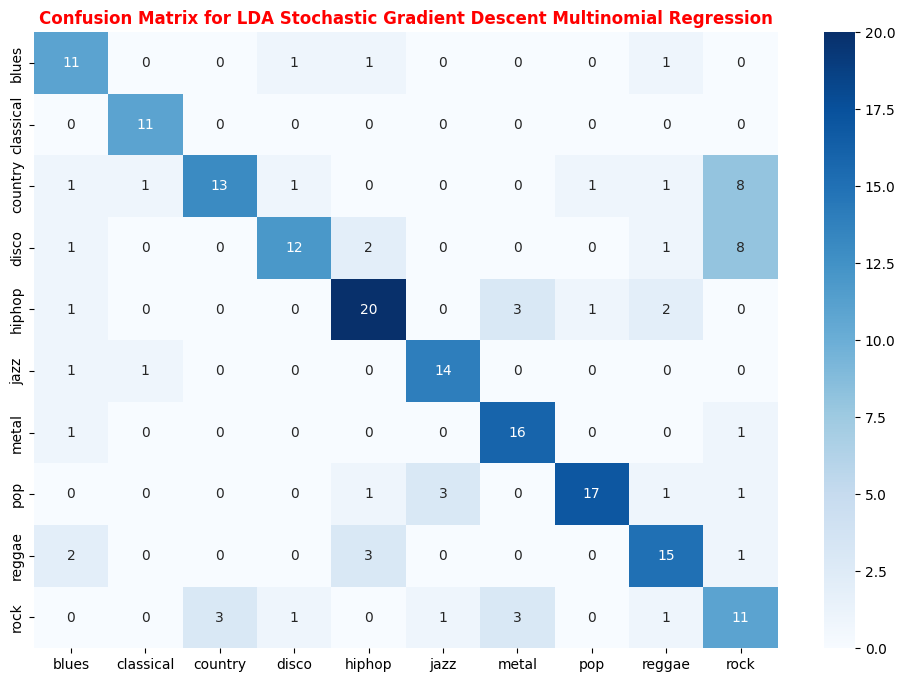

In [57]:
# Initialize and evaluate a Stochastic Gradient Descent (Multinomial Regression) model on LDA data
sgd = SGDClassifier(max_iter=7000, random_state=0)
lda_accuracy = model_evala(sgd,'LDA Stochastic Gradient Descent Multinomial Regression', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

LDA Naive Bayes Accuracy: 0.735
              precision    recall  f1-score   support

       blues       0.75      0.64      0.69        14
   classical       0.92      1.00      0.96        11
     country       0.83      0.58      0.68        26
       disco       0.67      0.58      0.62        24
      hiphop       0.73      0.81      0.77        27
        jazz       1.00      0.88      0.93        16
       metal       0.70      0.89      0.78        18
         pop       0.90      0.83      0.86        23
      reggae       0.80      0.76      0.78        21
        rock       0.38      0.55      0.45        20

    accuracy                           0.73       200
   macro avg       0.77      0.75      0.75       200
weighted avg       0.76      0.73      0.74       200



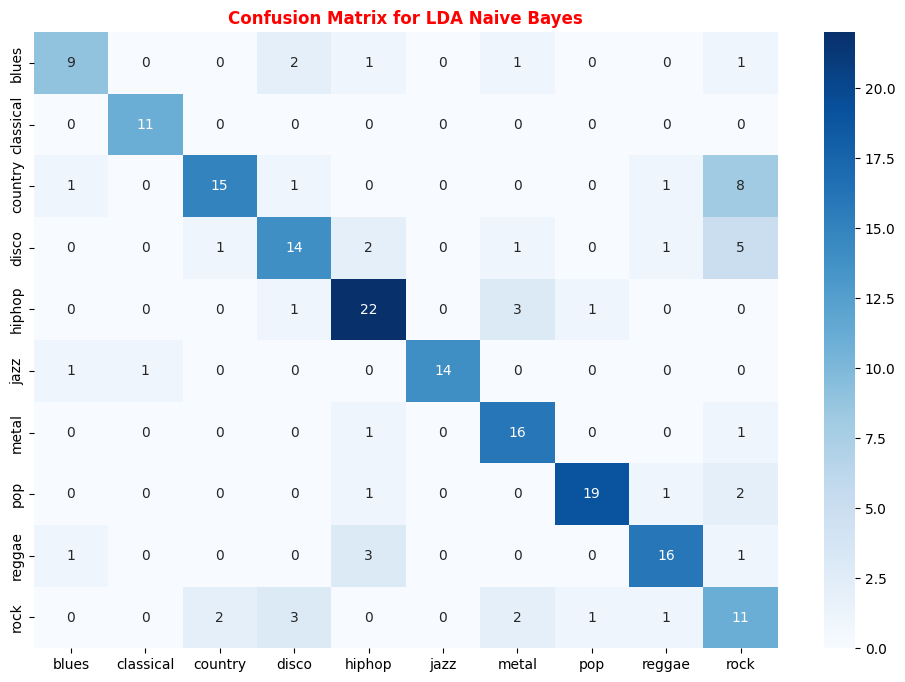

In [58]:
# Initialize and evaluate a Gaussian Naive Bayes model on LDA data
nb = GaussianNB()
lda_accuracy = model_evala(nb,'LDA Naive Bayes', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

LDA K-Nearest Neighbors Accuracy: 0.735
              precision    recall  f1-score   support

       blues       0.67      0.86      0.75        14
   classical       0.92      1.00      0.96        11
     country       0.71      0.58      0.64        26
       disco       0.76      0.67      0.71        24
      hiphop       0.75      0.67      0.71        27
        jazz       0.88      0.88      0.88        16
       metal       0.76      0.89      0.82        18
         pop       0.86      0.78      0.82        23
      reggae       0.79      0.71      0.75        21
        rock       0.44      0.60      0.51        20

    accuracy                           0.73       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.75      0.73      0.74       200



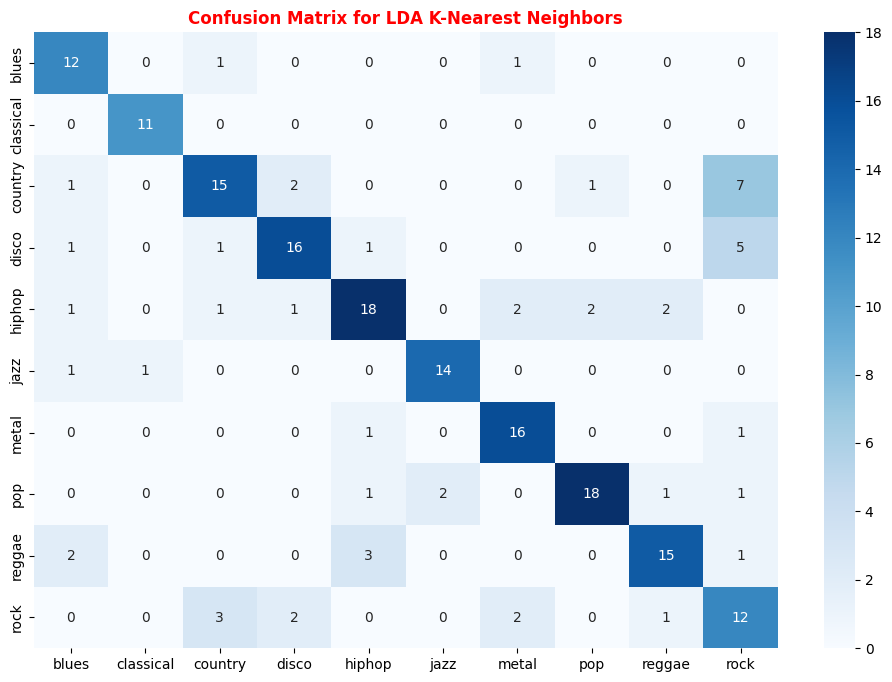

In [59]:
# Initialize and evaluate a K-Nearest Neighbors model on LDA data
knn = KNeighborsClassifier(n_neighbors=23)
lda_accuracy = model_evala(knn,'LDA K-Nearest Neighbors', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

LDA XGBoost Accuracy: 0.76
              precision    recall  f1-score   support

       blues       0.71      0.86      0.77        14
   classical       0.85      1.00      0.92        11
     country       0.80      0.62      0.70        26
       disco       0.78      0.58      0.67        24
      hiphop       0.80      0.89      0.84        27
        jazz       0.93      0.88      0.90        16
       metal       0.80      0.89      0.84        18
         pop       0.86      0.78      0.82        23
      reggae       0.75      0.71      0.73        21
        rock       0.46      0.60      0.52        20

    accuracy                           0.76       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.77      0.76      0.76       200



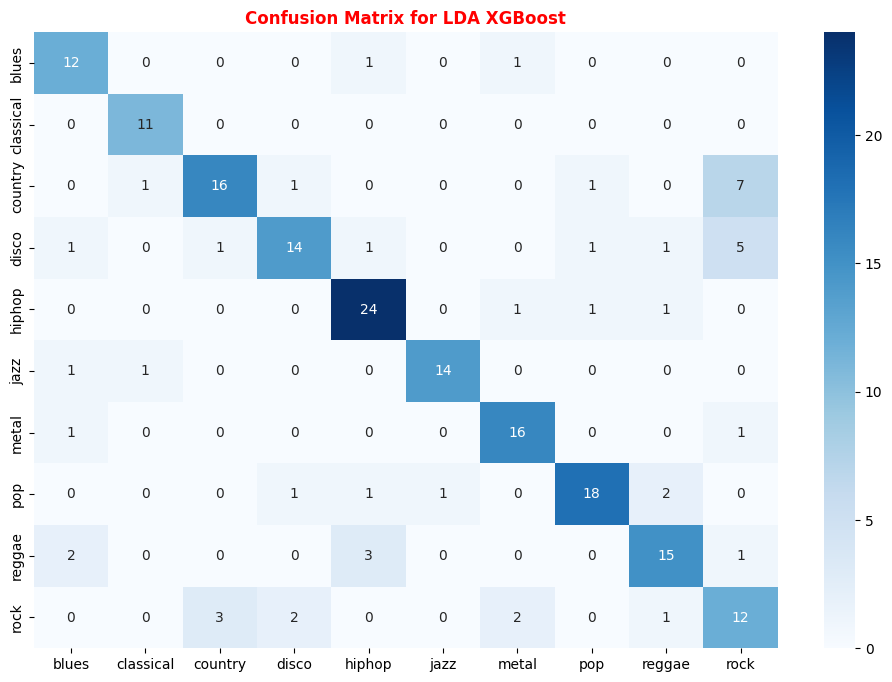

In [60]:
# Initialize and evaluate an XGBoost model on LDA data
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
lda_accuracy = model_evala(xgb,'LDA XGBoost', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

Random Forest on LDA data Accuracy: 0.75
              precision    recall  f1-score   support

       blues       0.59      0.71      0.65        14
   classical       0.92      1.00      0.96        11
     country       0.80      0.62      0.70        26
       disco       0.77      0.71      0.74        24
      hiphop       0.77      0.74      0.75        27
        jazz       0.82      0.88      0.85        16
       metal       0.80      0.89      0.84        18
         pop       0.90      0.78      0.84        23
      reggae       0.73      0.76      0.74        21
        rock       0.50      0.60      0.55        20

    accuracy                           0.75       200
   macro avg       0.76      0.77      0.76       200
weighted avg       0.76      0.75      0.75       200



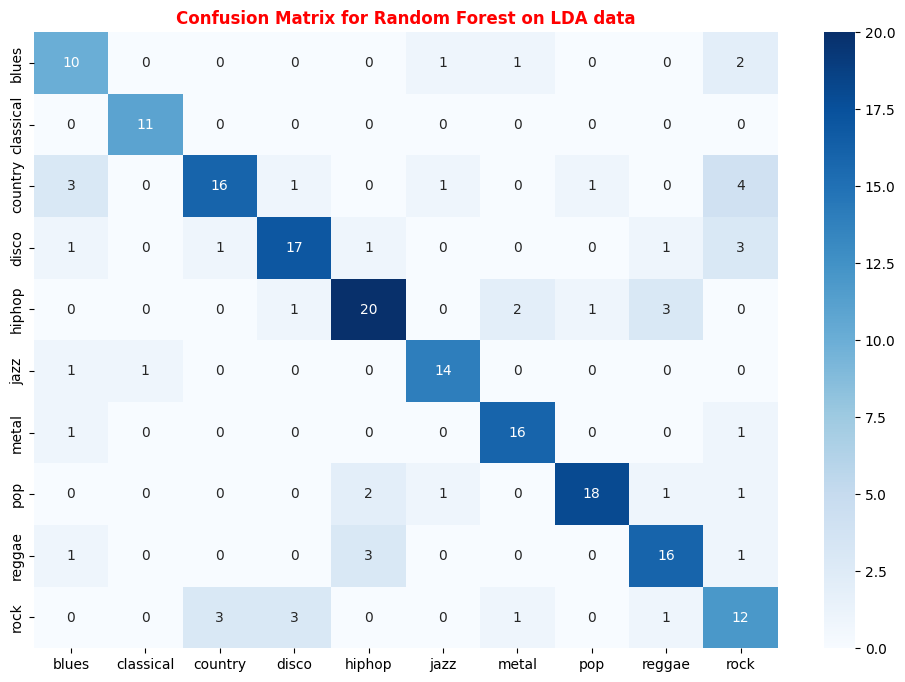

In [61]:
# Initialize and evaluate a Random Forest model on LDA data
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
lda_accuracy = model_evala(rforest,'Random Forest on LDA data', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

Neural Network on LDA data Accuracy: 0.705
              precision    recall  f1-score   support

       blues       0.56      0.64      0.60        14
   classical       0.92      1.00      0.96        11
     country       0.81      0.65      0.72        26
       disco       0.87      0.54      0.67        24
      hiphop       0.68      0.78      0.72        27
        jazz       0.88      0.88      0.88        16
       metal       0.73      0.89      0.80        18
         pop       0.67      0.61      0.64        23
      reggae       0.68      0.71      0.70        21
        rock       0.46      0.55      0.50        20

    accuracy                           0.70       200
   macro avg       0.72      0.73      0.72       200
weighted avg       0.72      0.70      0.70       200



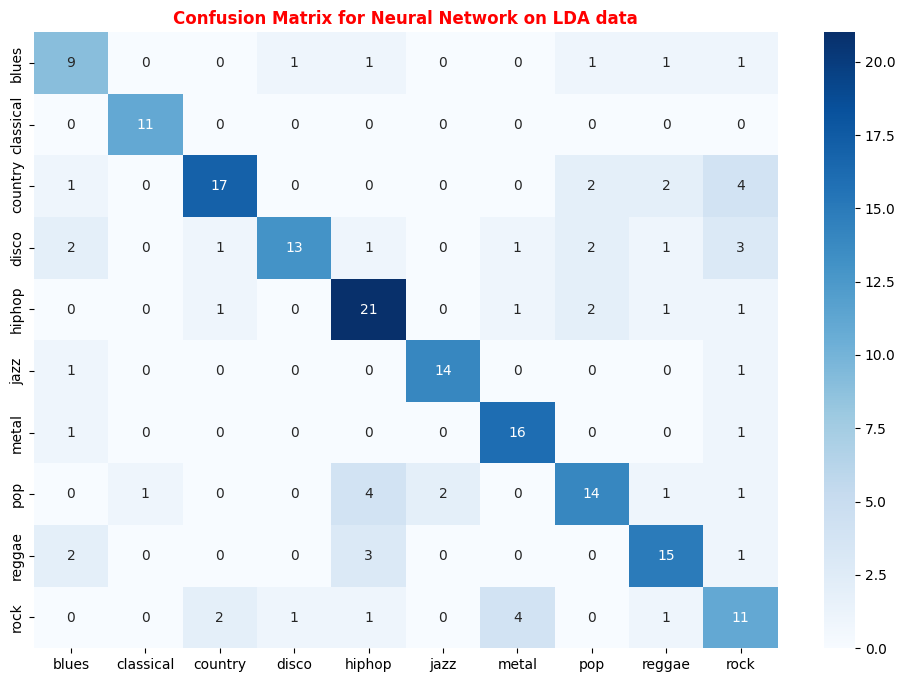

In [62]:
# Initialize and evaluate a Neural Network (MLP) model on LDA data
nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5050, 10), random_state=1)
lda_accuracy = model_evala(nn,'Neural Network on LDA data', lda_X_train, lda_X_test)
# Append the accuracy to the list
LDA_accuracy.append(lda_accuracy)

In [63]:
# Dictionary storing the accuracies of different models and dimensionality reduction techniques
data = {
    'Models' : [
    'Logistic Regression',
    'Support Vector Machine',
    'Stochastic Gradient Descent(hinge)',
    'Stochastic Gradient Descent(log_loss)',
    'Gaussian Naive Bayes',
    'K-Nearest Neighbors',
    'XGBoost',
    'Random Forest',
    'Neural Network'
],
    'Original Accuracy': Original_model_accuracy,
    'Accuracy with PCA': PCA_Accuracy,
    'Accuracy with KPCA': kpca_Accuracy,
    'Accuracy with LDA': LDA_accuracy
}


# Create a DataFrame from the dictionary
df_accuracies = pd.DataFrame(data)

# Display the DataFrame
display(df_accuracies)

Models  Original Accuracy  \
0                    Logistic Regression              0.800   
1                 Support Vector Machine              0.725   
2     Stochastic Gradient Descent(hinge)              0.770   
3  Stochastic Gradient Descent(log_loss)              0.745   
4                   Gaussian Naive Bayes              0.580   
5                    K-Nearest Neighbors              0.715   
6                                XGBoost              0.715   
7                          Random Forest              0.705   
8                         Neural Network              0.790   

   Accuracy with PCA  Accuracy with KPCA  Accuracy with LDA  
0              0.670               0.260              0.755  
1              0.685               0.110              0.750  
2              0.580               0.055              0.700  
3              0.550               0.105              0.700  
4              0.570               0.220              0.735  
5              0.680               0.355              0.735  
6              0.705               0.290              0.760  
7              0.690               0.335              0.750  
8              0.710               0.315              0.705

**DISCUSSION**

Rock seem to the one of the worst performers if not the worst performer in almost all the models.

LDA does improve the accuracy scores for some models. This could be because it is doint what its supposed to be doing, it reduces the dimention while maximizing the class seperability. The reduced dimention and reduces noise which helps prevent overfit. It also leads to a less complex model which helps in generalizability. LDA also redues the correlaton between components which helps some models which assume uncorrelatd components.

This is patricularly true for naive bayers because LDA also reduces correation between components while preserving class sepreability as evidenced by the plots of correlation heatmap of lda components below, its between 0.10 - 0.15, which is far below 0.10 - 0.70 in the orginal data which in this case is better than uncorrelated data given by pca.

This is also true for KNN because it reduces the dimentions and KNN need less data as dimentanlity decreses. A good way to put it is KNN suffers from "curse of dimensionality" and needs more data as as no of features increase.



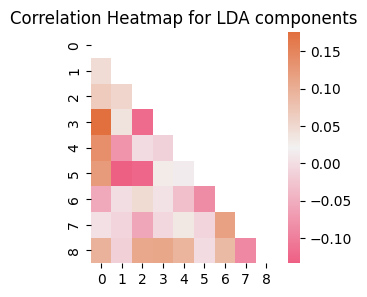

In [64]:
import pandas as pd
# Create a DataFrame from the LDA test data
df = pd.DataFrame(lda_X_test)
# Computing the Correlation Matrix for LDA components
heat_map_cols = [col for col in df.columns ]
corr = df[heat_map_cols].corr()

# Generate a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure for the heatmap
plt.subplots(figsize=(3, 3))

# Define the color map for the heatmap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=80, l=60)

# Draw the heatmap
sns.heatmap(corr,cmap = cmap,mask = mask)

# Set the title of the heatmap
plt.title('Correlation Heatmap for LDA components')
# Display the heatmap
plt.show()

# **Conv Neural Net**

Can we make a model directy on the raw data rather than the mean, variance and higher order moments?
yes. One of them is 2d conv Neural Net.

To perform 2D convolution on audio data, first we need to represent the audio data in an image format. For this project we will try to stack the vectors we get from mfcc's into one layer, short time fourier transform into one layer and spectral features and chroma stft into one layer.

We get a RBG image. We can pad these vectors to make sure that they are of the same size.

We choose this representation because for 2d conv to work the way we make an image from audio data should make visual sense and this meathod is take from an article from Towards data science(link below).

The generate_features , get_features, padding functions are taken from this article
https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab/

In [3]:
# Define genre list and corrupted files
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
CORRUPTED_FILES = ["jazz.00054.wav"]

# Function to generate a DataFrame with file paths and genre labels
def generate_file_table(path):
    paths = list(Path(path).glob("**/*.wav"))
    paths = [p for p in paths if "._" not in p.name]
    data = []

    for path in paths:
        label = path.parts[-2]
        name = path.parts[-1]
        if name in CORRUPTED_FILES:
            continue

        data.append({"file": str(path), "genre": label})
    df = pd.DataFrame(data)
    df.sort_values("file", inplace=True)
    return df

# Function to generate image-like features from audio
def generate_features(y_cut, sr, n_fft, hop_length, n_mfcc):
  max_size= 1700 #my max audio file feature width
  stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length = hop_length)), 128, max_size)
  MFCCs = padding(librosa.feature.mfcc(y=y_cut,sr=sr),128,max_size)
  spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
  chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
  #Now the padding part
  image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
  image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0)
#repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
  for i in range(0,9):
      image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
      image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
      image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
  image=np.dstack((image,np.abs(stft)))
  image=np.dstack((image,MFCCs))
  return image

# Function to pad arrays to a consistent size
def padding(array, xx, yy):
  h = array.shape[0]
  w = array.shape[1]
  a = max((xx - h) // 2,0)
  aa = max(0,xx - a - h)
  b = max(0,(yy - w) // 2)
  bb = max(yy - b - w,0)
  return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

# Function to get features and labels from the DataFrame
def get_features(data):
  features=[]
  labels = data.pop('genre').to_numpy()
  for index,i in data.iterrows():
          audio,_ = librosa.load(i['file'],sr=28000)
          #cut the file to signal start and end
          y_cut, _=  librosa.effects.trim(audio)
          #generate features &amp; output numpy array
          data = generate_features(y_cut, sr=28000, n_fft=255, hop_length=512, n_mfcc=128)
          features.append(data[np.newaxis,...])
  output=np.concatenate(features,axis=0)
  return np.array(output), labels

The above cell consists of helper functions to extract the features.

The cell below uses the helper functions encode the labels and dumps the data into a pickle file

In [8]:
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
from keras import layers, models
from keras.src.optimizers.adam import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Define the path to the genre data
path = '/content/drive/MyDrive/genres'
# Generate the file table DataFrame
data = generate_file_table(path)
# Split the data into training, testing, and validation sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)
X_train, X_val = train_test_split(X_train, test_size=0.05, random_state=1)

# Get features and labels for validation, testing, and training sets
val_features, val_labels = get_features(X_val)
test_features, test_labels = get_features(X_test)
train_features, train_labels = get_features(X_train)


    # Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
val_labels_encoded = label_encoder.transform(val_labels)

    # One-hot encode labels
train_labels_onehot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=len(GENRES))
val_labels_onehot = tf.keras.utils.to_categorical(val_labels_encoded, num_classes=len(GENRES))
test_labels_onehot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=len(GENRES))

# Save the processed data to a pickle file
with open('/content/drive/MyDrive/my_data.pkl', 'wb') as f:
  pickle.dump(train_features,f)
  pickle.dump(train_labels_onehot,f)
  pickle.dump(val_features,f)
  pickle.dump(val_labels_onehot,f)
  pickle.dump(test_features,f)
  pickle.dump(test_labels_onehot,f)
f.close()

Next we make a 2d conv model after loading the data from the pickle file.

Because of the limited amount of data just 1000 images for 10 classes we try to keep the model simple and prevent overfit

The first layers consists of 5*5 kernel with 2 filters with batch normalization and then RELU activation.

To pervent overfit the next layer is a 0.3 dropout layer

The next layer is 5*5 max pooling

The next layer is flatten.

The next layer hast 1024 neurons with batch normalization and then RELU activation.

The next is a drop out with 0.3

The next layer hast 256 neurons with batch normalization and then RELU activation.

We dont have a dropout because the next layer is the output layer

The next layer is output with 10 neurons 1 for each class with lof_softmax activation.

We also use early stopping to prevent overfit.


In [9]:
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization
from keras import layers, models
from keras.src.optimizers.adam import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the processed data from the pickle file
with open('/content/drive/MyDrive/my_data.pkl', 'rb') as f:
  train_features= pickle.load(f)
  train_labels_onehot = pickle.load(f)
  val_features = pickle.load(f)
  val_labels_onehot = pickle.load(f)
  test_features = pickle.load(f)
  test_labels_onehot = pickle.load(f)
f.close()

# Building the Conv 2d neural network

# Define the input shape of the images
input_shape=(128,1700,3)
# Create a Sequential model
CNNmodel = models.Sequential()

# Add the first Convolutional layer with Batch Normalization and ReLU activation
CNNmodel.add(layers.Conv2D(2, (5, 5), input_shape=input_shape))
CNNmodel.add(BatchNormalization())
CNNmodel.add(layers.Activation('relu'))
# Add a MaxPooling layer
CNNmodel.add(layers.MaxPooling2D((5, 5)))
# Add a Dropout layer to prevent overfitting
CNNmodel.add(layers.Dropout(0.3))

# Flatten the output of the convolutional layers
CNNmodel.add(layers.Flatten())
# Add a Dense layer with Batch Normalization and ReLU activation
CNNmodel.add(layers.Dense(1024))
CNNmodel.add(BatchNormalization())
CNNmodel.add(layers.Activation('relu'))
# Add another Dropout layer
CNNmodel.add(layers.Dropout(0.3))

# Add another Dense layer with Batch Normalization and ReLU activation
CNNmodel.add(layers.Dense(256))
CNNmodel.add(BatchNormalization())
CNNmodel.add(layers.Activation('relu'))

# Add the output Dense layer with log_softmax activation
CNNmodel.add(layers.Dense(len(GENRES), activation='log_softmax')) # Output layer size should be the number of genres

# Define Early Stopping callback to prevent overfitting
early_stopping = EarlyStopping(
  monitor='val_accuracy',  # Metric to monitor (e.g., validation accuracy)
  mode='max',              # 'max' for accuracy, 'min' for loss
  patience= 10,             # Number of epochs to wait for improvement
  restore_best_weights=True # Revert to weights from the best epoch
)

# Compile the model
CNNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model with early stopping
history = CNNmodel.fit(train_features, train_labels_onehot, epochs=20, validation_data= (val_features, val_labels_onehot),verbose=2,
      callbacks=[early_stopping]
)
# Evaluate the model on the test data
test_loss, test_acc = CNNmodel.evaluate(test_features, test_labels_onehot, verbose=2)
# Print the test accuracy
print(test_acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
24/24 - 11s - 438ms/step - accuracy: 0.0975 - loss: 1.6118 - val_accuracy: 0.1000 - val_loss: 1.6118
Epoch 2/20
24/24 - 1s - 33ms/step - accuracy: 0.0988 - loss: 1.6118 - val_accuracy: 0.1000 - val_loss: 1.6118
Epoch 3/20
24/24 - 1s - 33ms/step - accuracy: 0.0975 - loss: 1.6118 - val_accuracy: 0.1000 - val_loss: 1.6118
Epoch 4/20
24/24 - 1s - 33ms/step - accuracy: 0.0935 - loss: 1.6118 - val_accuracy: 0.0750 - val_loss: 1.6118
Epoch 5/20
24/24 - 1s - 35ms/step - accuracy: 0.1014 - loss: 1.6118 - val_accuracy: 0.1500 - val_loss: 1.6118
Epoch 6/20
24/24 - 1s - 34ms/step - accuracy: 0.0962 - loss: 1.6118 - val_accuracy: 0.1000 - val_loss: 1.6118
Epoch 7/20
24/24 - 1s - 33ms/step - accuracy: 0.0988 - loss: 1.6118 - val_accuracy: 0.0500 - val_loss: 1.6118
Epoch 8/20
24/24 - 1s - 33ms/step - accuracy: 0.0975 - loss: 1.6118 - val_accuracy: 0.0000e+00 - val_loss: 1.6118
Epoch 9/20
24/24 - 1s - 33ms/step - accuracy: 0.1001 - loss: 1.6118 - val_accuracy: 0.0000e+00 - val_loss: 1.6118


**DISCUSSION**

The test accuracy is seems  to low be even though the train loss is very low. This seems to suggest overfit even after all the precautions taken to prevent it. This could be because conv 2d needs a lot of data and just 1000 images for 10 classes seems to low.

# **Further Analysis on best performing model**

Now we will take a close look at our best preforming model Logistic Regression. Espically we will see if all the predictors are statistically significant and if we can do some feature selection to improve accuracy or generalizability.

In [65]:
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
# Fit a Multinomial Logistic Regression model using statsmodels
model = sm.MNLogit(y_train,X_train)
result = model.fit()
# Print the summary of the model
print(result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  799
Model:                        MNLogit   Df Residuals:                      -38
Method:                           MLE   Df Model:                          828
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:                     nan
Time:                        07:15:47   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1838.3
Covariance Type:            nonrobust   LLR p-value:                       nan
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1                nan        nan        nan        nan         nan         nan
x2                nan        nan  

Almost all the p values seem to be less than 0.05 so they seem to be statistically significant. Lets check if feature selection improves accuracy.

In [66]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Perform Recursive Feature Elimination with Cross-Validation (RFECV)
model = LogisticRegression()
rfecv = RFECV(estimator=model,scoring='accuracy')
rfecv.fit(X_train, y_train)
# Transform the test data using the selected features
X_test_selected = rfecv.transform(X_test)
# Make predictions on the selected test features
pred = rfecv.predict(X_test)
# Print the accuracy score
print(accuracy_score(y_test,pred))

0.735


Almost all predictors in all nine equations seem to be statistically signficant and feature selection seems to reduce the accuracy so we will choose the original model.

Now lets look at the weights for each feature for some features

In [67]:
import pandas as pd

# Get the coefficients from the trained Logistic Regression model
coefficients = lr.coef_

# Get the names of the features (columns) from the DataFrame
feature_names = df.columns

# Reshape the coefficients array for easier handling
coefficients_reshaped = coefficients.T

# Get the names of the genres from the label encoder
genre_names = label_encoder.classes_

# Create a DataFrame to display the coefficients with feature and genre names
weights_df = pd.DataFrame(coefficients_reshaped, index=feature_names, columns=genre_names)

# Print the DataFrame containing the weights
print(weights_df)

      blues  classical   country     disco    hiphop      jazz     metal  \
0  0.254784   2.974805 -0.189474 -0.305281 -1.508319  1.712370 -1.173761   
1 -1.047042  -0.465626  0.142243  0.437745  0.539306 -0.530545 -1.727944   
2  0.844129  -0.034183  0.167777 -0.091393  0.512306  0.048227 -1.121339   
3  0.309968   0.008365 -0.051665 -0.328007 -0.834586  1.316514 -0.094228   
4 -0.399826   0.365178  2.066141 -0.350778 -1.087467 -0.991605 -0.324124   
5 -1.951675   0.199702  0.092469 -0.527210 -0.232227  1.081862  0.593329   
6 -0.164556  -0.234777 -0.228450  1.279136 -0.842110 -0.154491 -0.412066   
7  0.927787   0.216619 -0.600064 -1.175773 -0.558782  0.165175  0.159796   
8  0.047152  -0.166146 -0.339414 -0.765203 -0.049061 -0.526743 -0.078407   

        pop    reggae      rock  
0 -0.821030 -0.452120 -0.491974  
1  2.073623  1.207534 -0.629293  
2 -1.309547  1.008611 -0.024590  
3  0.479997 -1.090690  0.284333  
4  0.379984 -0.135582  0.478079  
5  0.049061  0.480990  0.213698  
6

# **Final Discussion**

The best performing models seems to be logistic regression and MLP classifier on original data. The feature seems to be more important and modifing the features by doing PCA seems to lead to decline in all the models including Naive bayers even when the correlation in orginal data seems to be high. Kernel PCA seems to lead to very low accuracy in all the models and by the confusion matrices and some models after kernal pca seem to consistly predict just one class could be because feature distortion leading to underfit. LDA seems to preserve most of the accuracy for most models and increase accurcy for some model. Fitting 2D cov neural net seems to lead to overfit even with precaution like small no of filters, larger kernel sizes, pooling, dropout and early stopping. This could be due to lack of enough data.

Most or almost all models seem to perform bad on rock genre.

Below is a table showing all the accuracies

In [68]:
# Display the DataFrame containing the model accuracies
display(df_accuracies)

Models  Original Accuracy  \
0                    Logistic Regression              0.800   
1                 Support Vector Machine              0.725   
2     Stochastic Gradient Descent(hinge)              0.770   
3  Stochastic Gradient Descent(log_loss)              0.745   
4                   Gaussian Naive Bayes              0.580   
5                    K-Nearest Neighbors              0.715   
6                                XGBoost              0.715   
7                          Random Forest              0.705   
8                         Neural Network              0.790   

   Accuracy with PCA  Accuracy with KPCA  Accuracy with LDA  
0              0.670               0.260              0.755  
1              0.685               0.110              0.750  
2              0.580               0.055              0.700  
3              0.550               0.105              0.700  
4              0.570               0.220              0.735  
5              0.680               0.355              0.735  
6              0.705               0.290              0.760  
7              0.690               0.335              0.750  
8              0.710               0.315              0.705

In [ ]:
# Convert the accuracies DataFrame to a CSV file and download it
filename = 'model_accuracies.csv'
df_accuracies.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Possible Future work:**

Rock and Ensamble learning

Rock seems to perform badly on most models. Extracting features that could differentiate rock from other classes and training model specifically to reconize rock and ensambling them with well performing models could lead to improvement. There seems to same variance in the best performing classes of different models ensambling some of them could lead to improvement.

Data Augmentation:

2D conv neural net seems to suffer from overfit and data augmentation could help. Data Augmentation could help other models as well.